<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-and-functions" data-toc-modified-id="Data-and-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data and functions</a></span></li><li><span><a href="#PSC/SIF-correlations-per-ROI" data-toc-modified-id="PSC/SIF-correlations-per-ROI-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>PSC/SIF correlations per ROI</a></span><ul class="toc-item"><li><span><a href="#No-Think" data-toc-modified-id="No-Think-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>No-Think</a></span></li><li><span><a href="#Think" data-toc-modified-id="Think-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Think</a></span></li><li><span><a href="#Think---No-Think" data-toc-modified-id="Think---No-Think-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Think - No-Think</a></span></li></ul></li><li><span><a href="#PSC/SIF-correlations-per-dataset-and-per-ROI" data-toc-modified-id="PSC/SIF-correlations-per-dataset-and-per-ROI-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PSC/SIF correlations per dataset and per ROI</a></span><ul class="toc-item"><li><span><a href="#No-Think" data-toc-modified-id="No-Think-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>No-Think</a></span></li><li><span><a href="#Think" data-toc-modified-id="Think-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Think</a></span></li><li><span><a href="#Think-No-Think" data-toc-modified-id="Think-No-Think-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Think-No-Think</a></span></li></ul></li></ul></div>

# Data and functions

In [1]:
shhh <- suppressPackageStartupMessages # It's a library, so shhh!

shhh(suppressWarnings(library(ggplot2)))   # for plotting results
shhh(suppressWarnings(library(gridExtra))) # for adding plots together
shhh(suppressWarnings(library(grid)))      # for plot grid title formatting

# Suppress function output
# =======================================================
# I got it from here https://stackoverflow.com/questions/2723034/suppress-output-of-a-function 
hush <- function(code){
  sink("NUL") # use /dev/null in UNIX
  tmp = code
  sink()
  return(tmp)
}

In [2]:
# Load percent-signal-change data
data_psc <- read.csv('data/psc.csv')
data_psc$roi <- as.factor(data_psc$roi)
data_psc$subid <- as.factor(data_psc$subid)
data_psc$stid <- as.factor(data_psc$stid)
# Load behavioural data
data_beh <- read.csv('data/behavioural.csv')
data_beh$subid <- as.factor(data_beh$subid)
data_beh$stid <- as.factor(data_beh$stid)

# SIF data only from the behavioural
data_sif <- subset(data_beh[c(1:5)])
data_sif  <- data_sif [complete.cases(data_sif ),]

# Intrusion data only from the behavioural
data_intr <- subset(data_beh[c(1:3,7:ncol(data_beh))])
data_intr  <- data_intr [complete.cases(data_intr ),]

# Merge SIF and Intrusion data
data_sif.intr <- merge(data_sif, data_intr[c(3:ncol(data_intr))], by = 'subid')

# Merge SIF and PSC data
data_sif.psc <- merge(data_sif, data_psc[c(3:ncol(data_psc))], by = 'subid')

# Merge Intrusion and PSC data
data_intr.psc <- merge(data_intr, data_psc[c(3:ncol(data_psc))], by = 'subid')

In [ ]:
# Use my flexible correlations function
source("https://raw.githubusercontent.com/dcdace/R_functions/main/flexible-correlations/flex_corr.r")
suppressWarnings(source("https://raw.githubusercontent.com/dcdace/R_functions/main/flexible-correlations/install.R"))

In [4]:
# Function to plot per ROI
plot_per_roi <- function(data, rois, var1, var2){
    nrois <- length(rois)
    plotlist <- list()
    for (i in 1:nrois) {
        df <- subset(data, data$roi == rois[i])
        x <- df[[var1]]
        y <- df[[var2]]
        
        outliers <- get_outliers(x, paste(rois[i], var1), "", y, var2, "", disp = FALSE)
        corRes <- doCorrelation(x, y, outliers)
        
        p <- plotCorrelation(x, y, paste(rois[i], var1), var2, corRes, 1.8, 11, outliers, plotoutliers = FALSE) + 
            geom_vline(aes(xintercept = 0), size = 0.1) + geom_hline(aes(yintercept = 0), size = 0.1)
        
        plotlist[[i]] <- p
        }
        gridExtra::grid.arrange(grobs = plotlist)
}

In [5]:
# Get a list of all ROIs
rois <- unique(data_sif.psc$roi)
# plot size
options(repr.plot.width = 14, repr.plot.height = 14, repr.plot.res = 200)

# PSC/SIF correlations per ROI

## No-Think

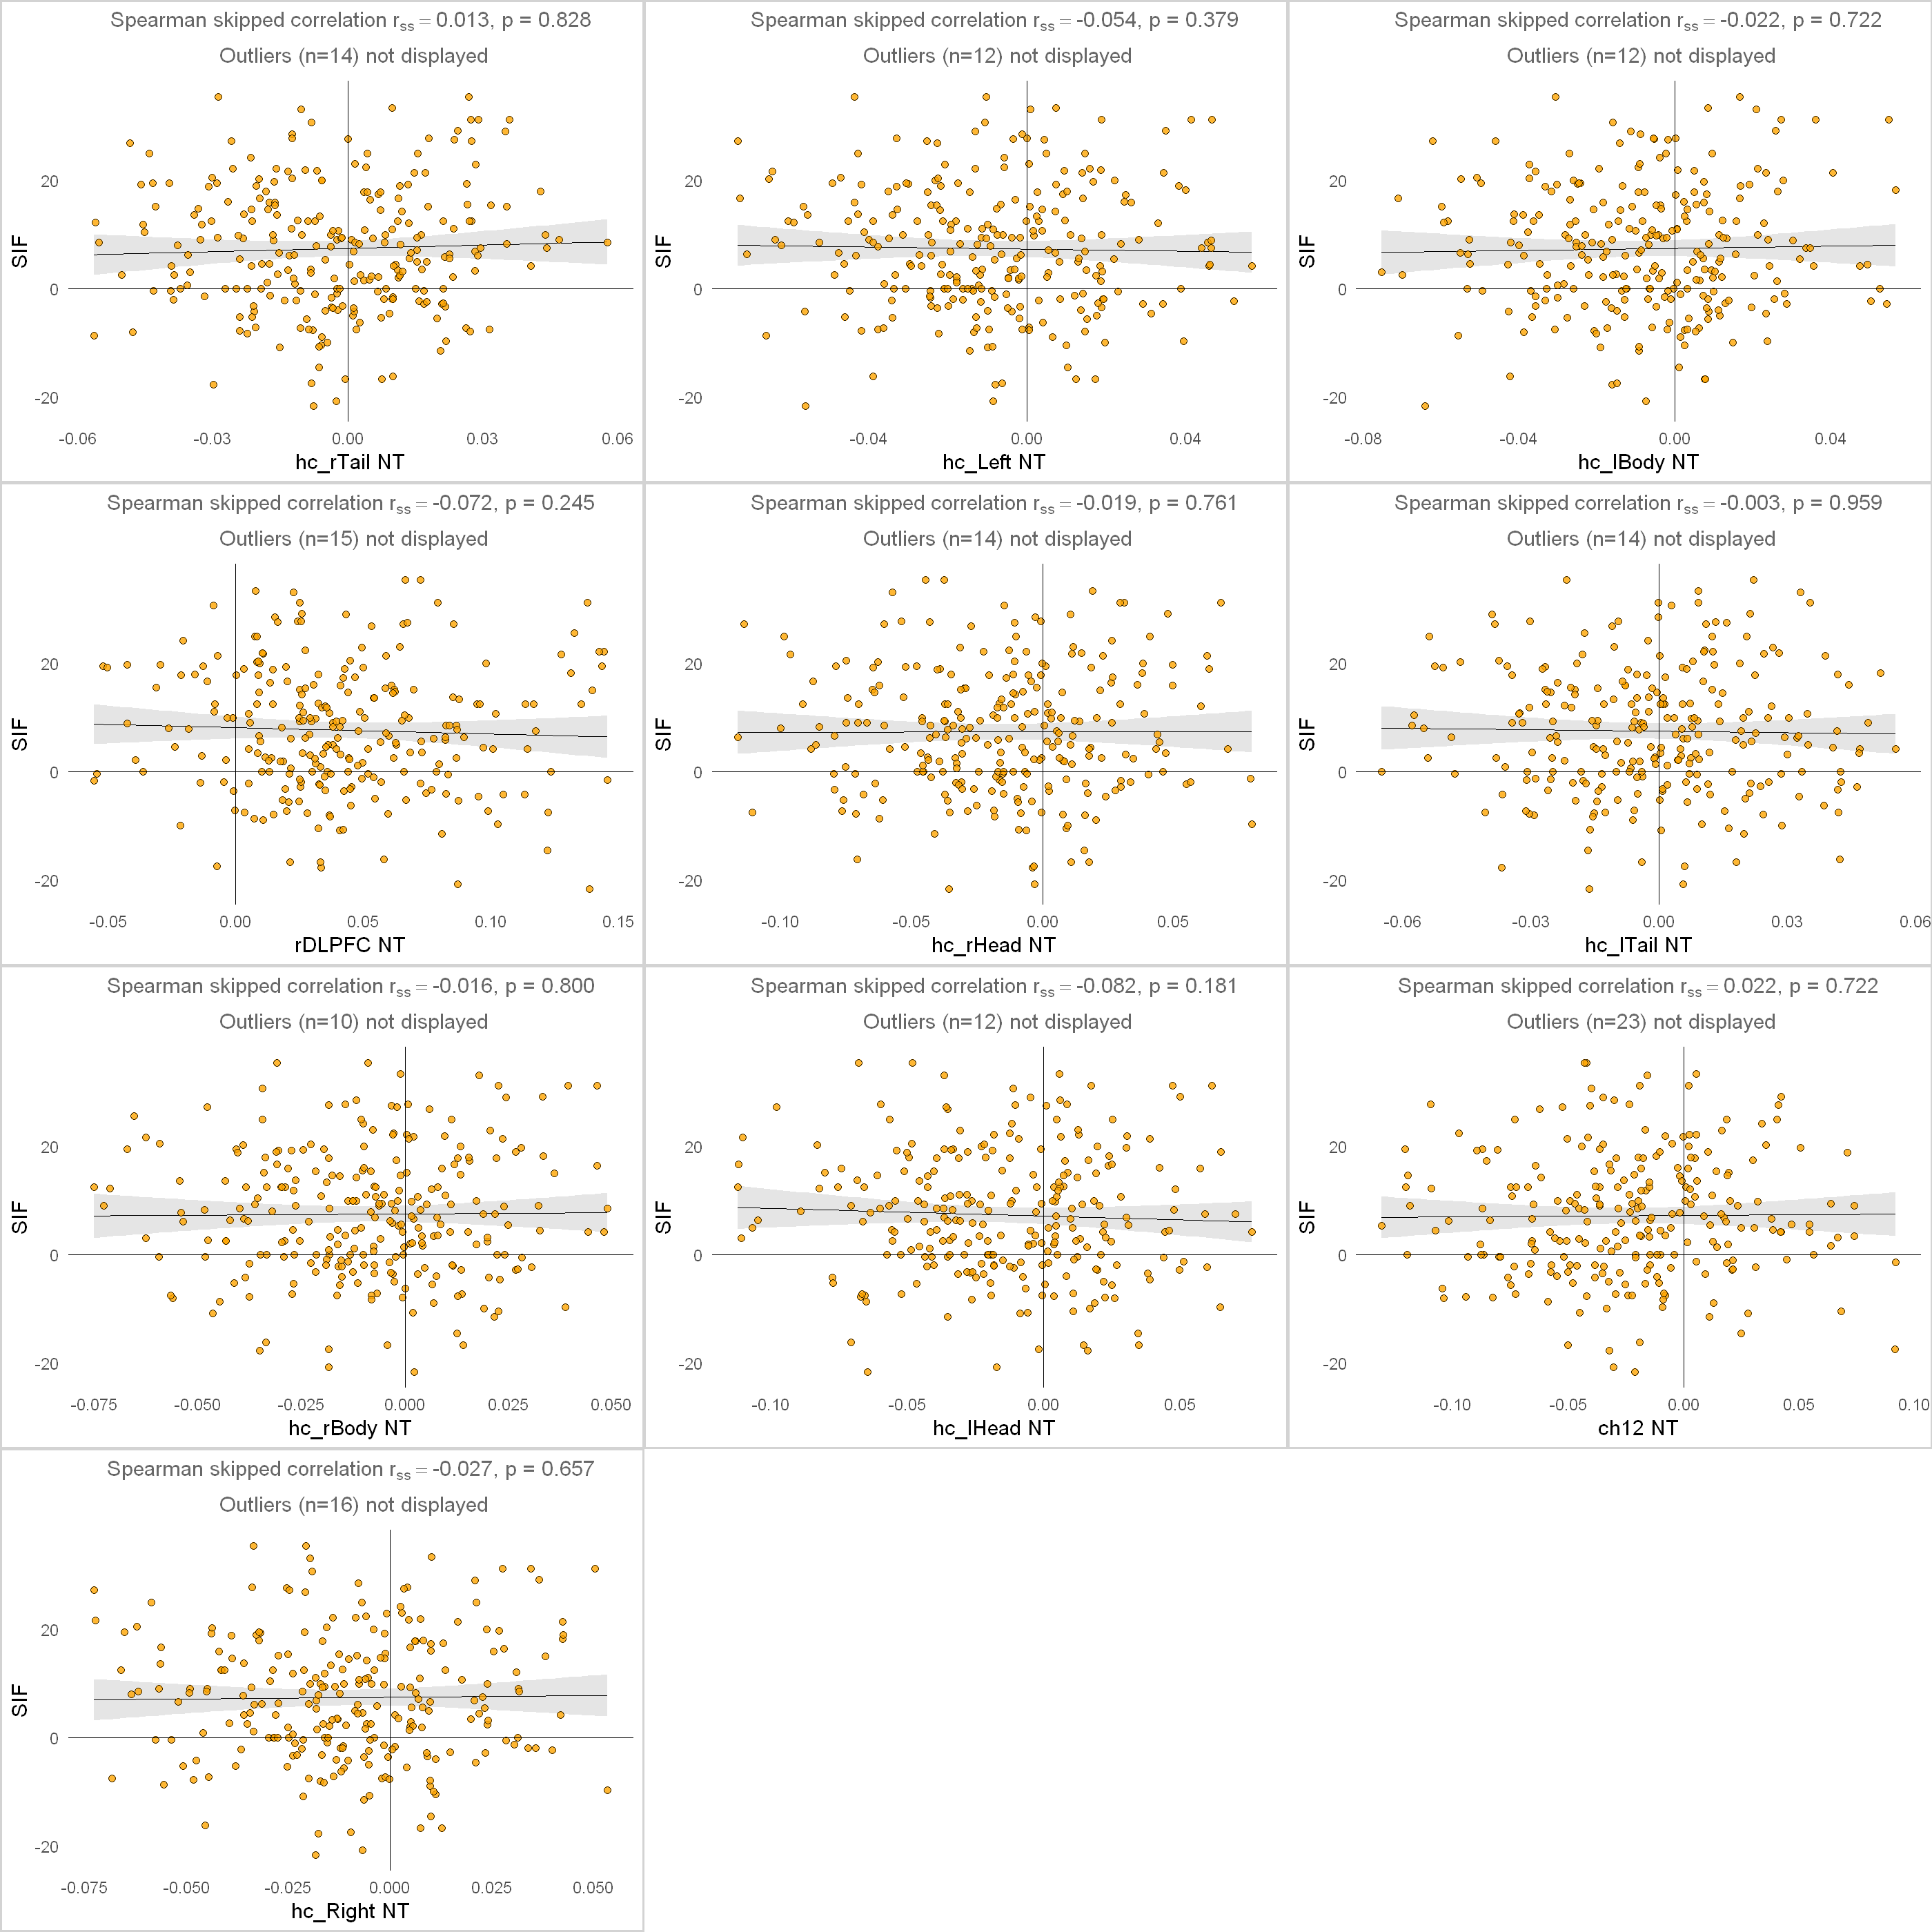

In [6]:
plot_per_roi(data_sif.psc, rois, "NT", "SIF")

## Think

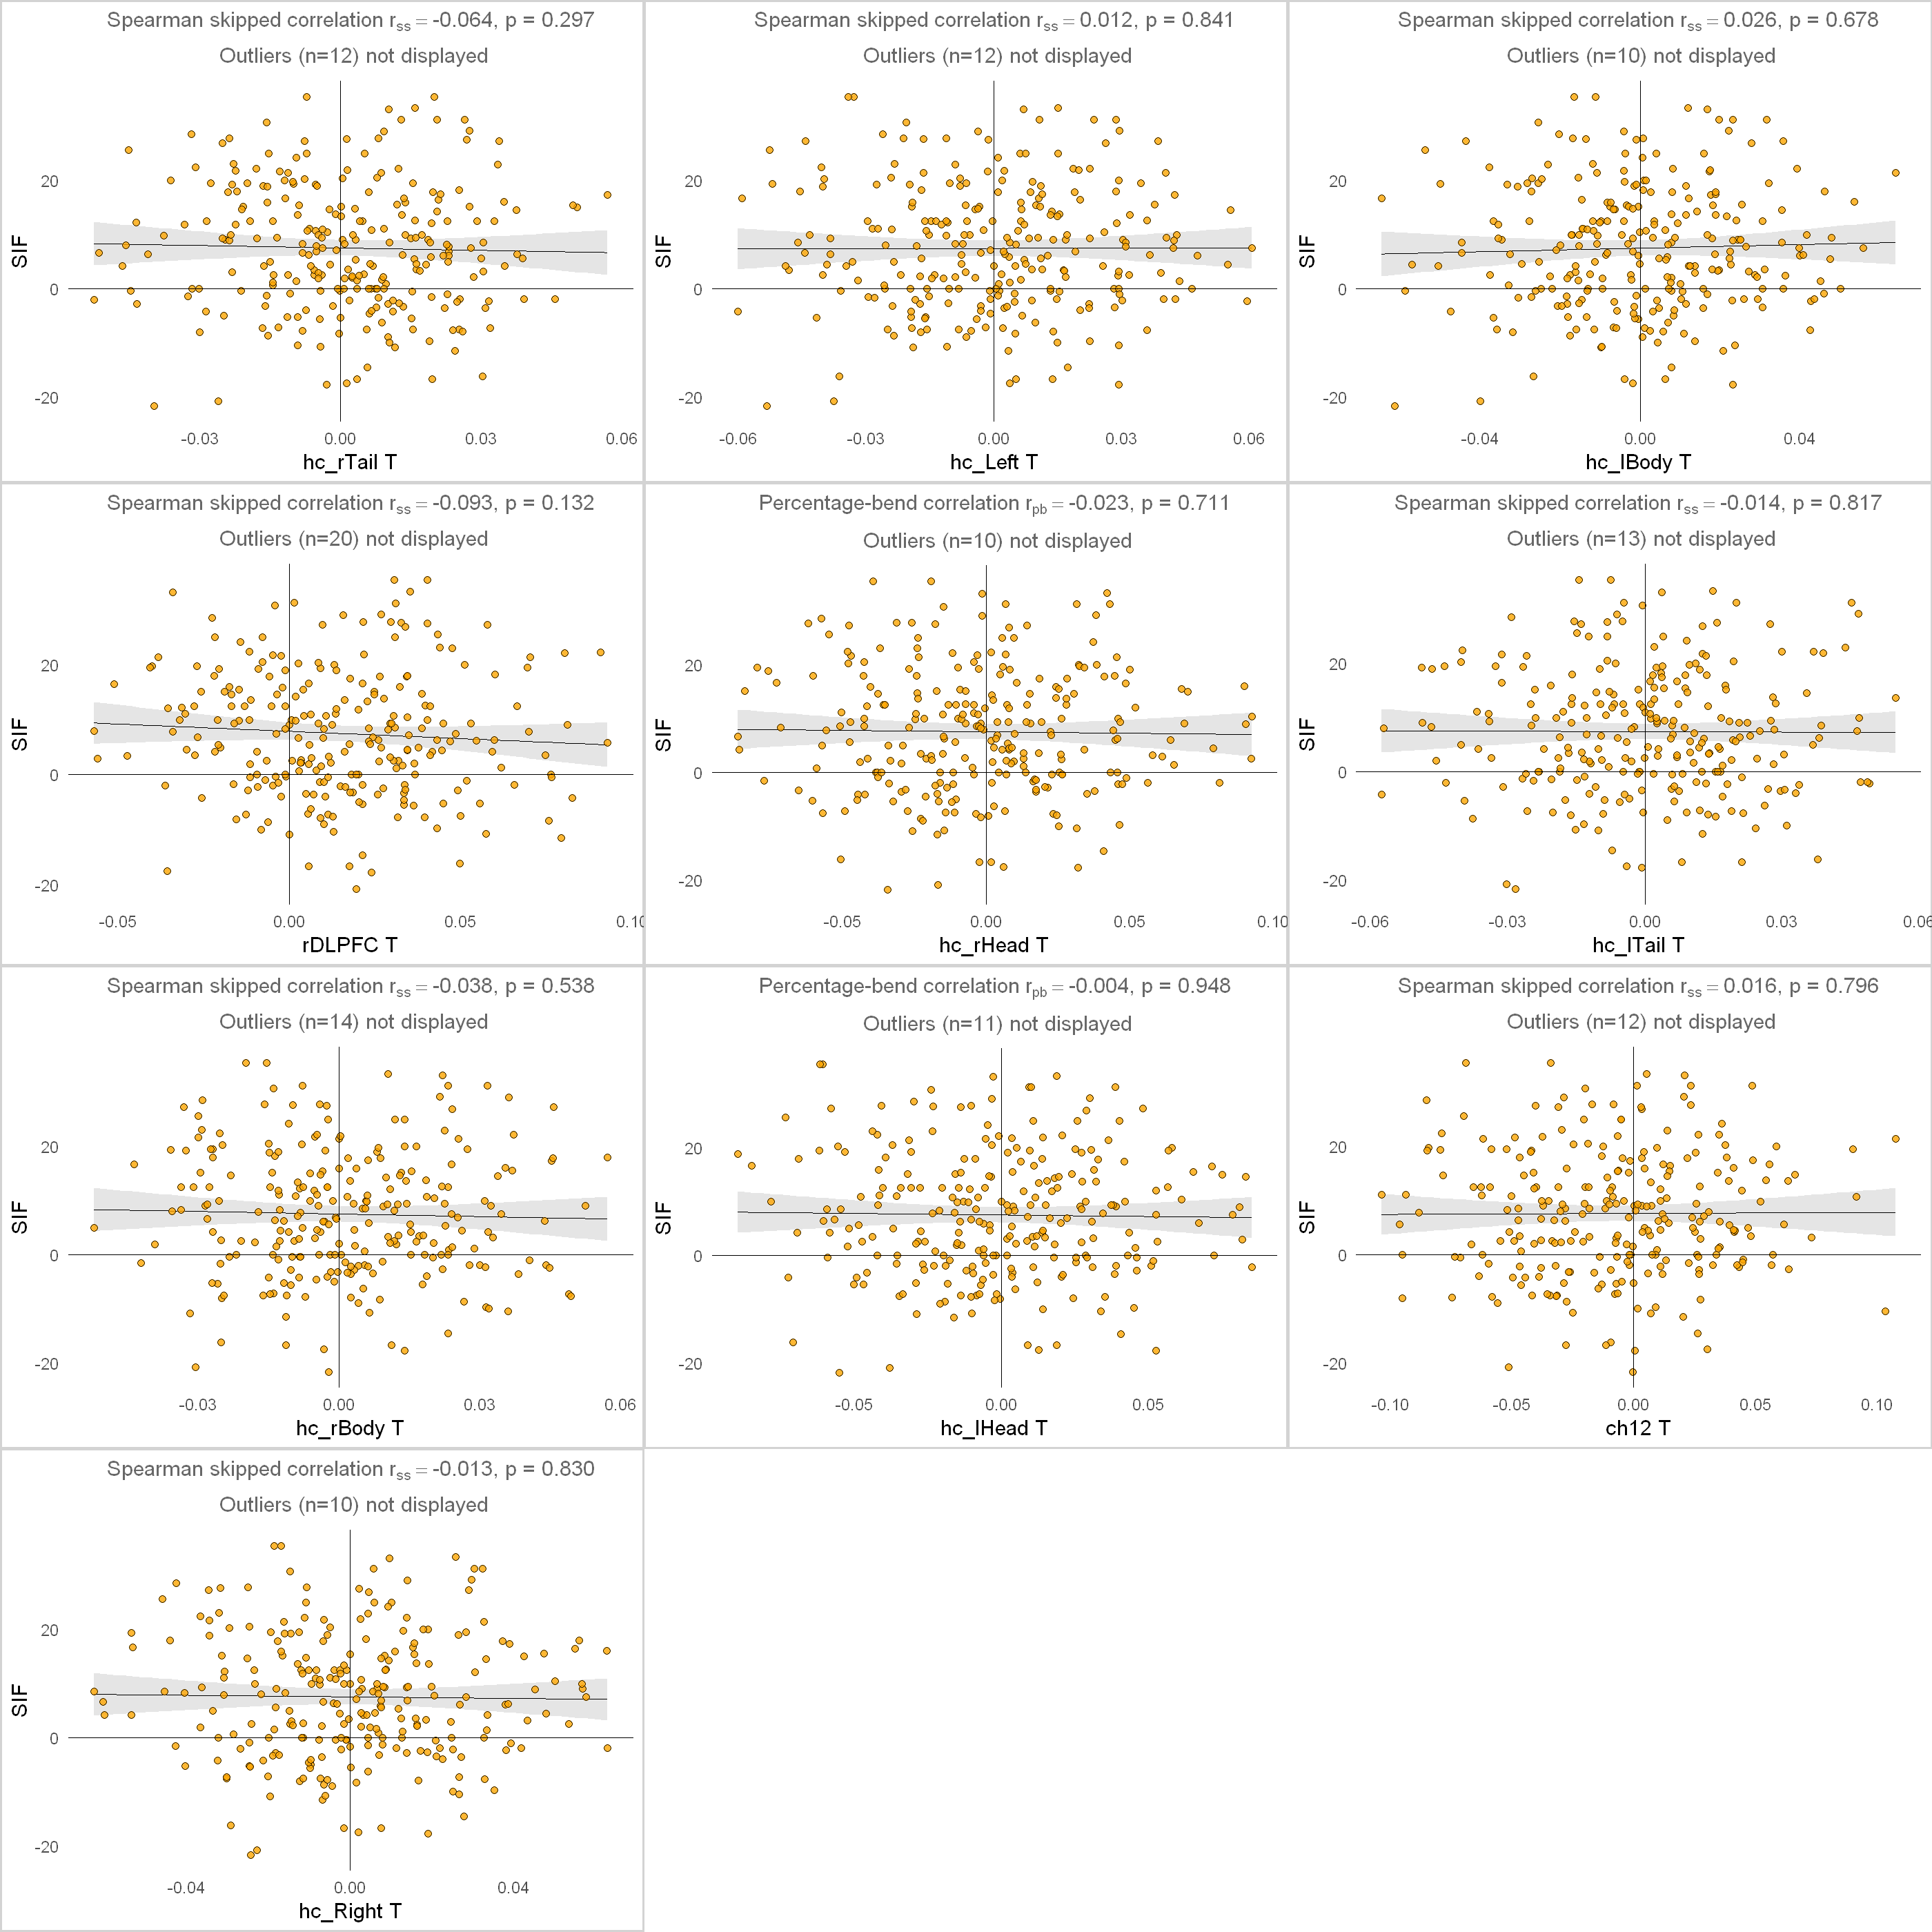

In [7]:
plot_per_roi(data_sif.psc, rois, "T", "SIF")

## Think - No-Think

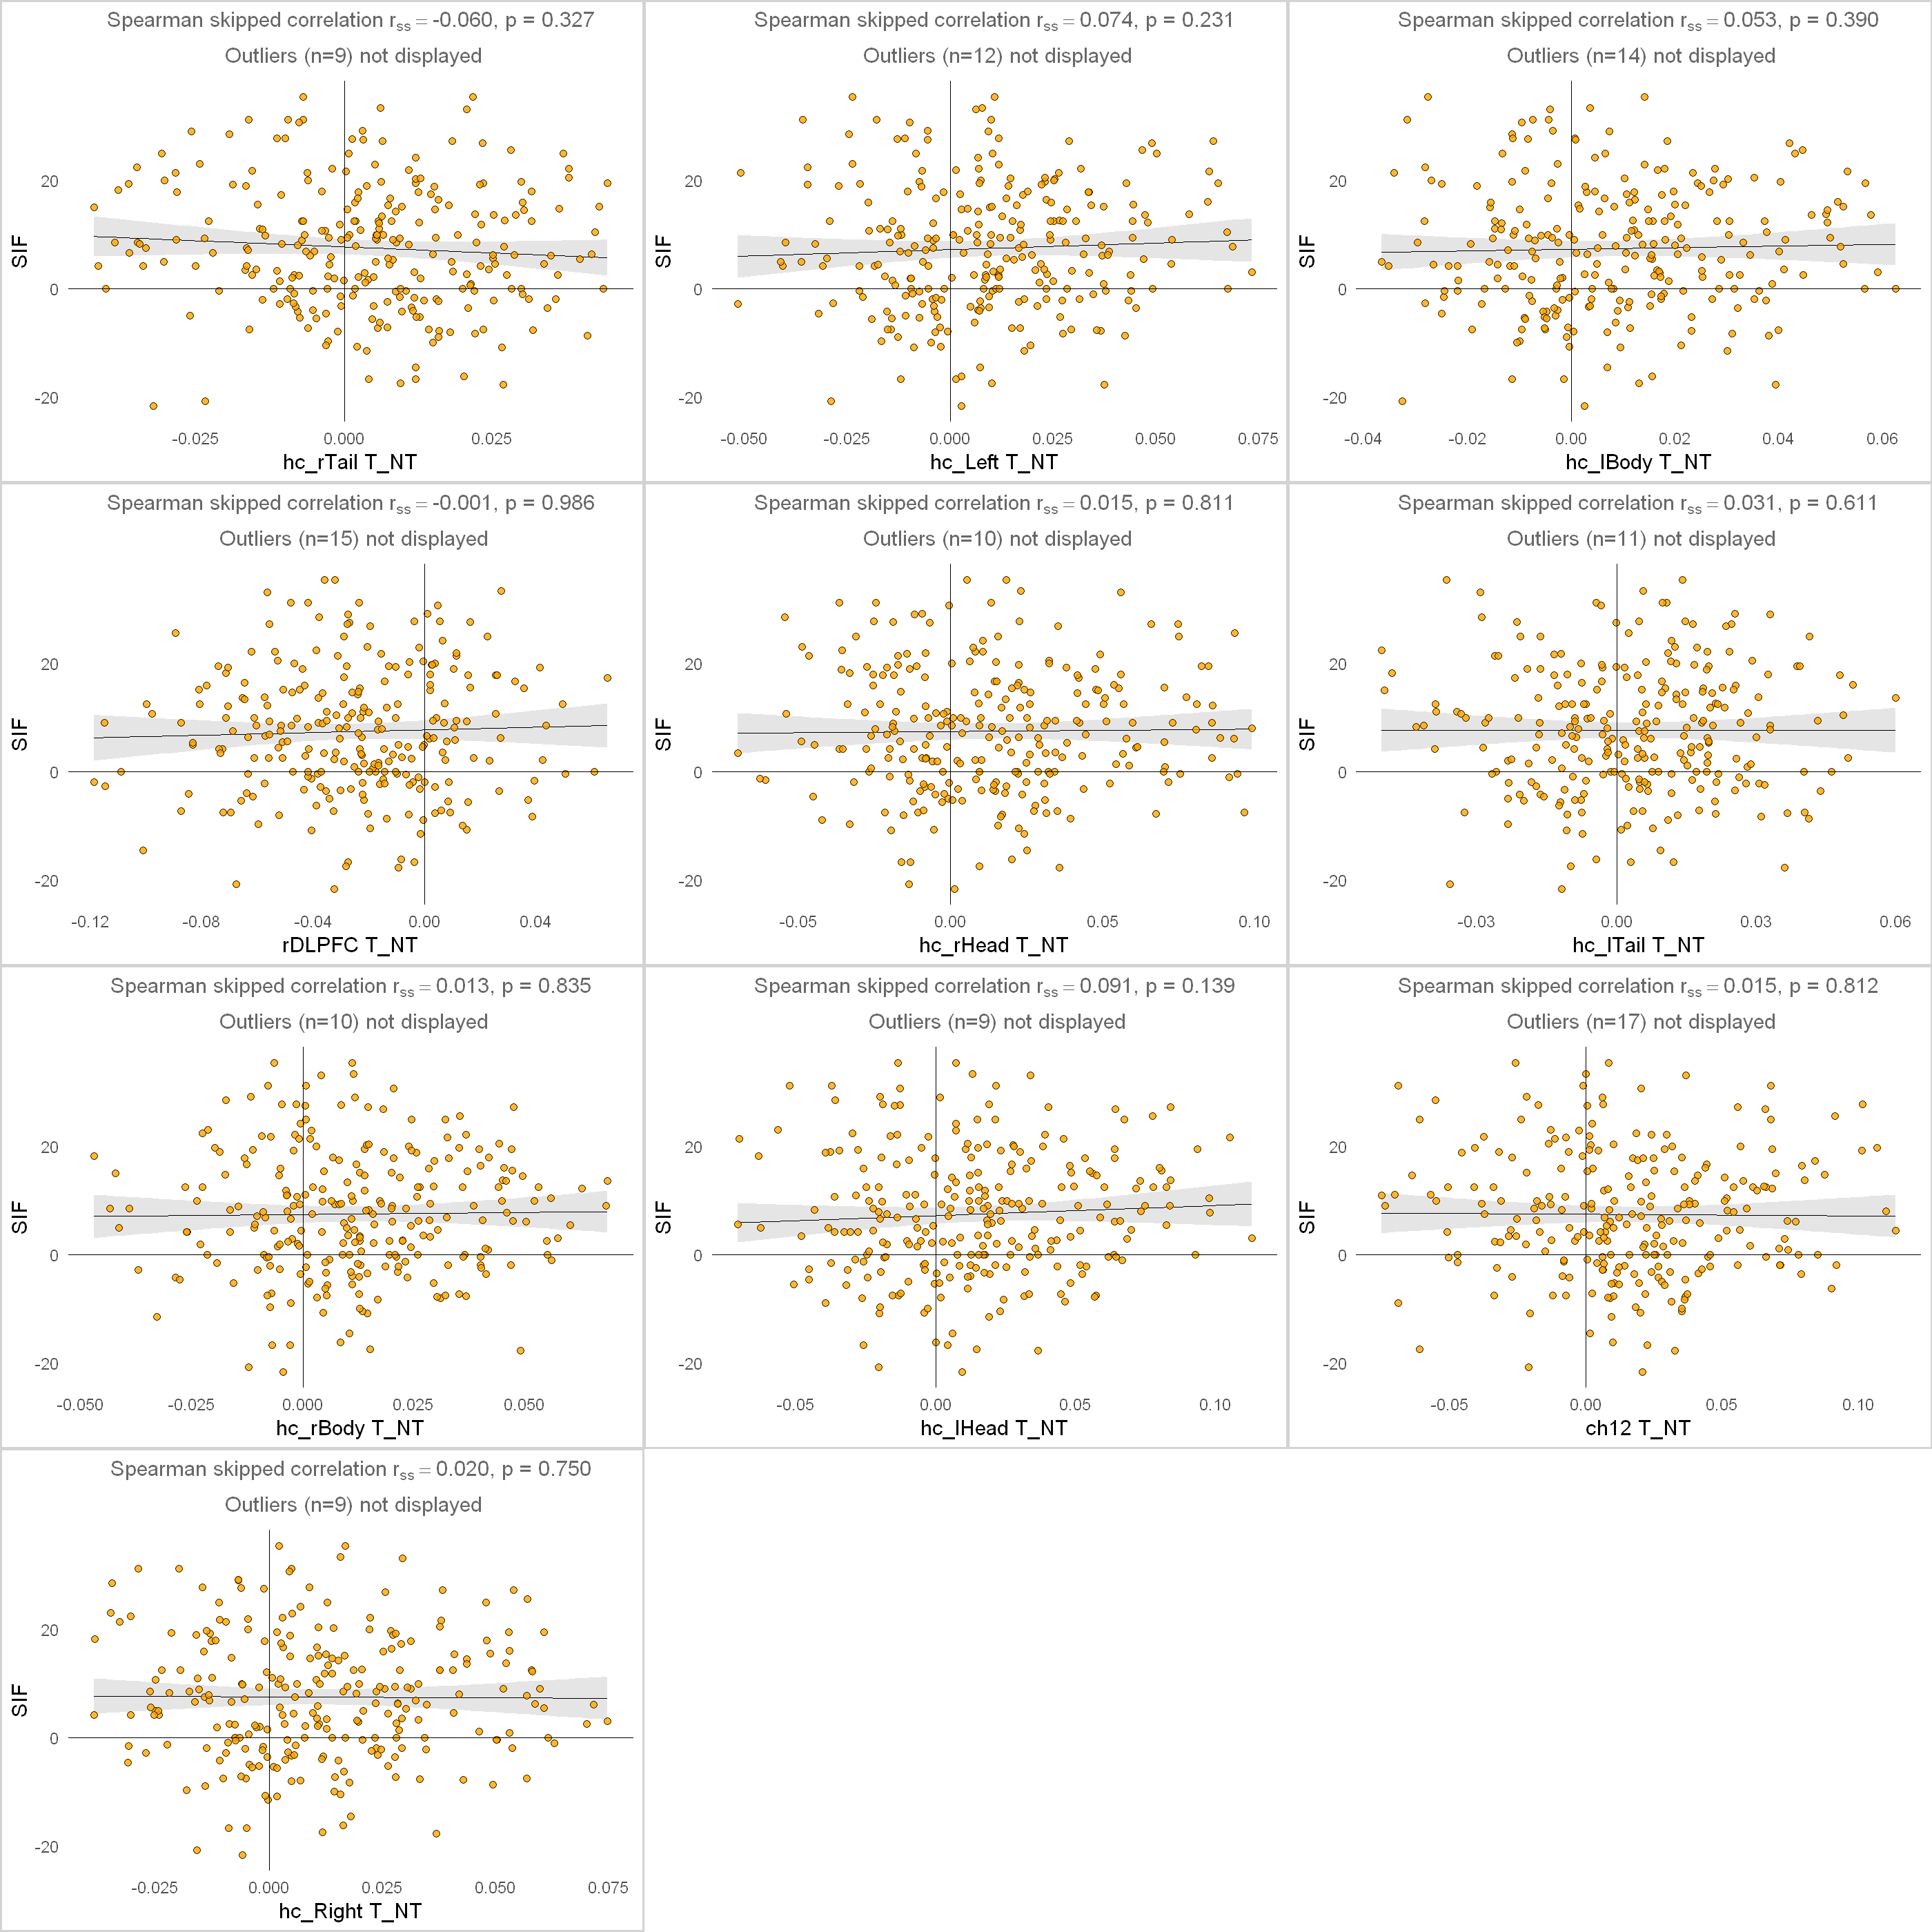

In [8]:
data_sif.psc$T_NT <- data_sif.psc$T-data_sif.psc$NT
plot_per_roi(data_sif.psc, rois, "T_NT", "SIF")

# PSC/SIF correlations per dataset and per ROI

In [9]:
# Get a list of all datasets
datasets <- unique(data_sif.psc$stid)
datasets
length(datasets)

[1] 01_Levy1        02_Levy2        05_Yuhua        06_RolandNeuron
[5] 08_Taylor       09_Xu           10_Big-TNT     
10 Levels: 01_Levy1 02_Levy2 03_RolandJoCN 04_PierreJoN ... 10_Big-TNT

[1] 7

## No-Think

[1] "01_Levy1"

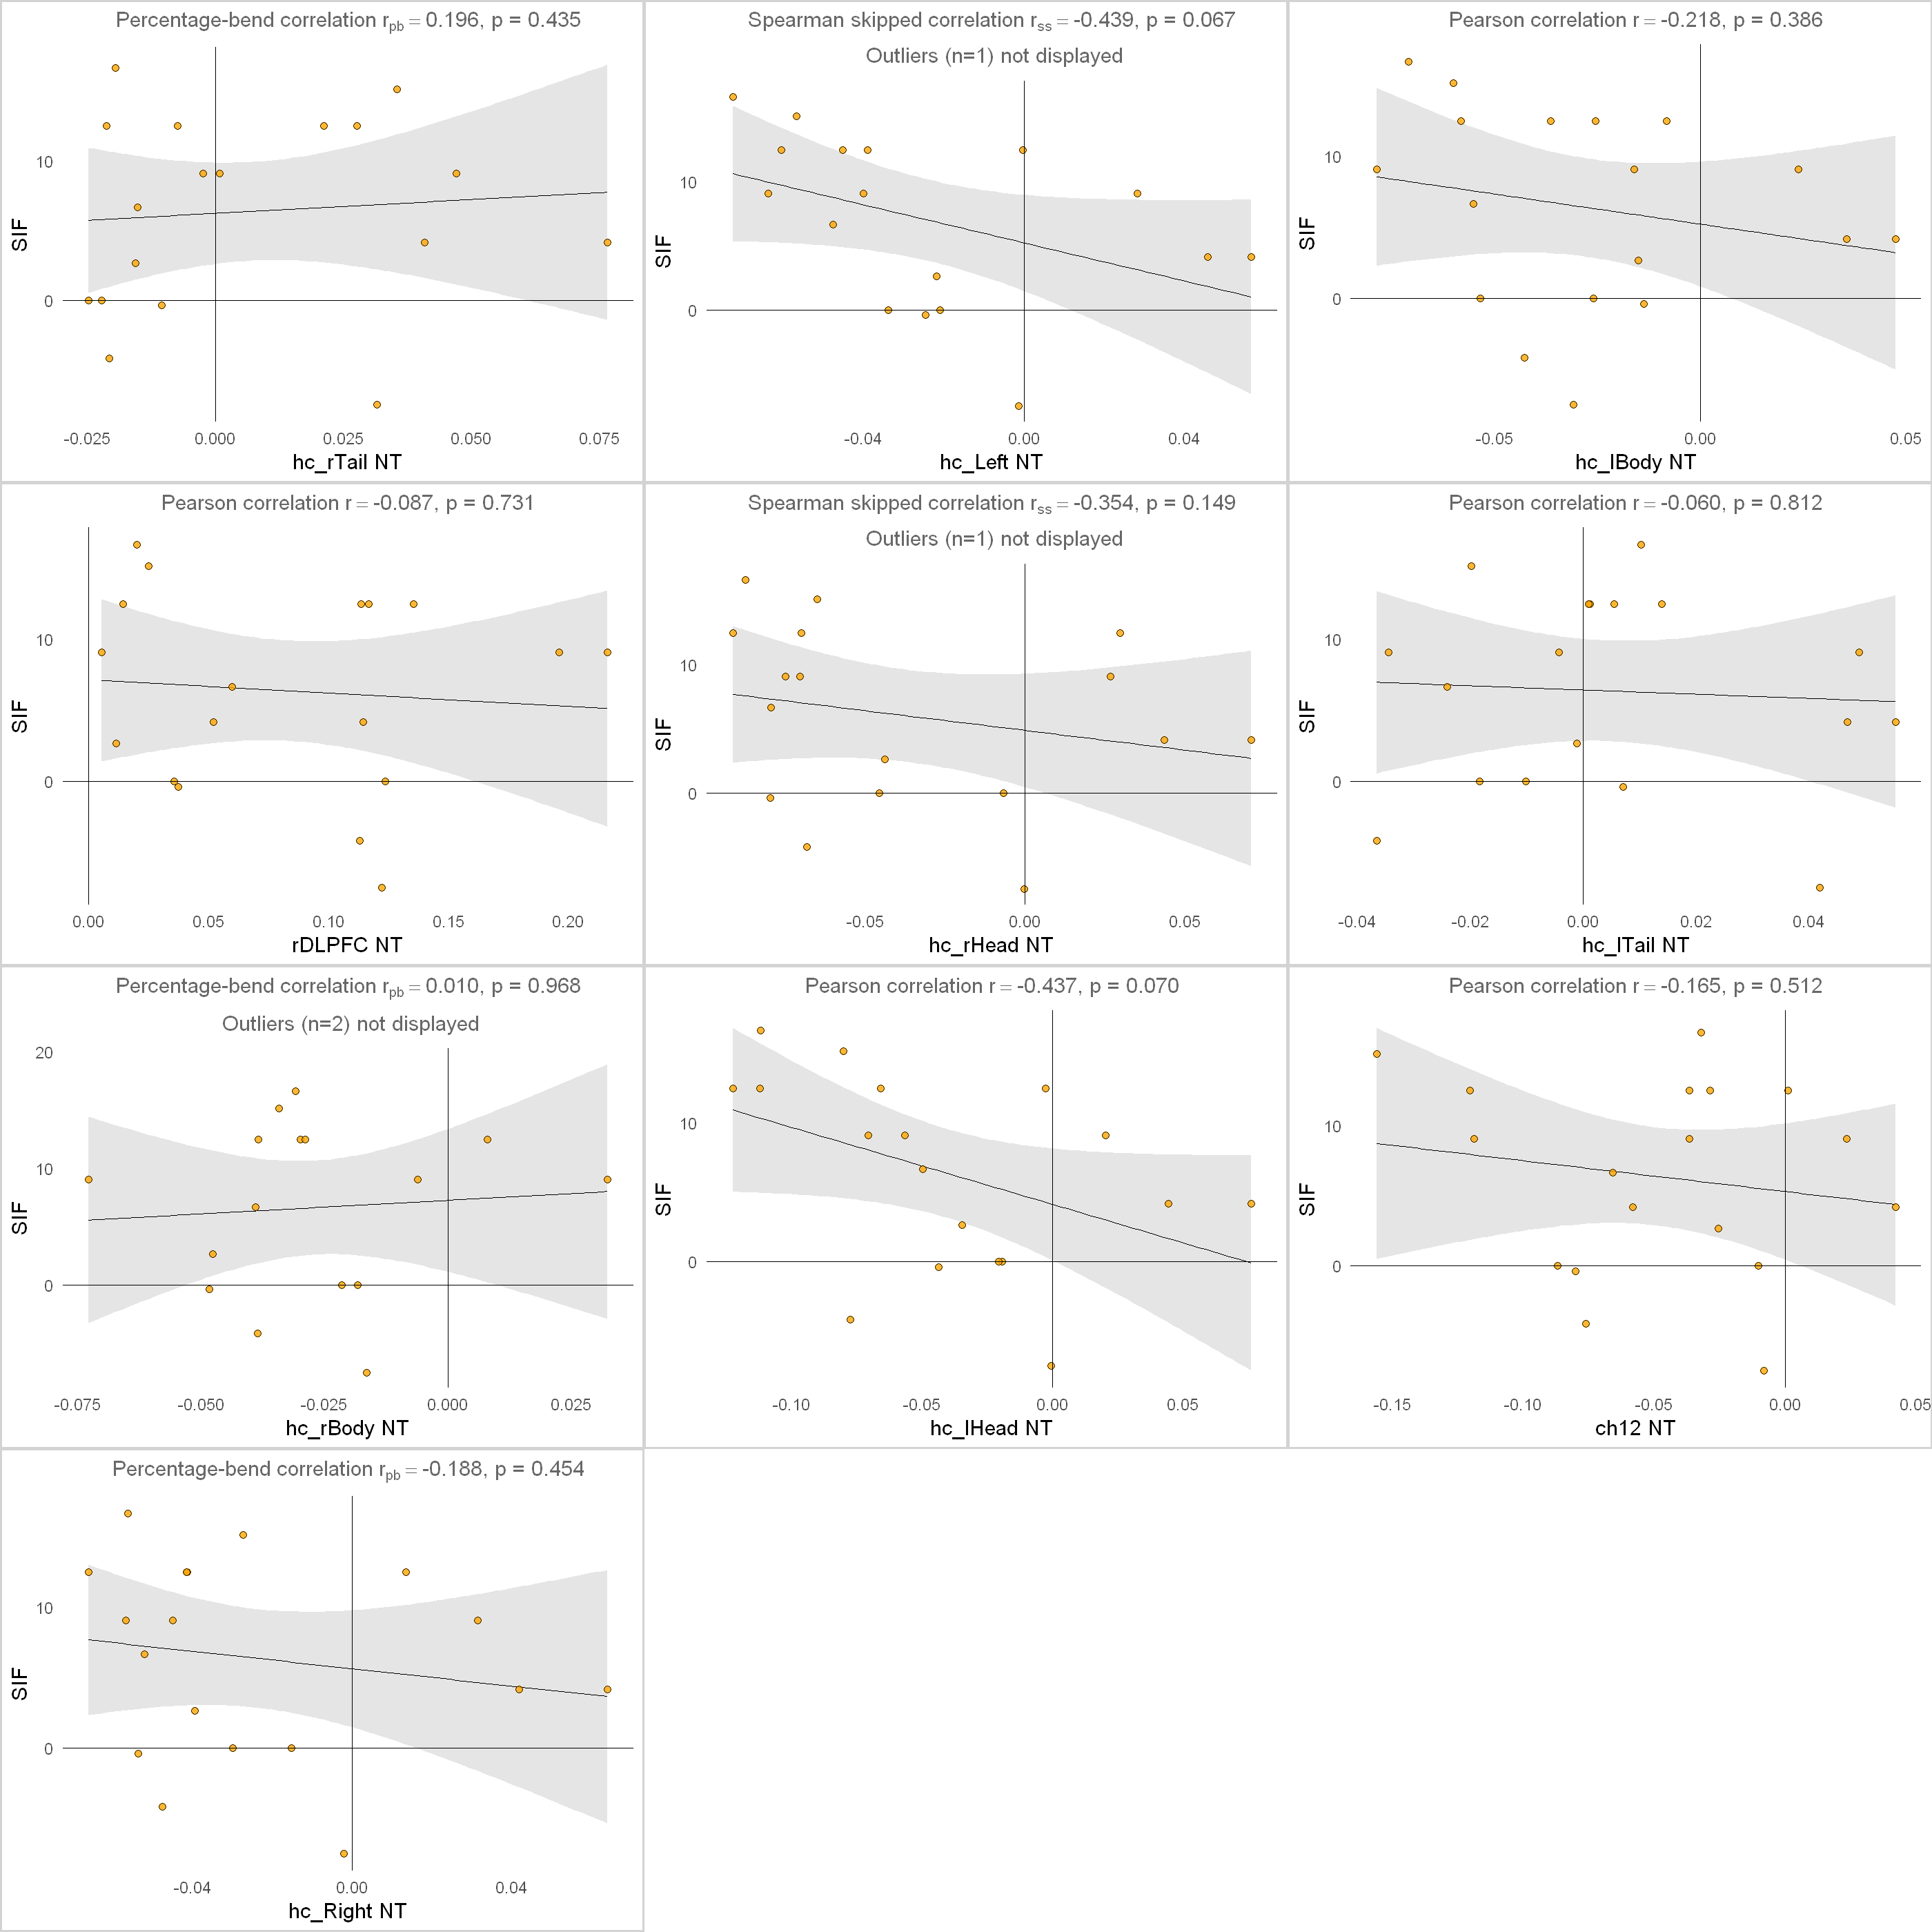

In [10]:
ds <- datasets[1]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "02_Levy2"

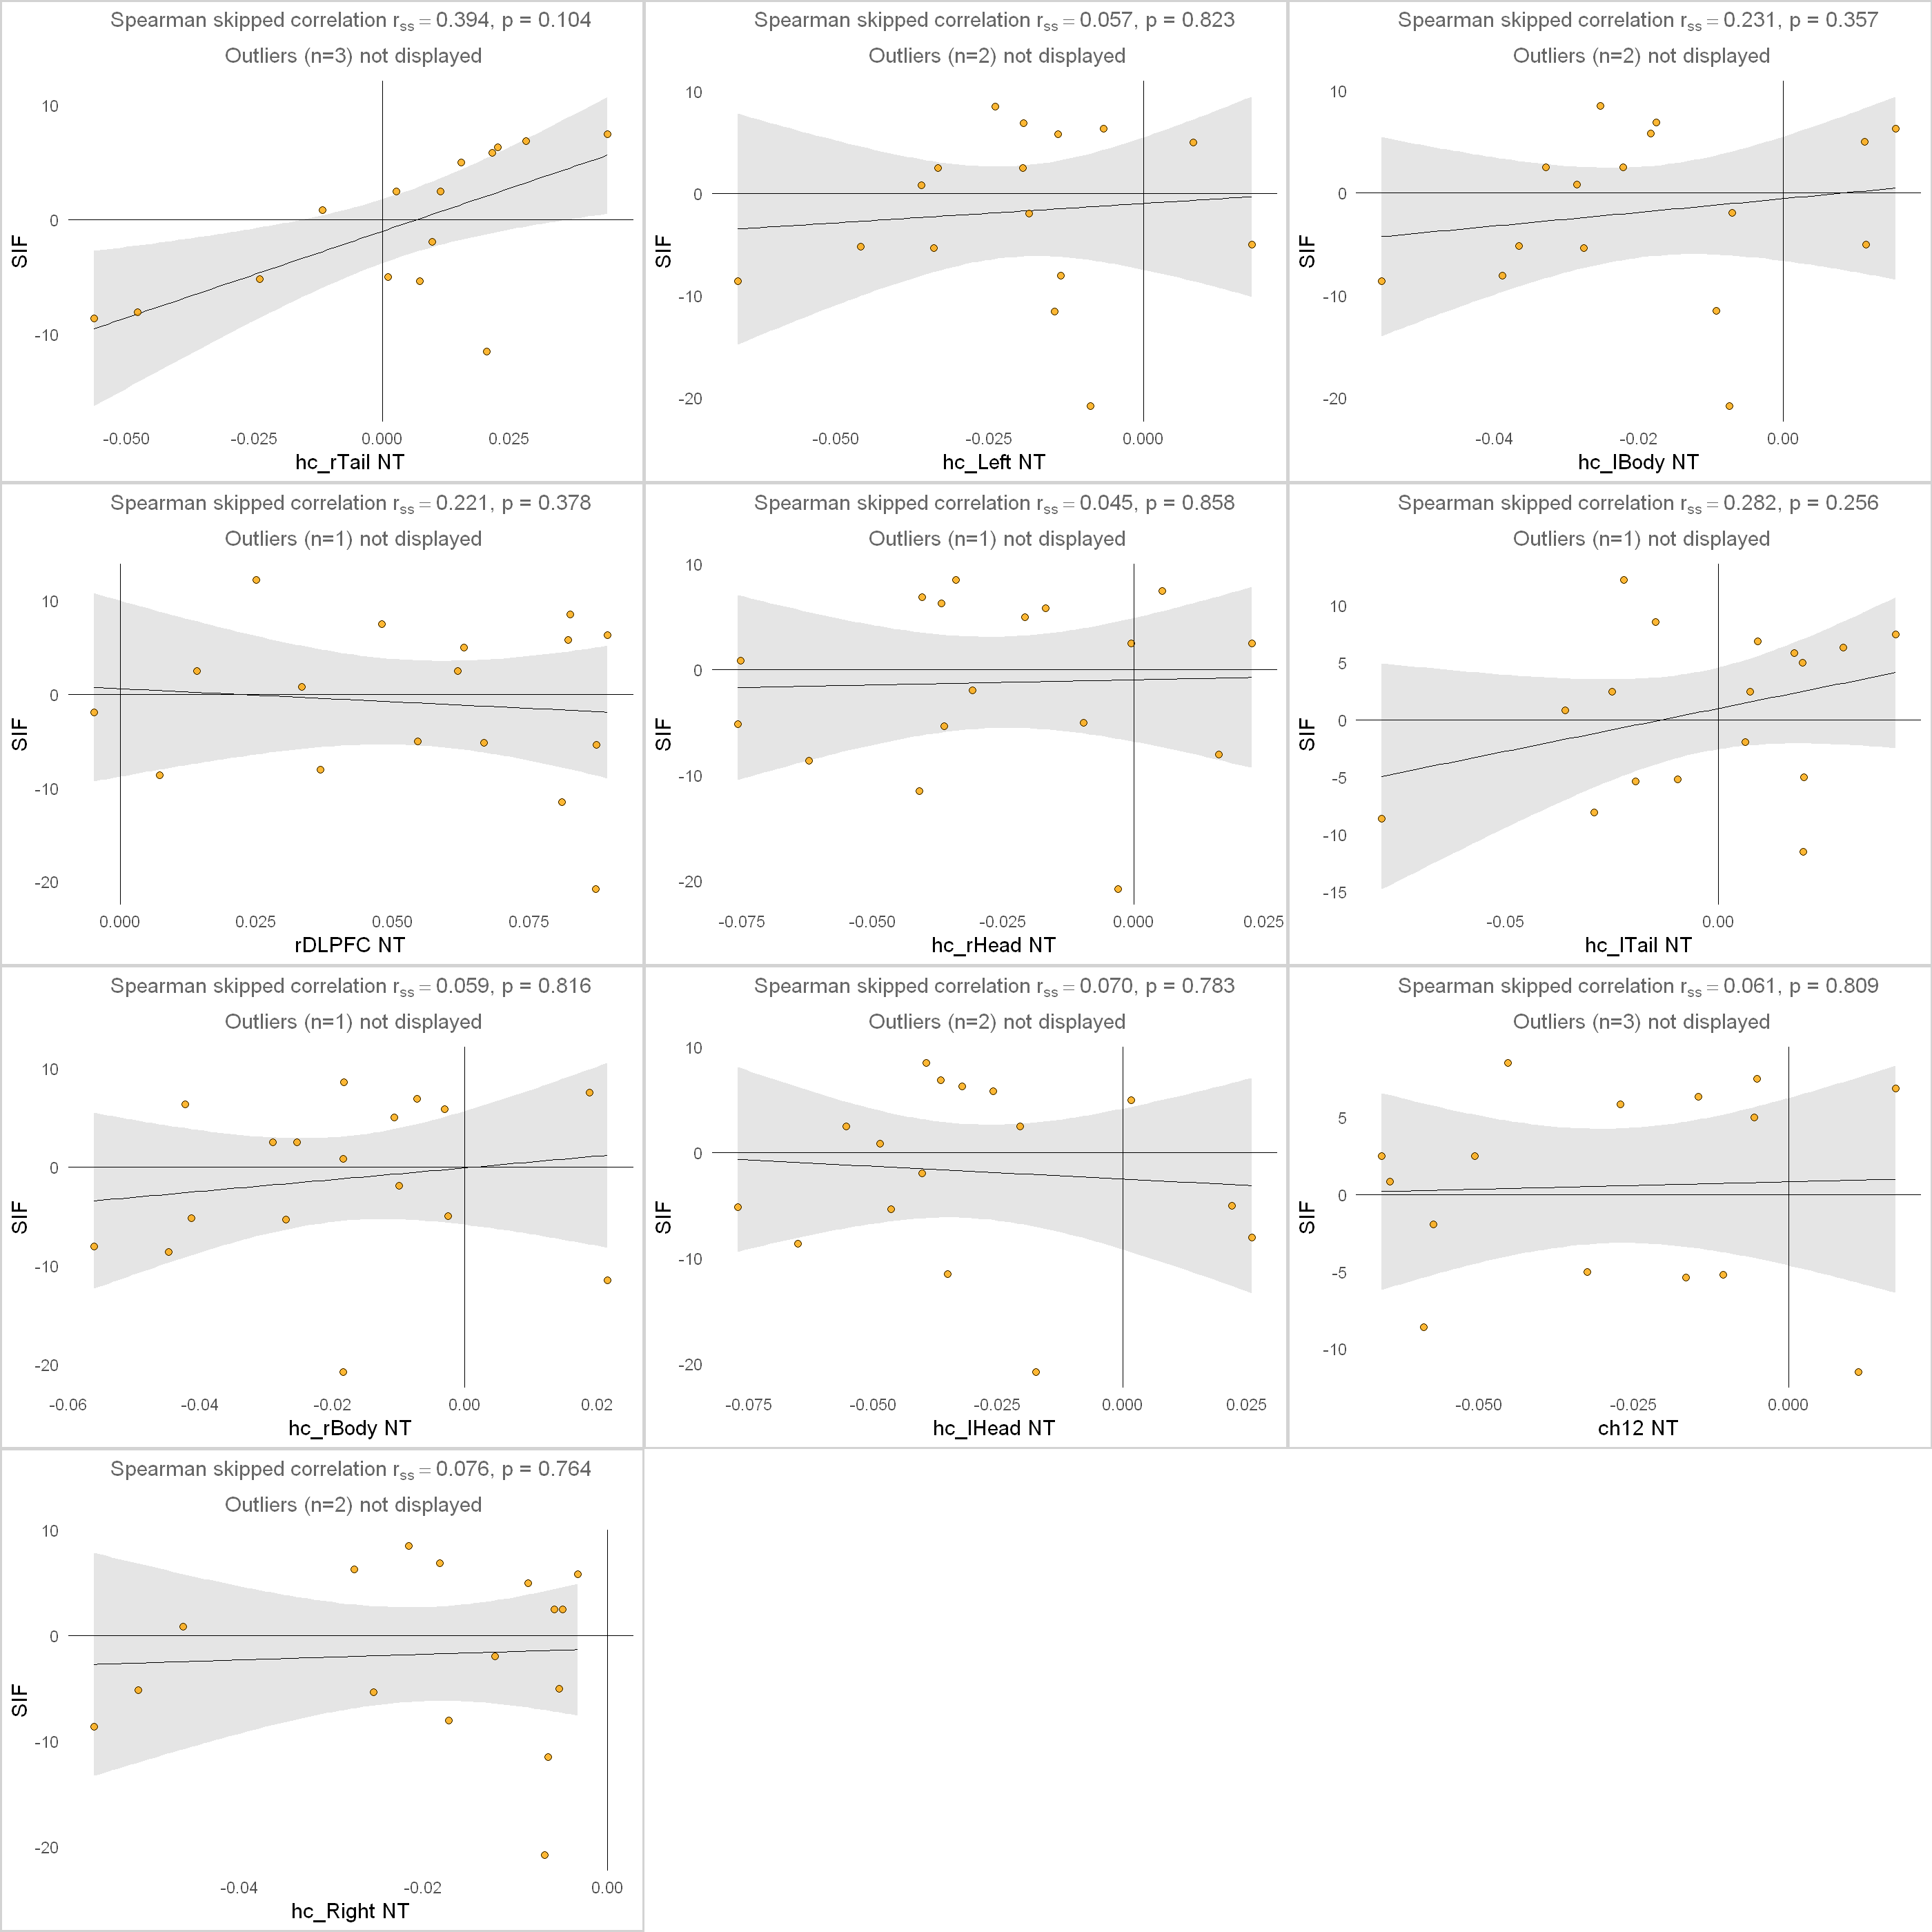

In [11]:
ds <- datasets[2]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "05_Yuhua"

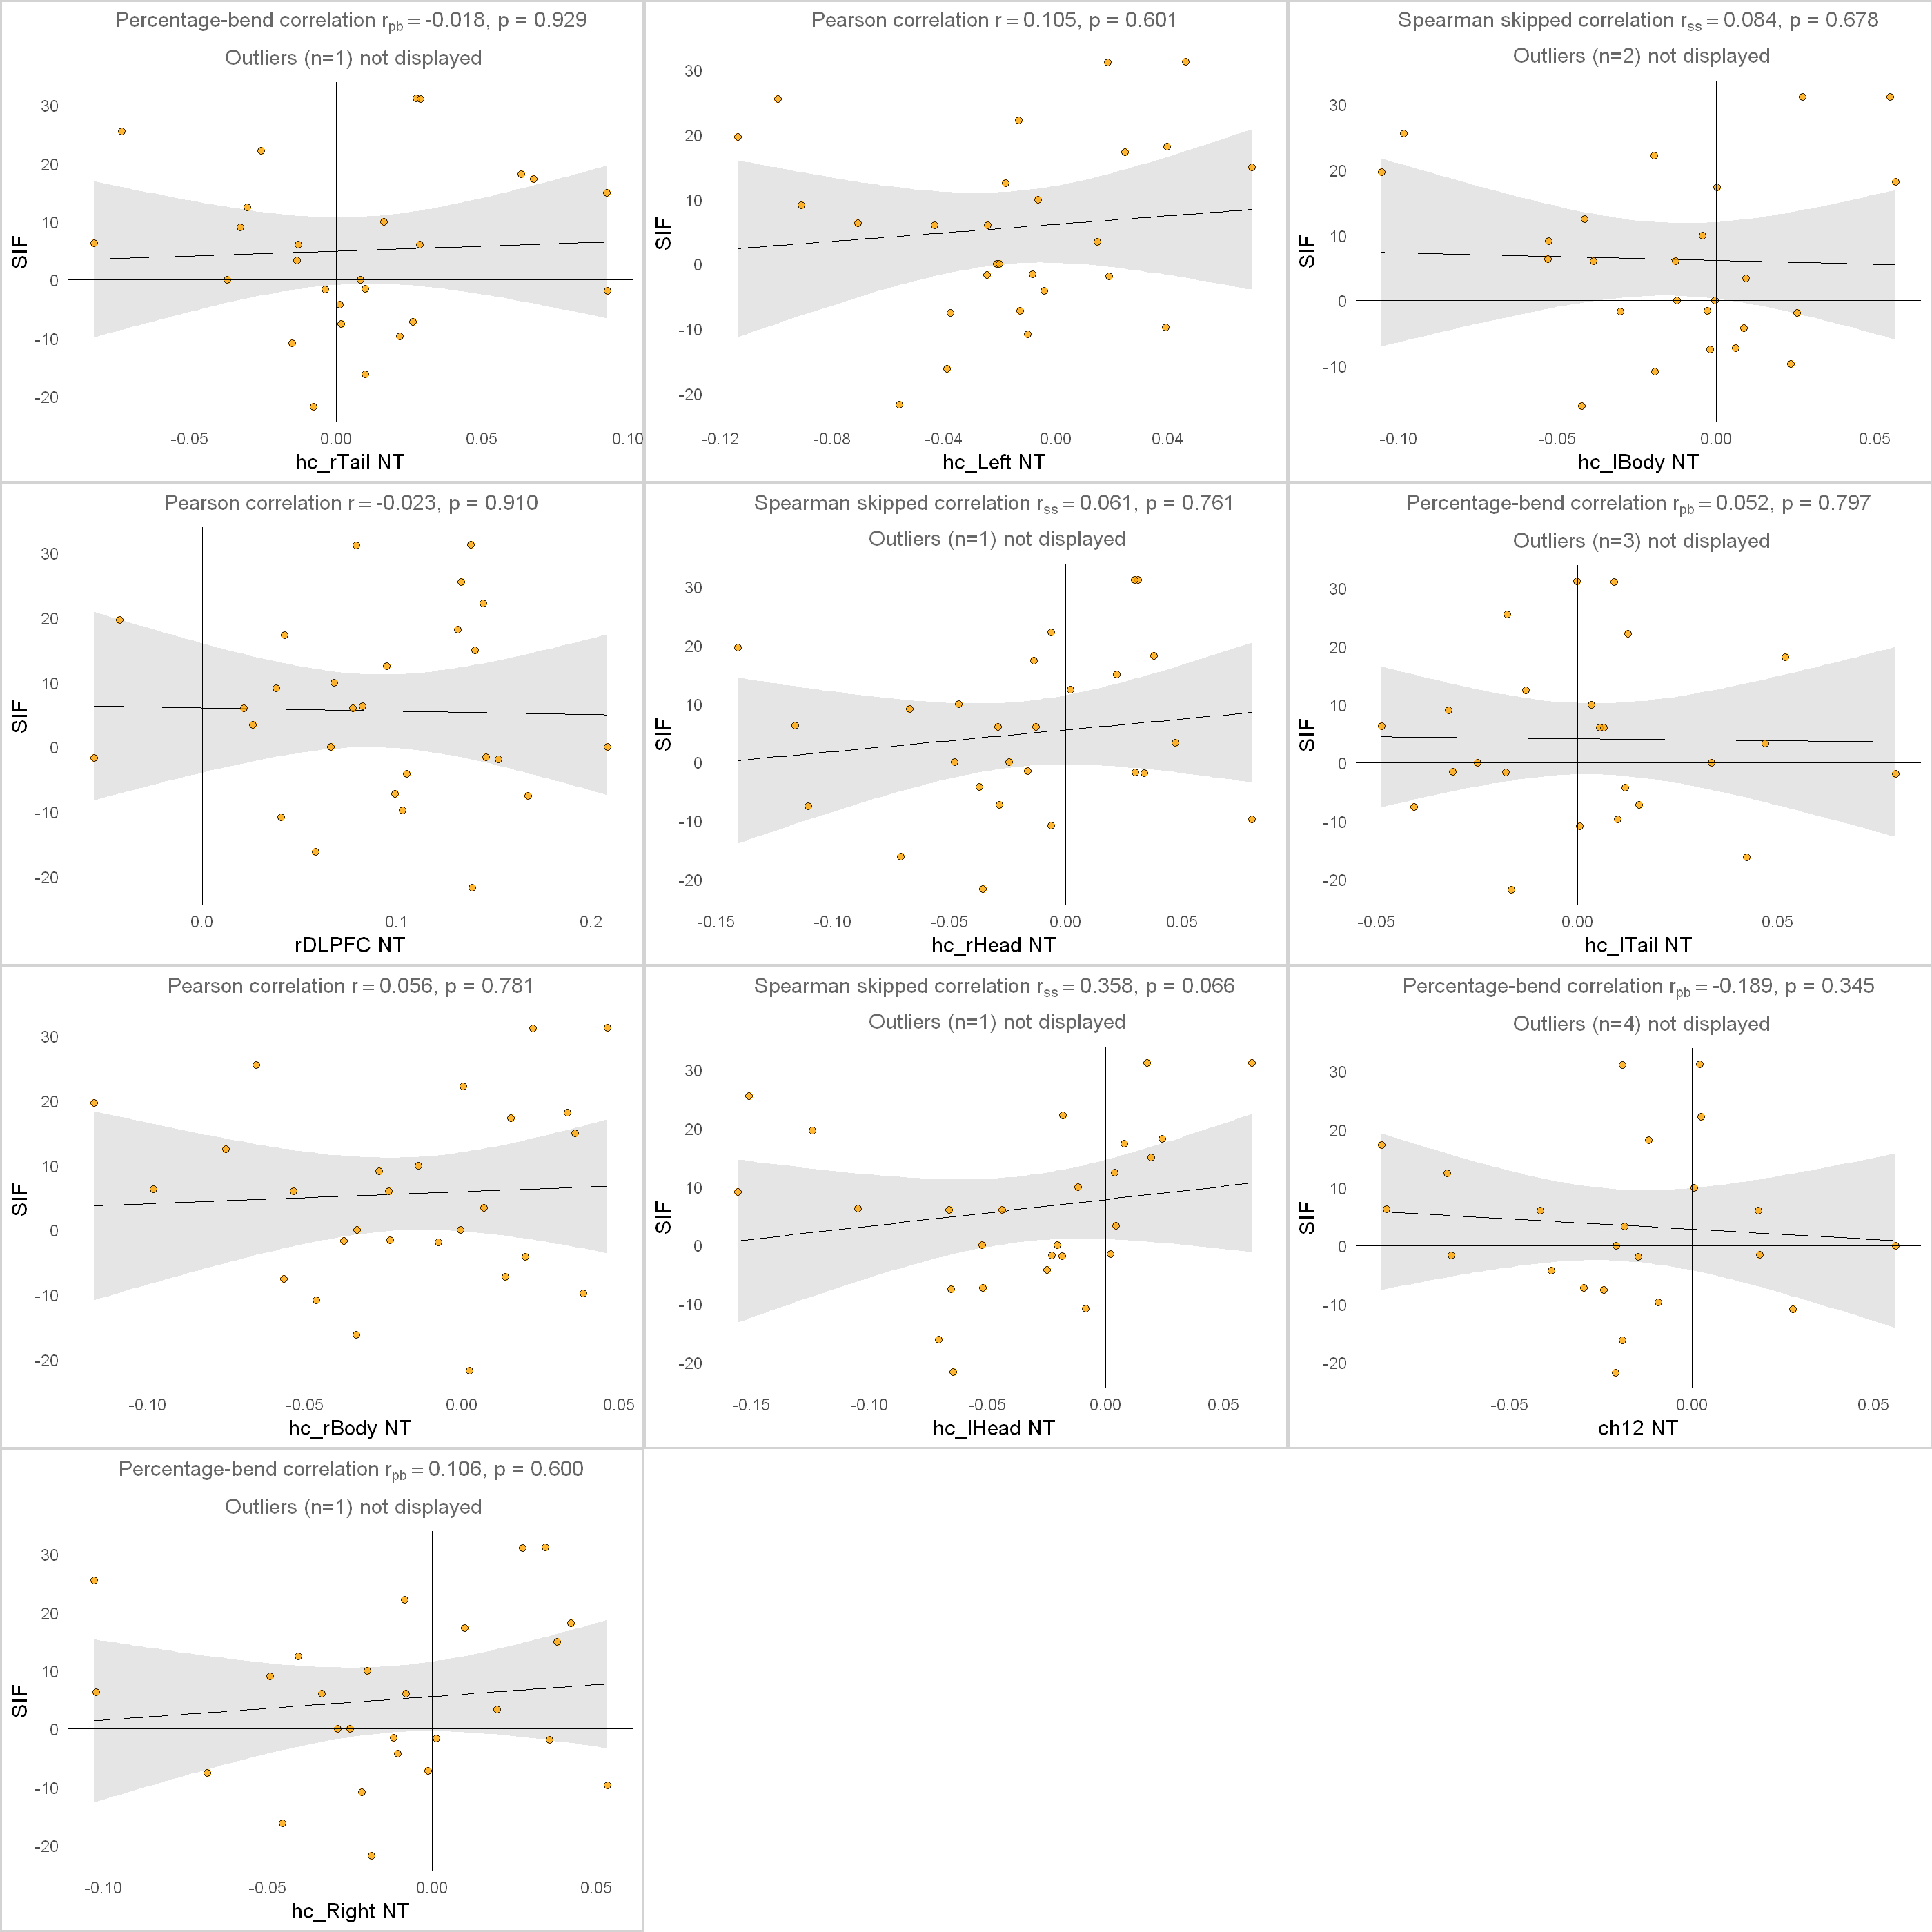

In [12]:
ds <- datasets[3]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "06_RolandNeuron"

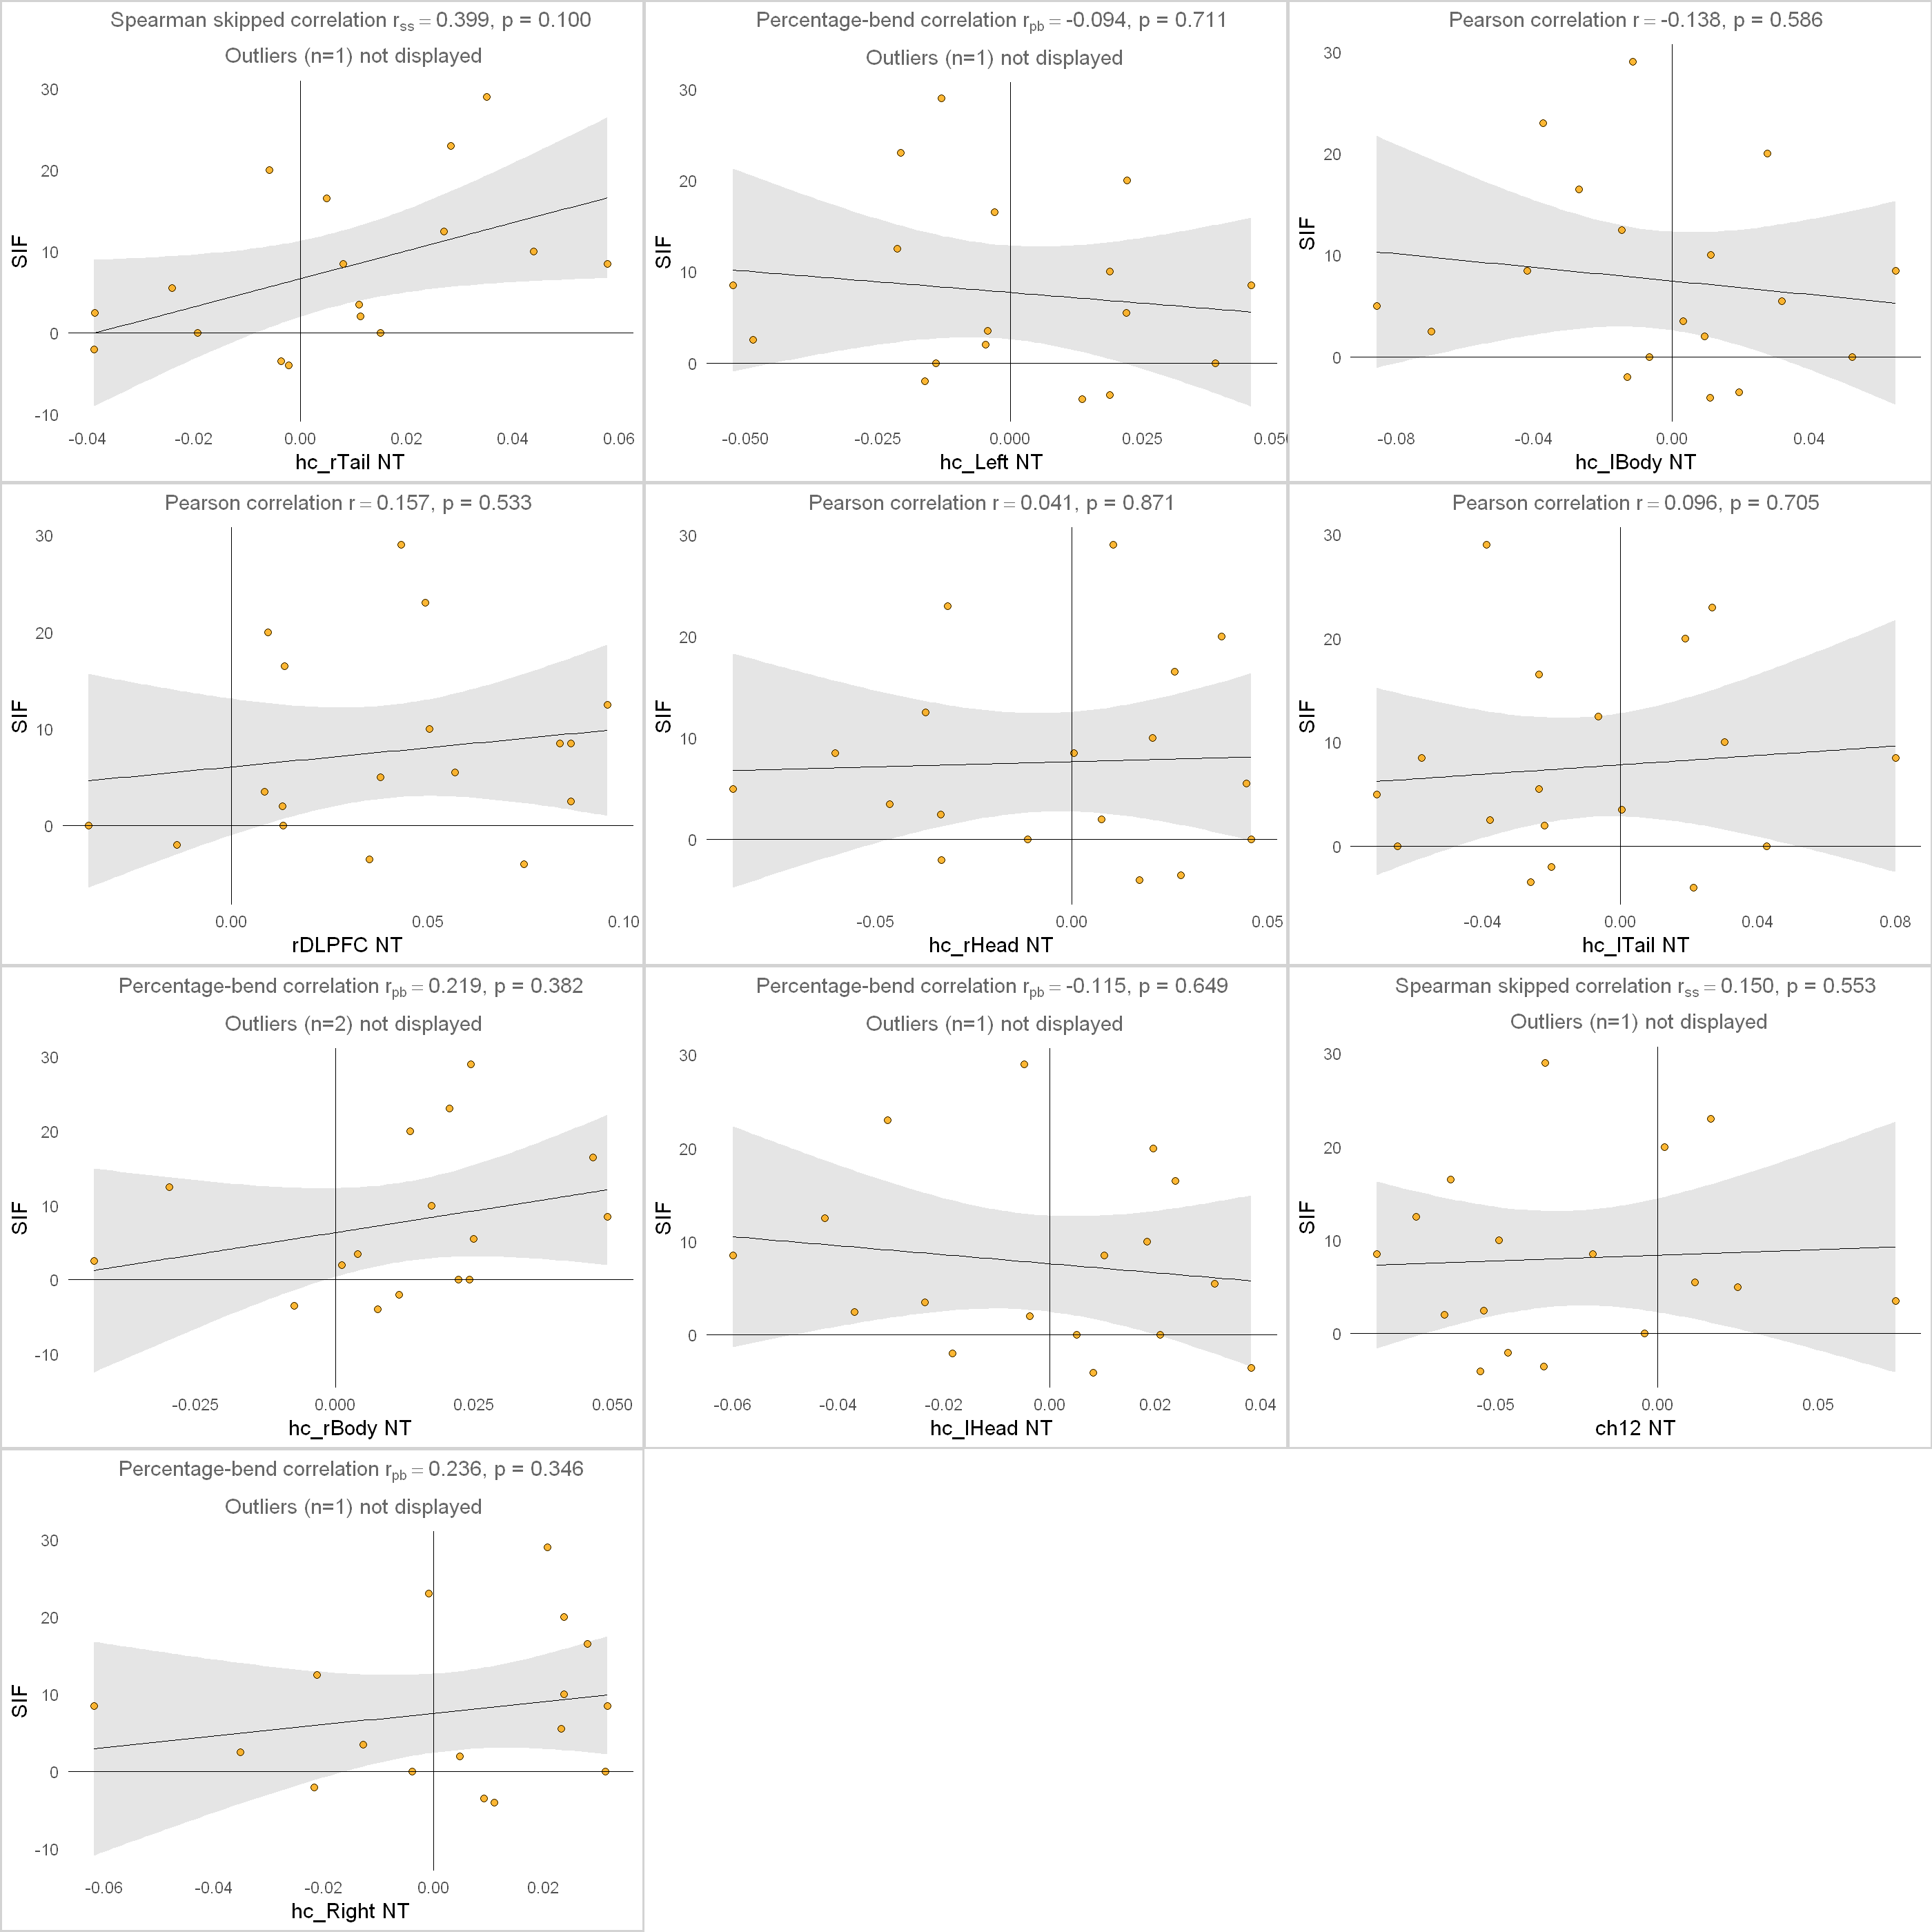

In [13]:
ds <- datasets[4]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "08_Taylor"

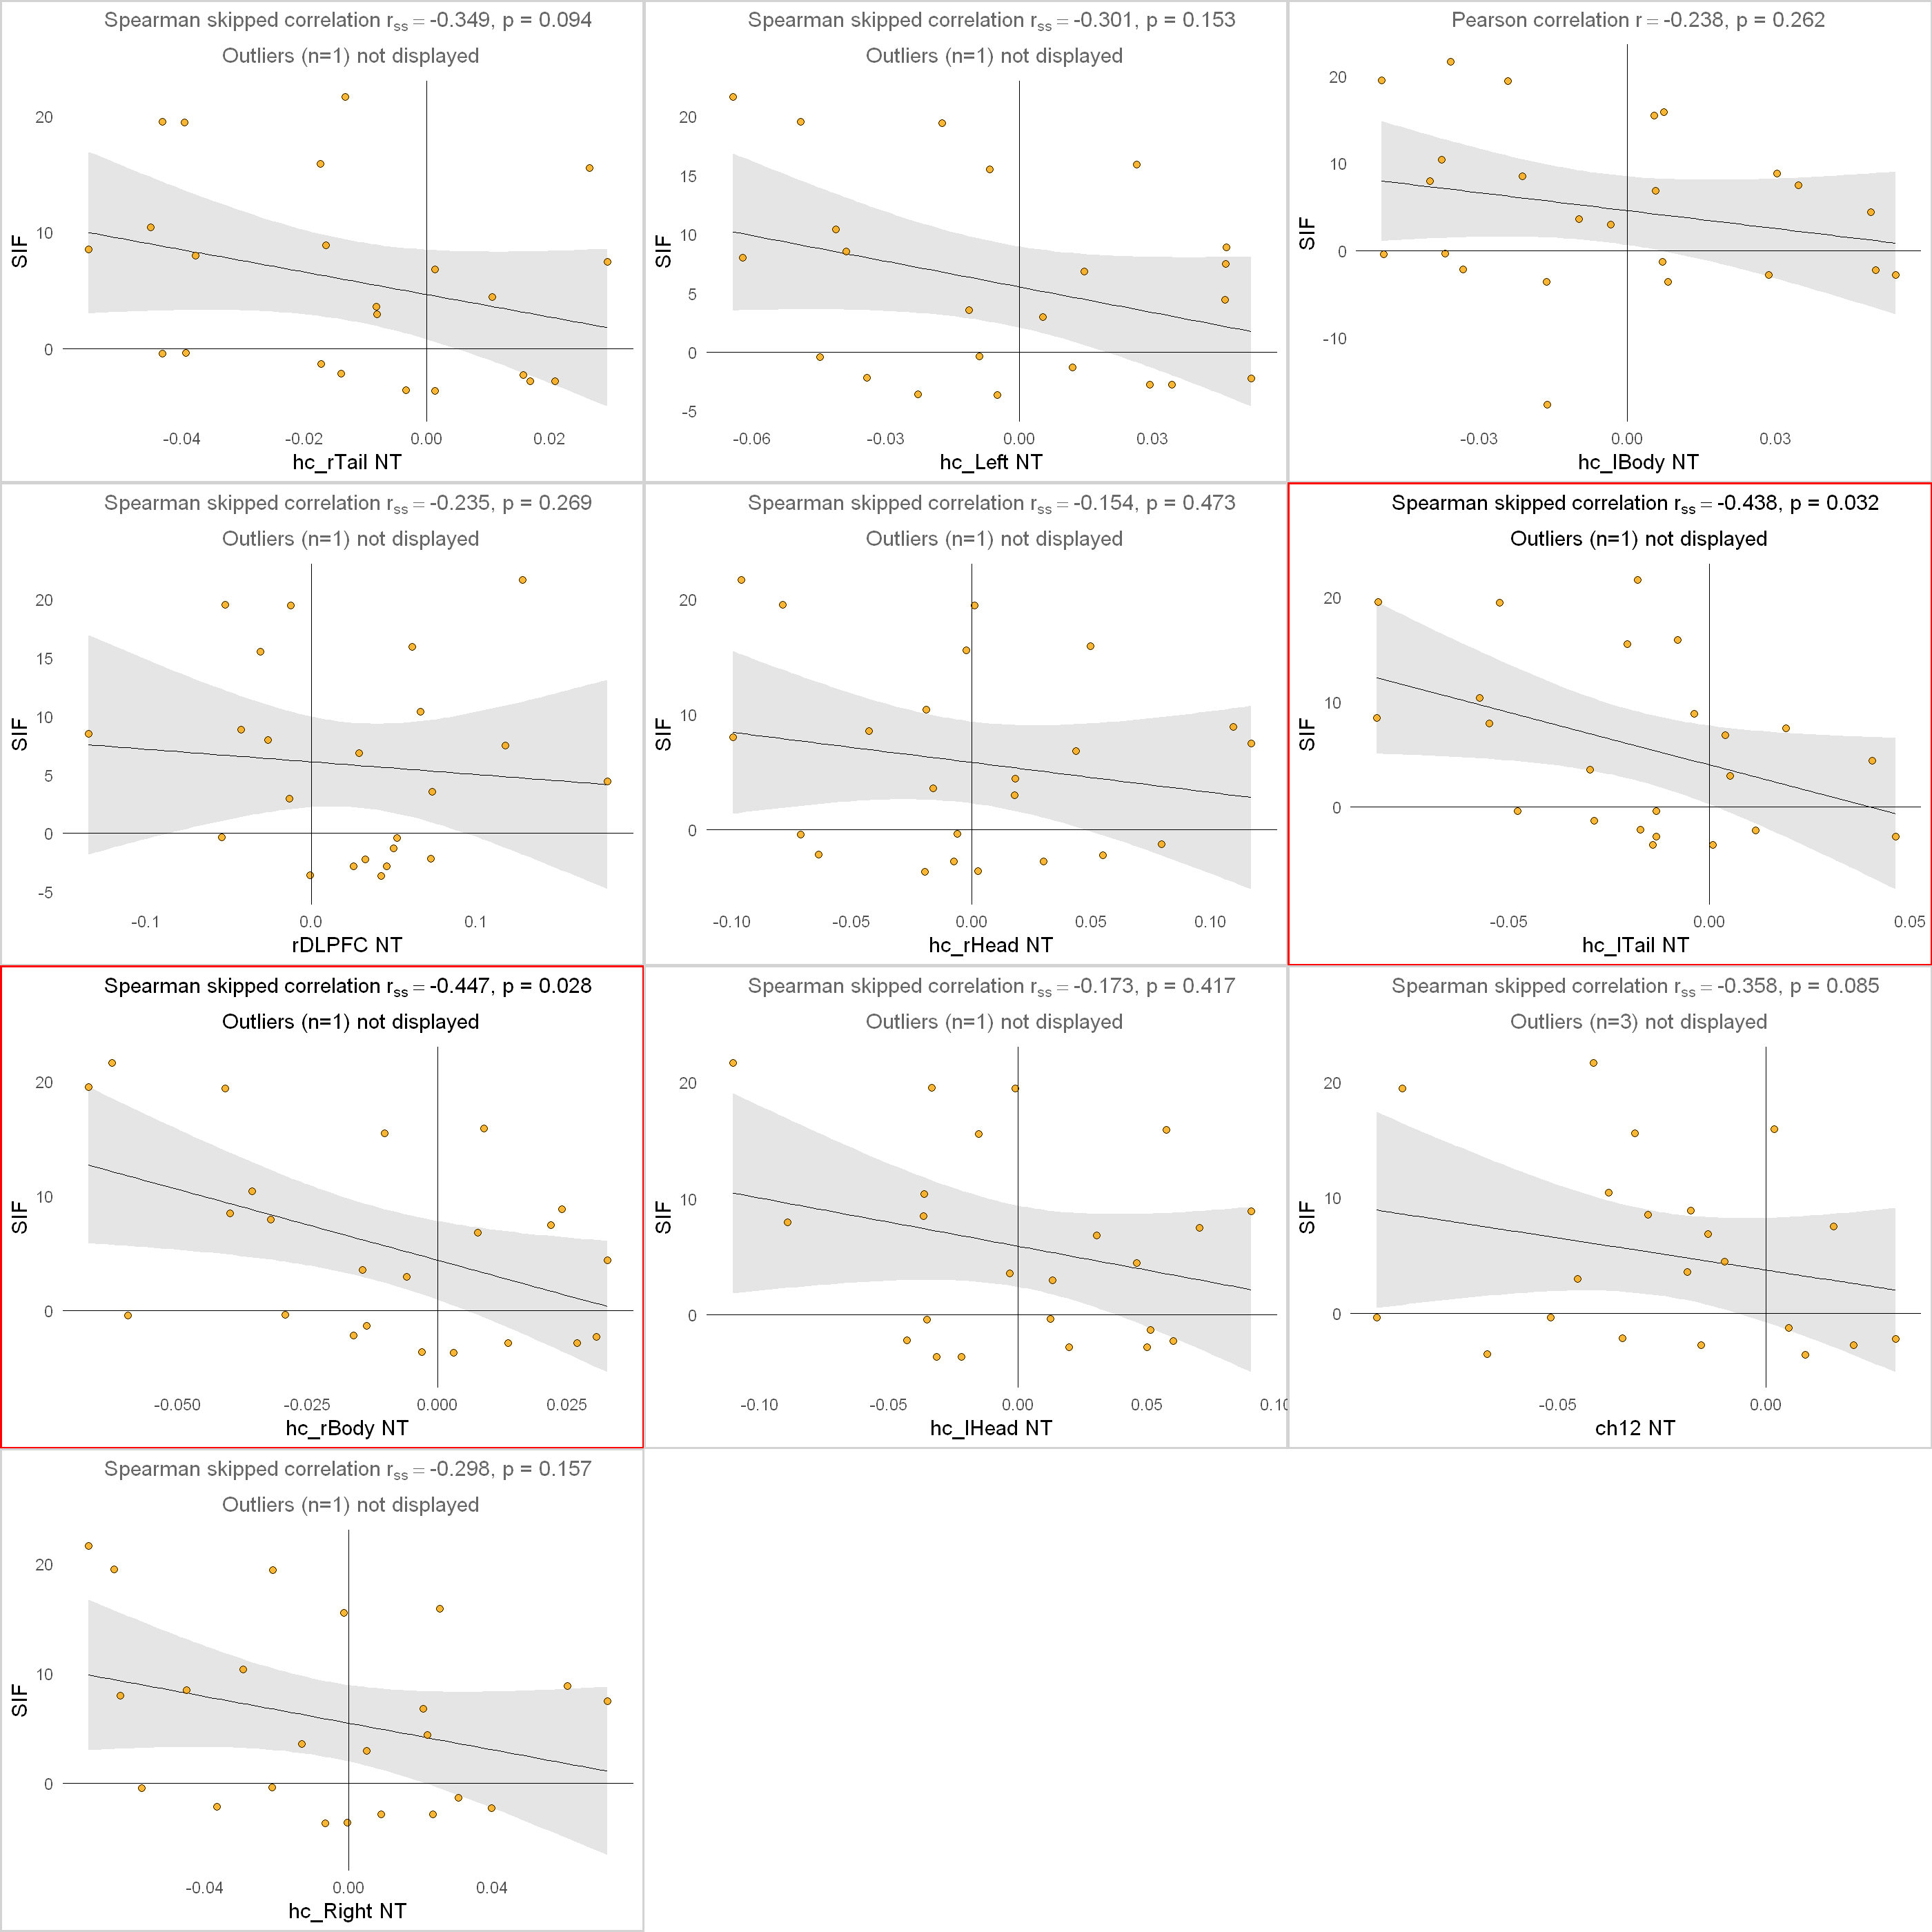

In [14]:
ds <- datasets[5]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "09_Xu"

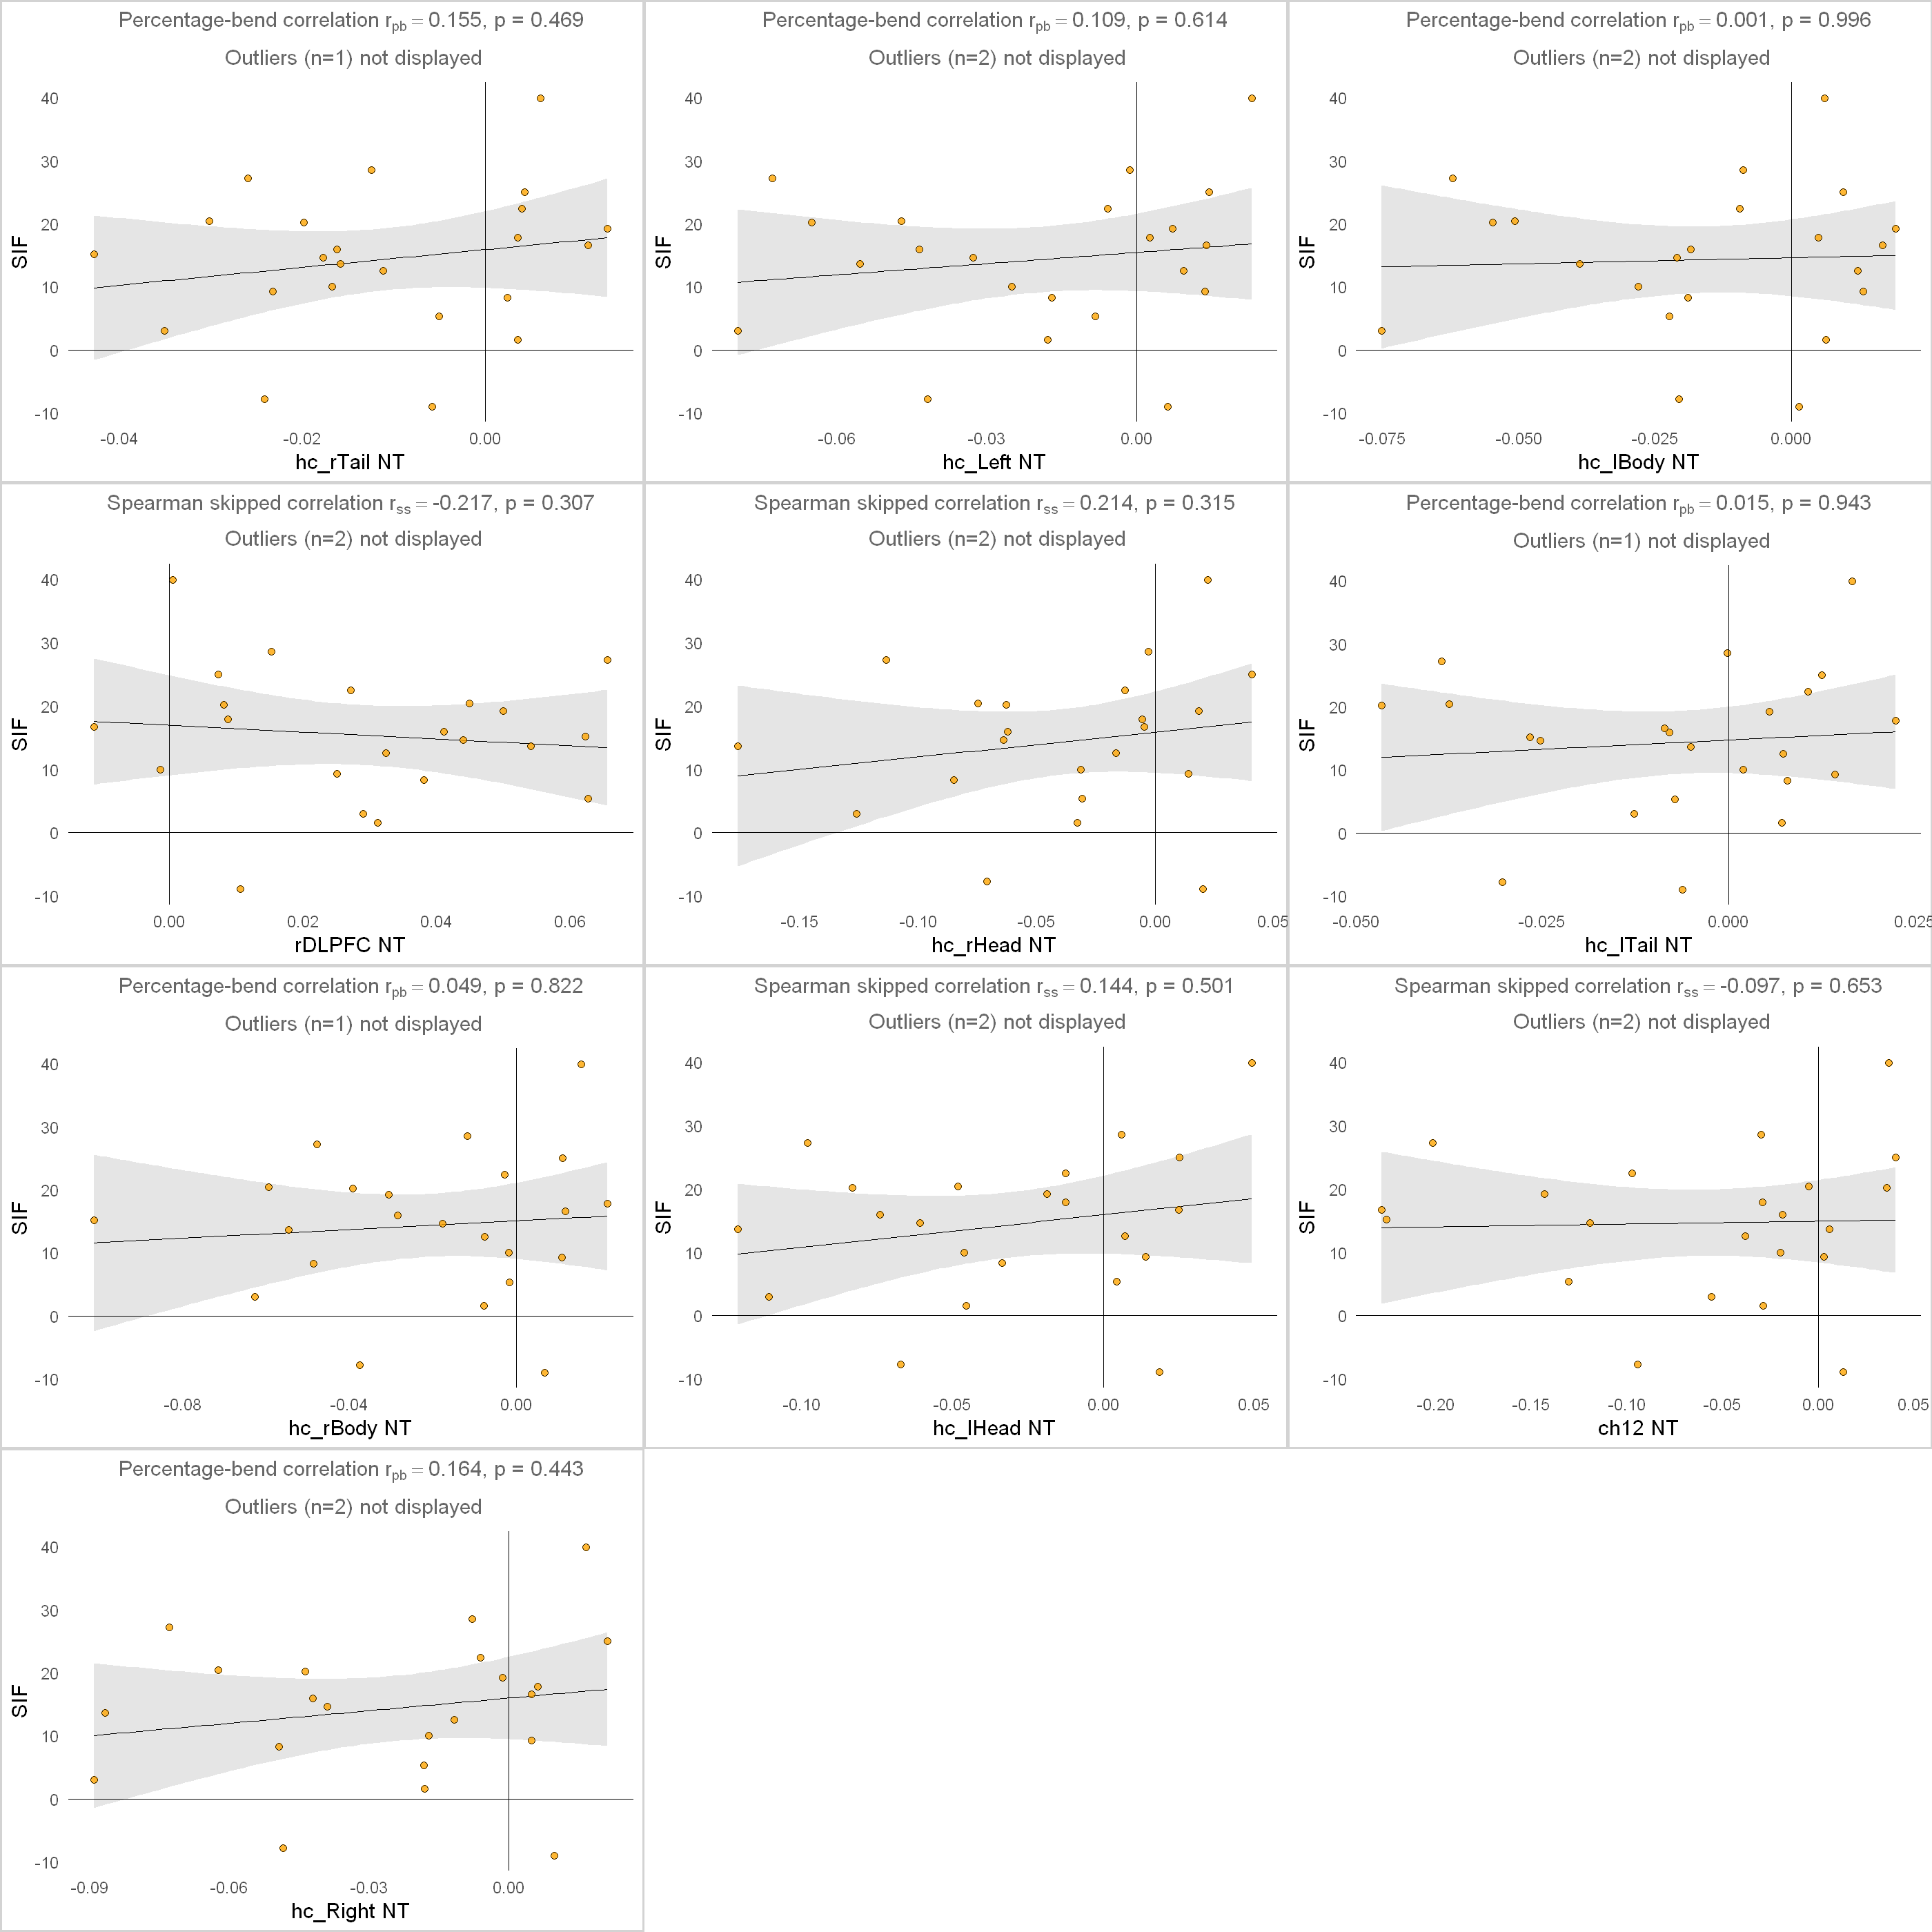

In [15]:
ds <- datasets[6]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

[1] "10_Big-TNT"

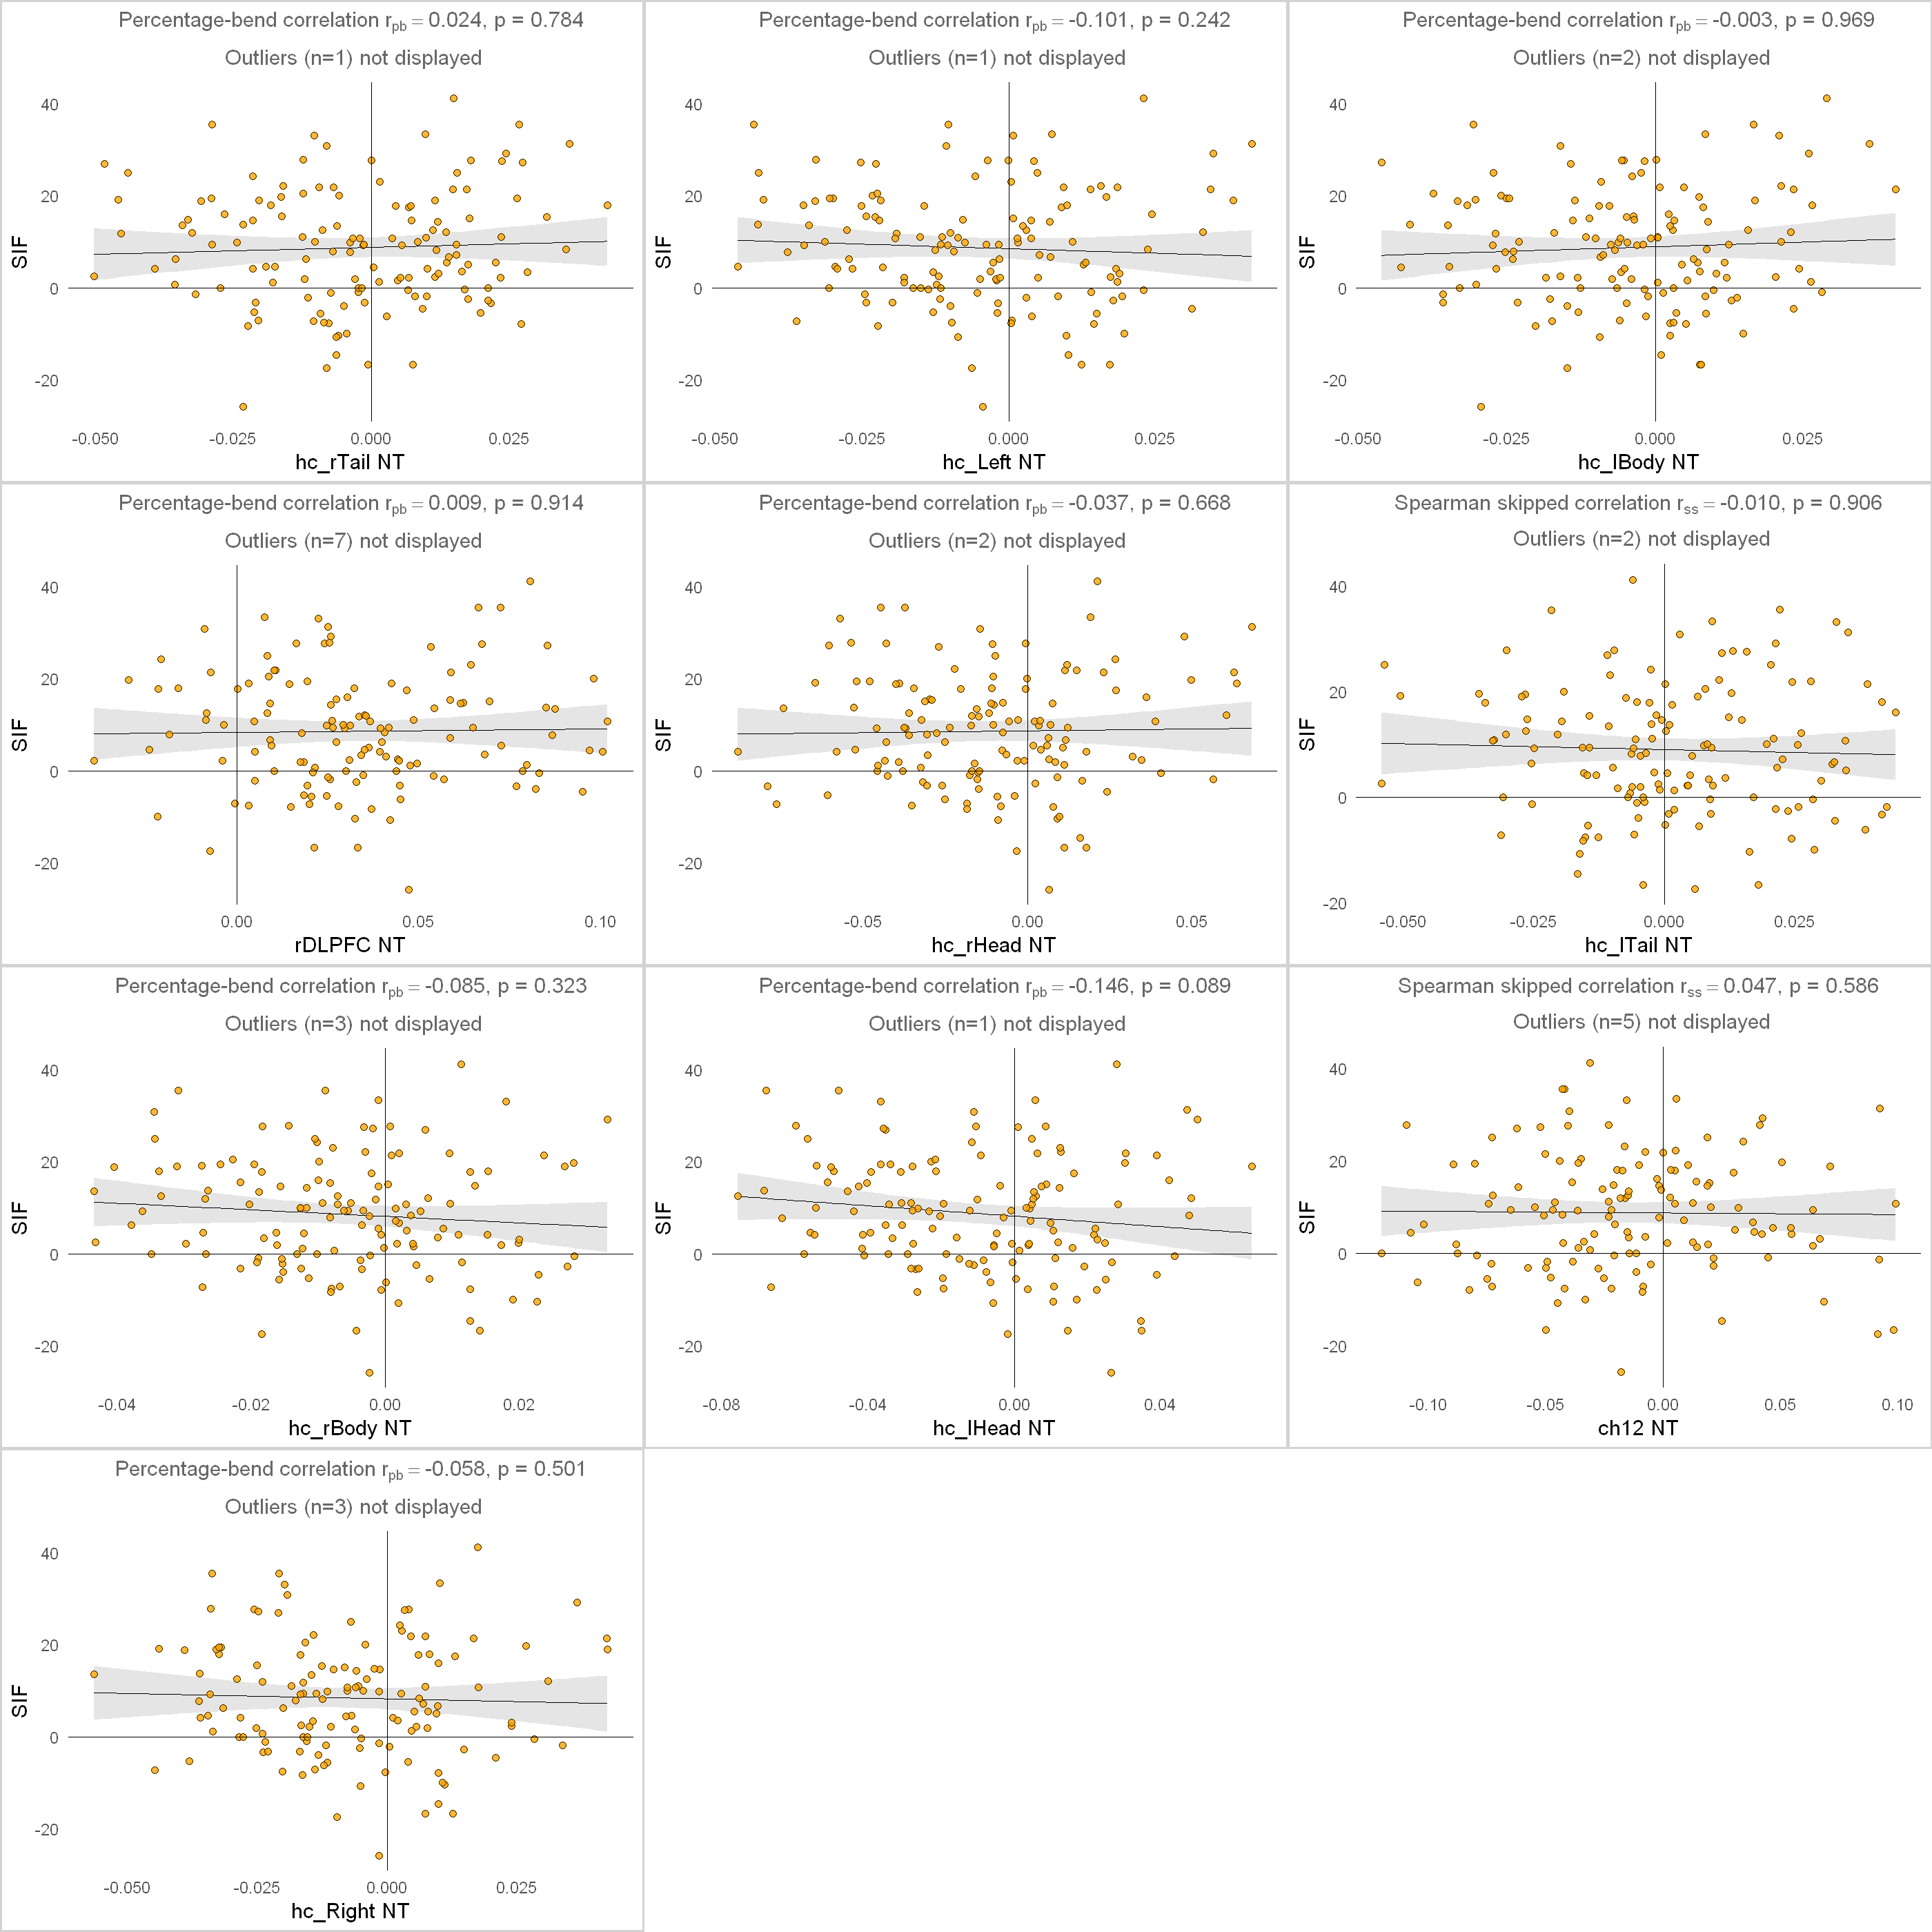

In [16]:
ds <- datasets[7]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "NT", "SIF")

## Think

[1] "01_Levy1"

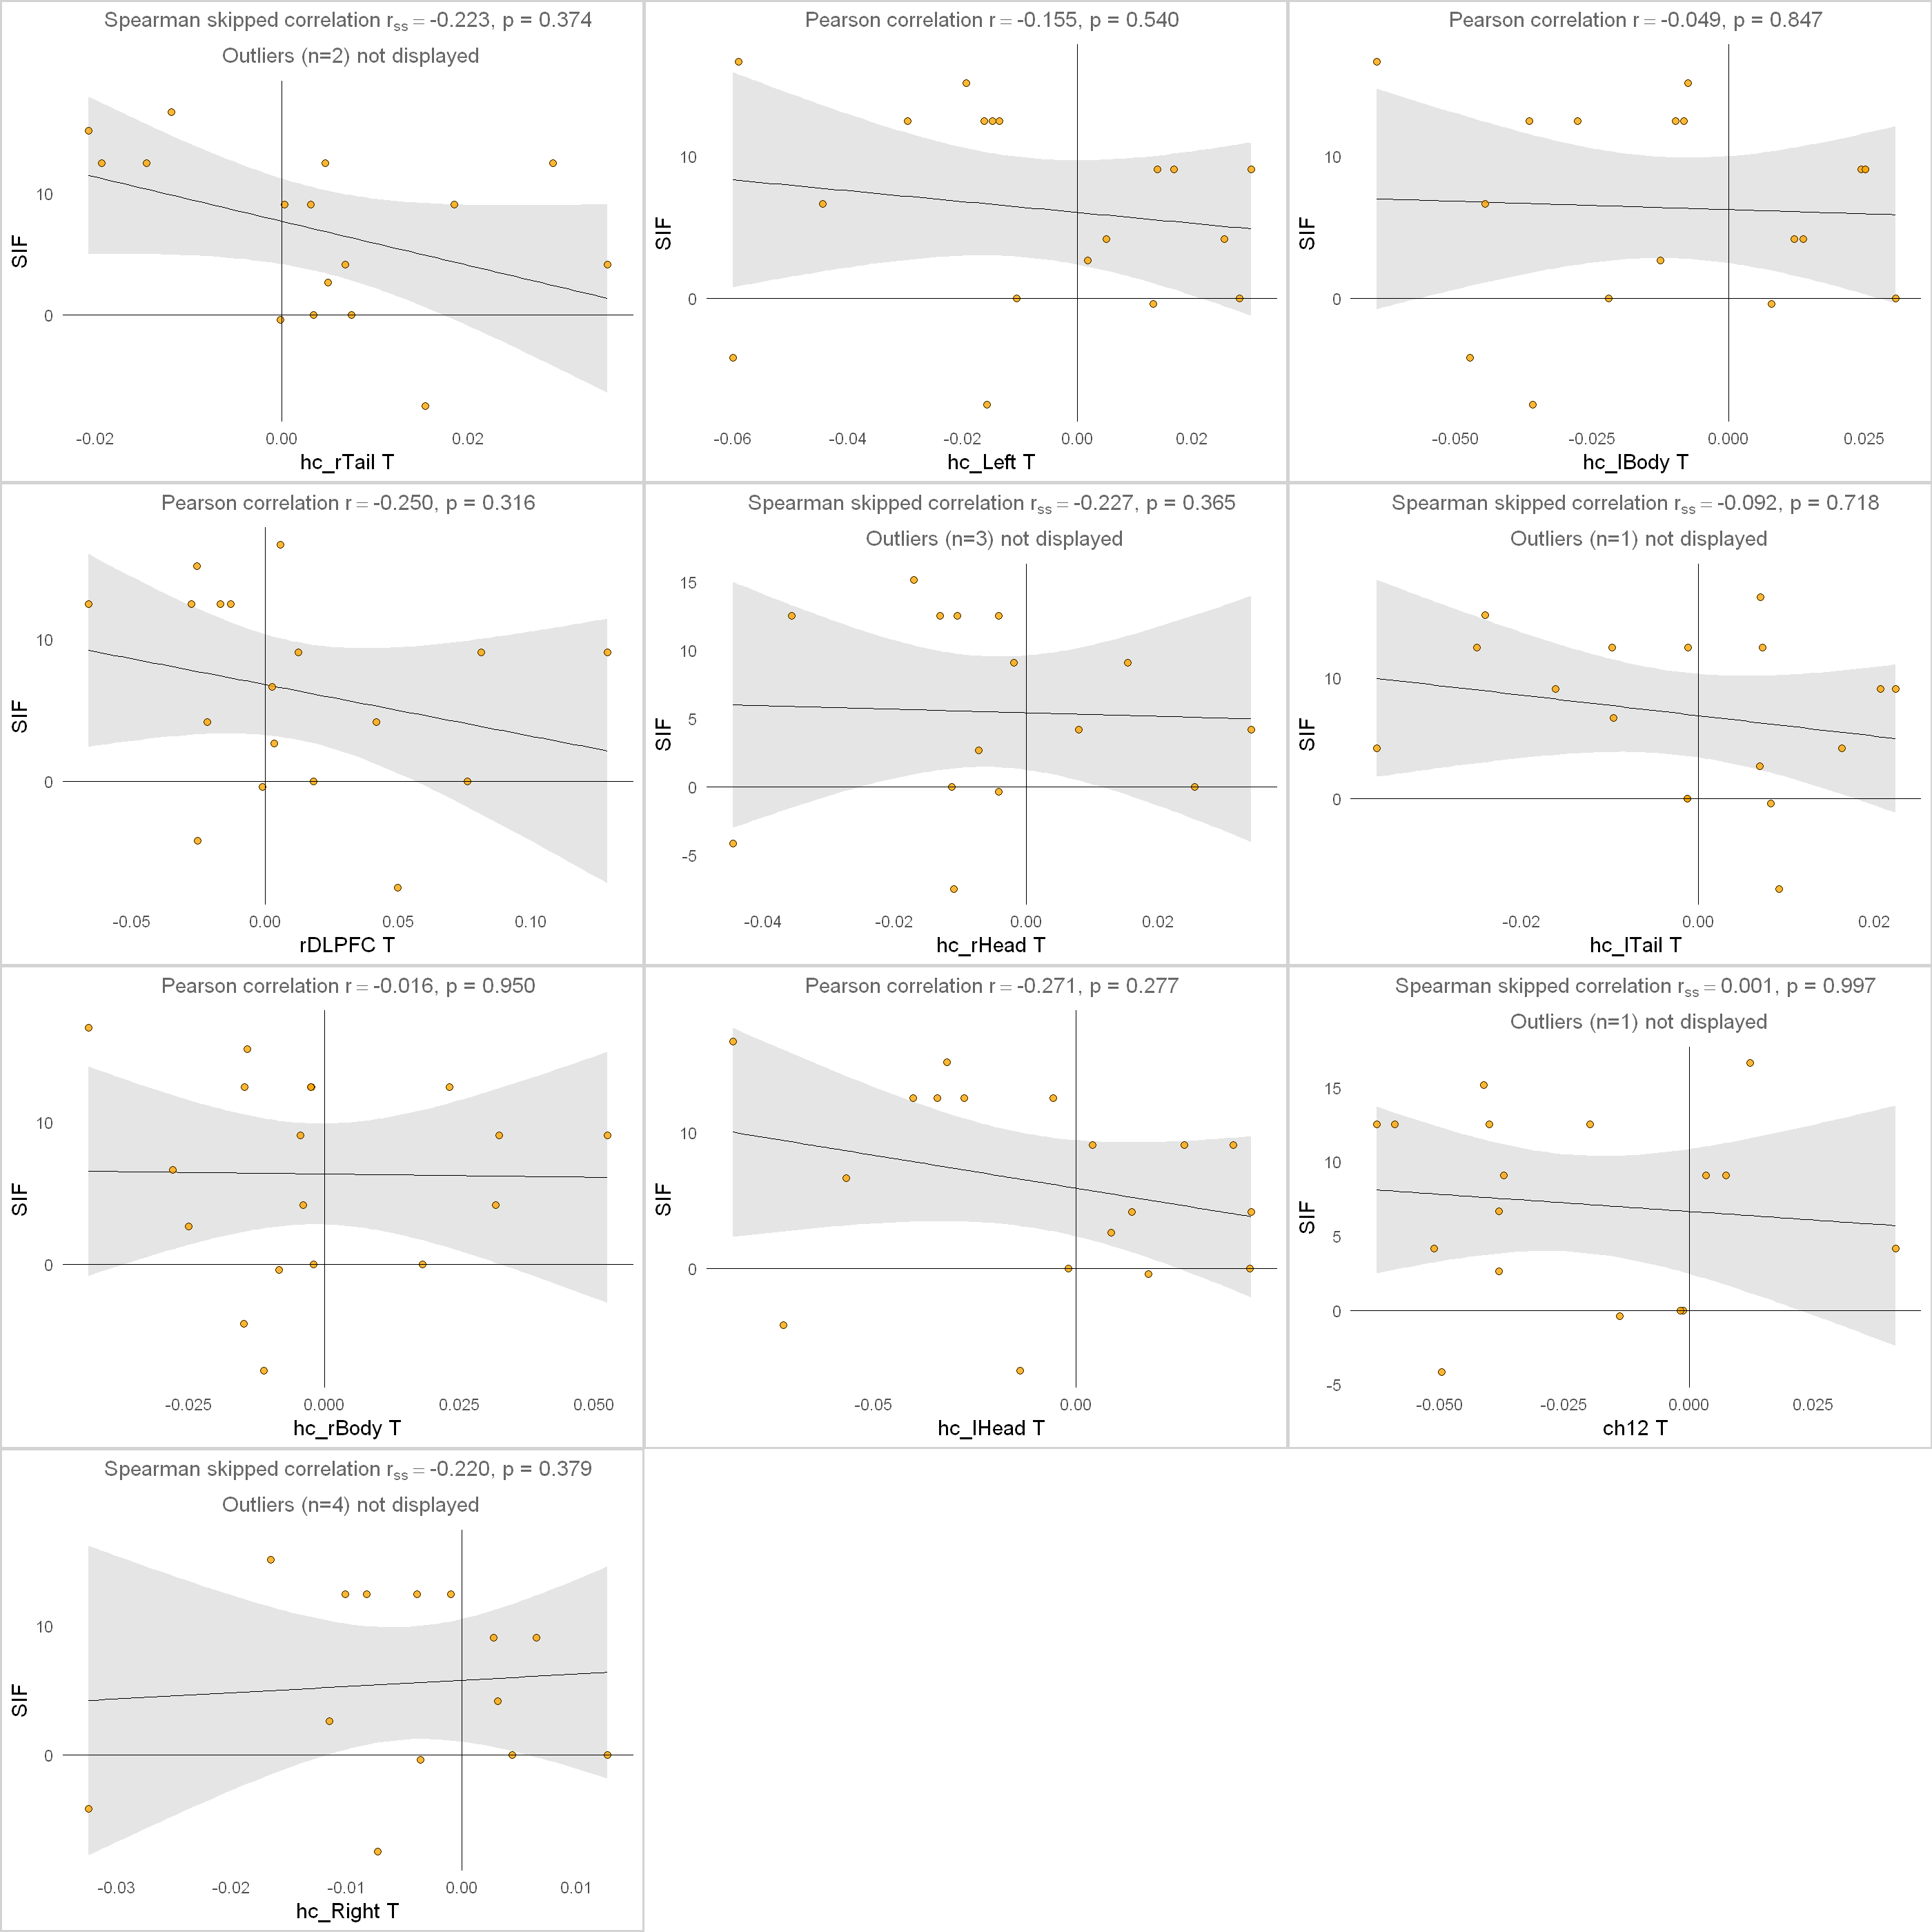

In [17]:
ds <- datasets[1]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "02_Levy2"

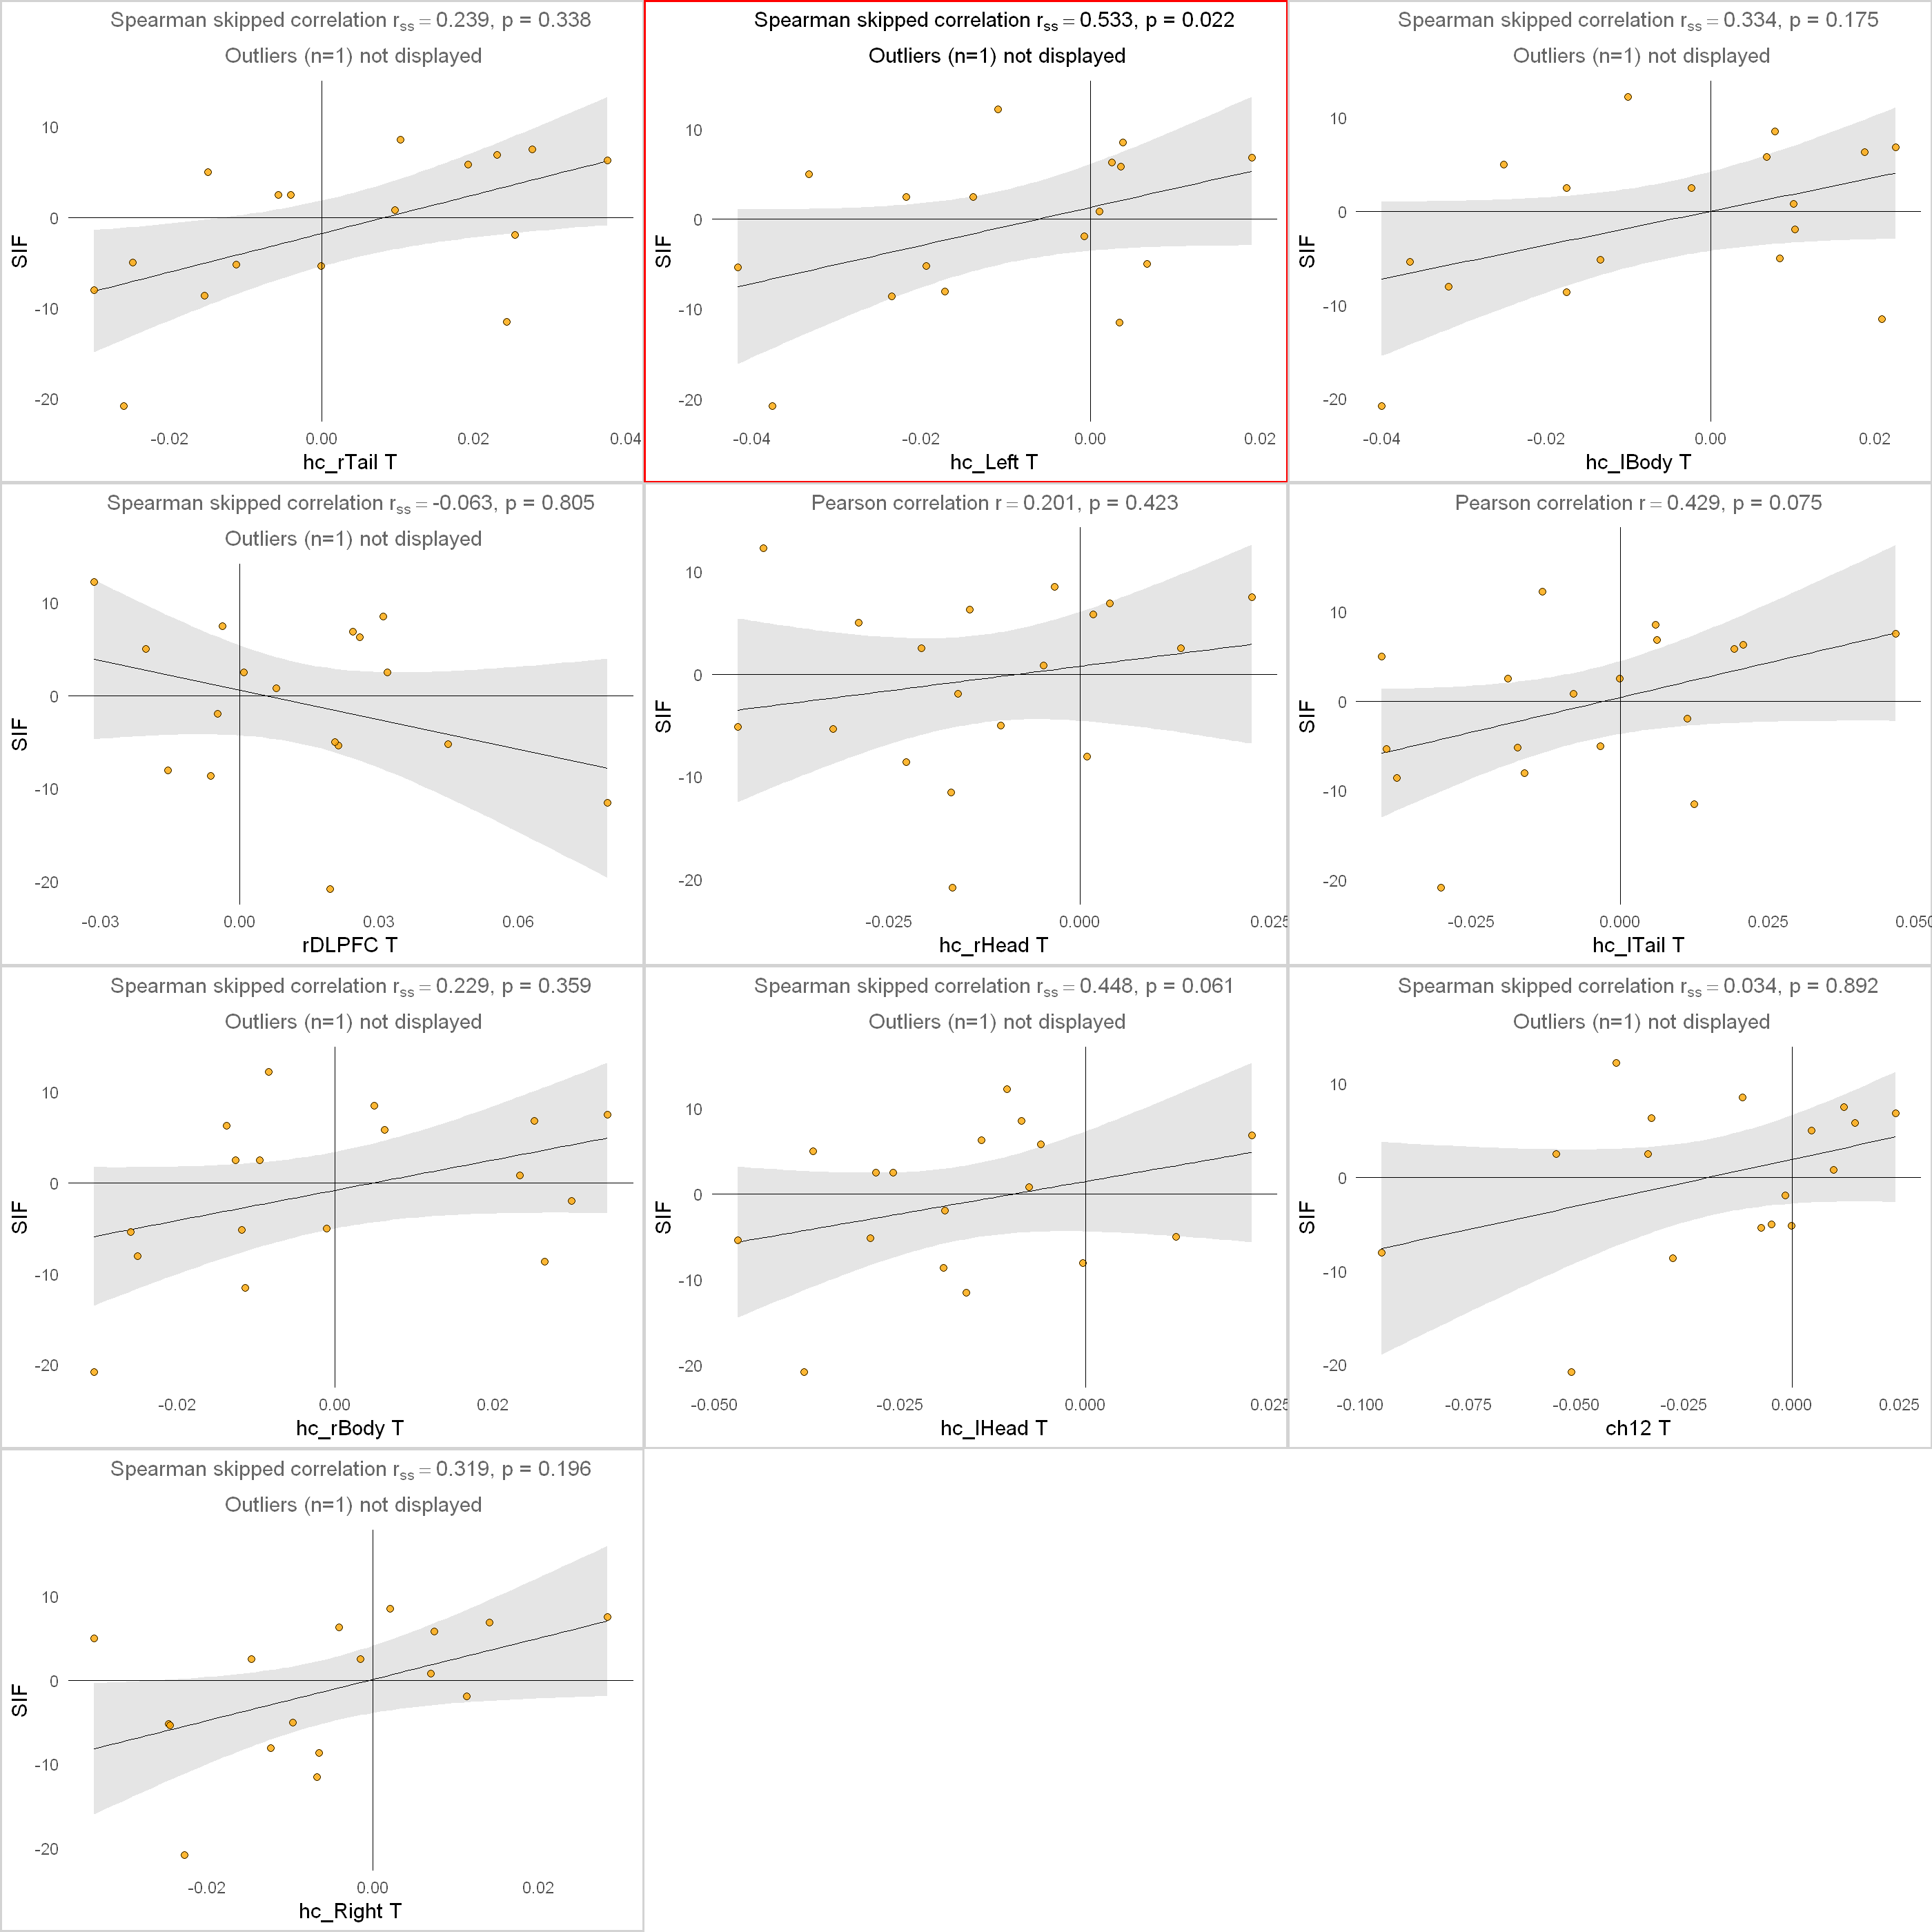

In [18]:
ds <- datasets[2]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "05_Yuhua"

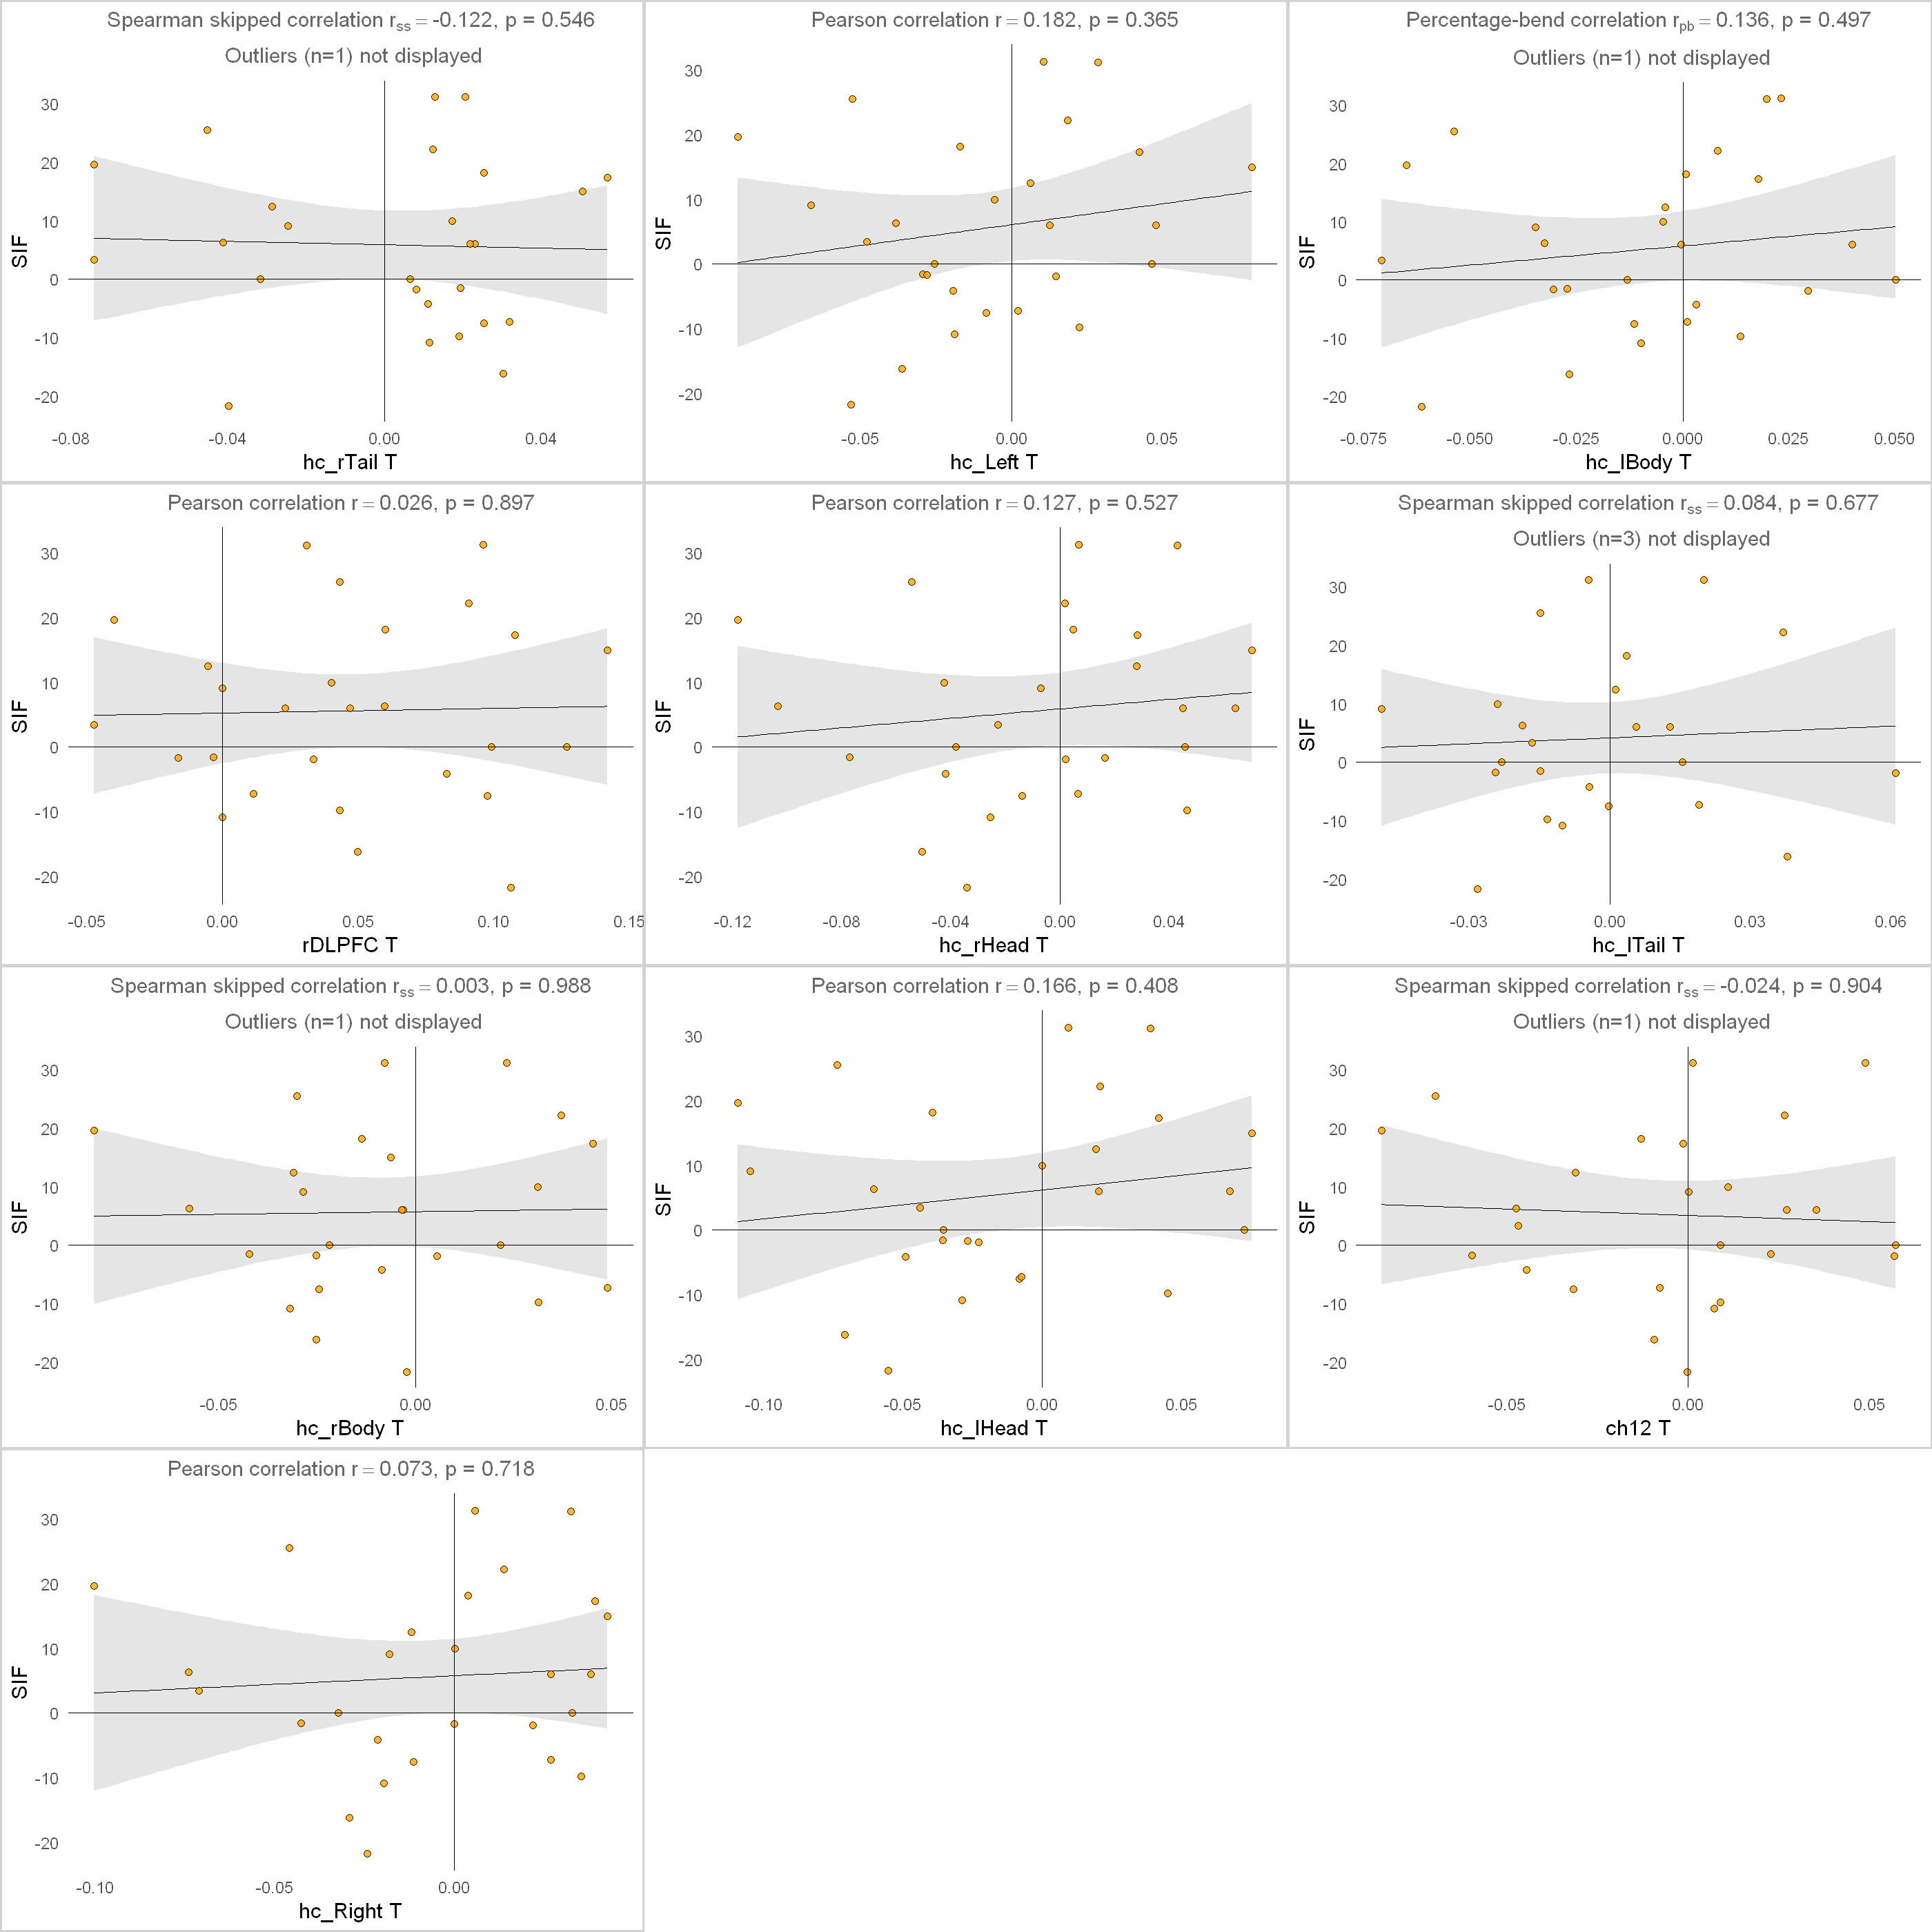

In [19]:
ds <- datasets[3]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "06_RolandNeuron"

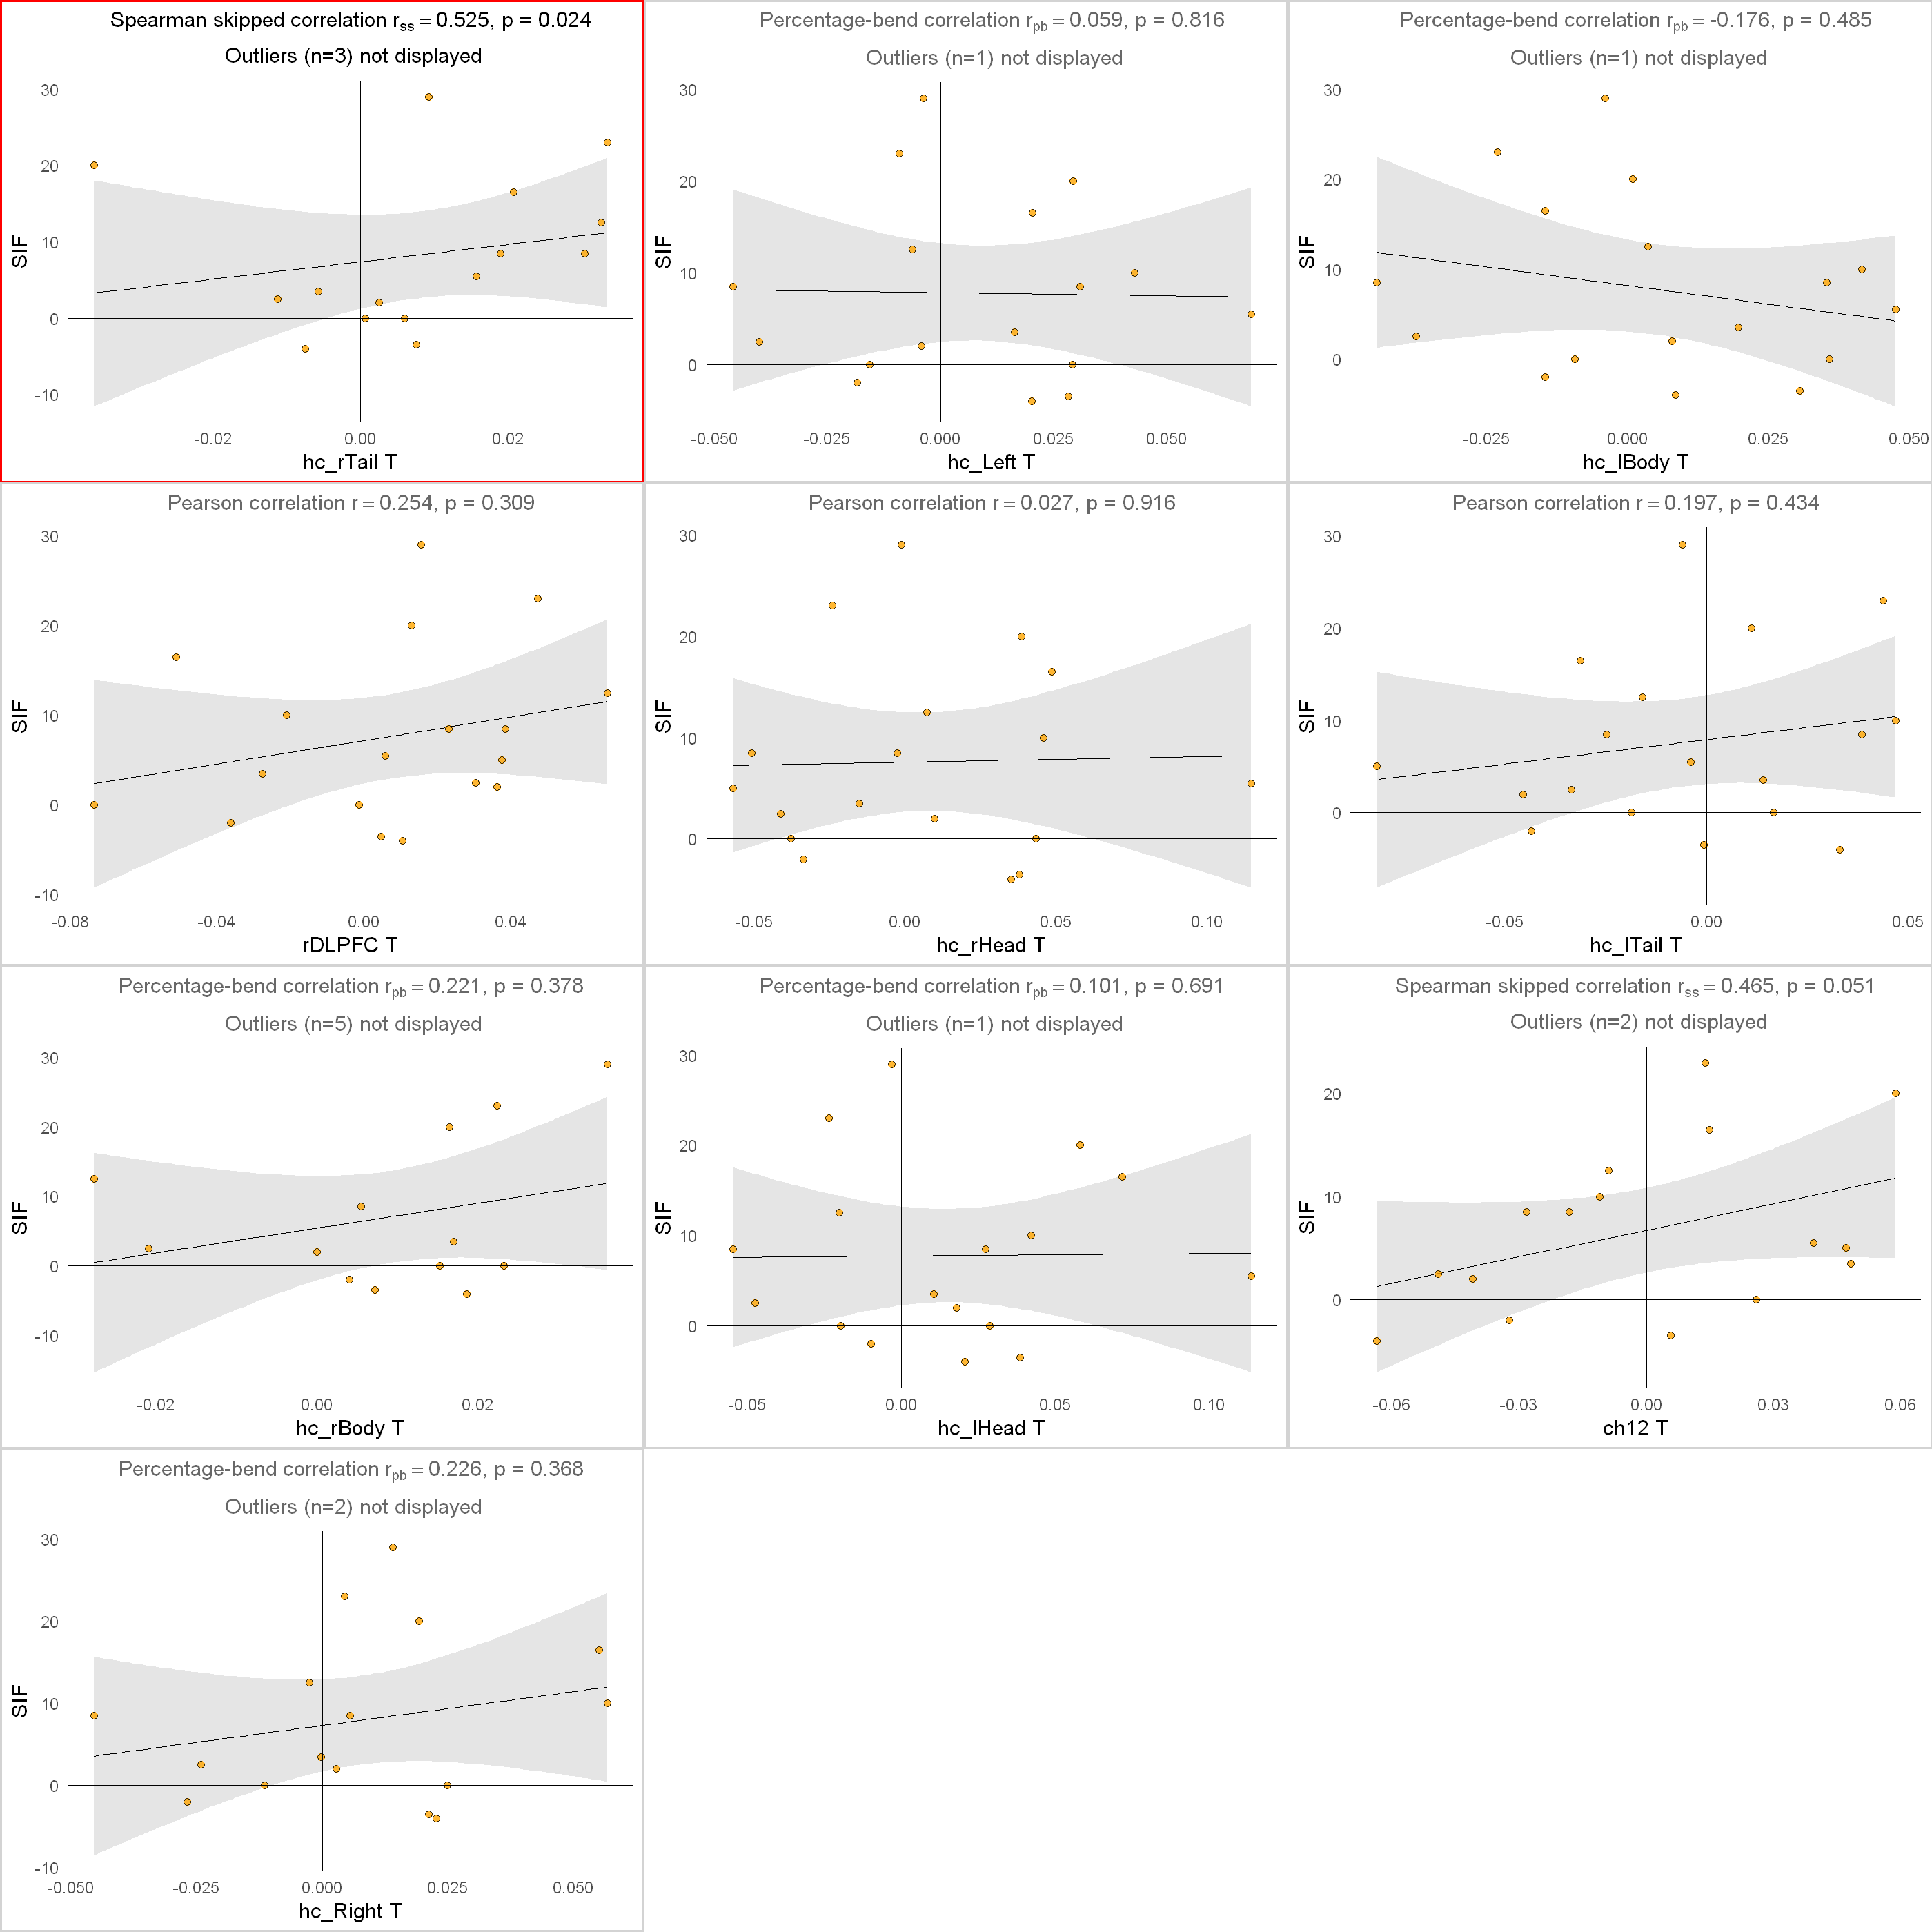

In [20]:
ds <- datasets[4]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "08_Taylor"

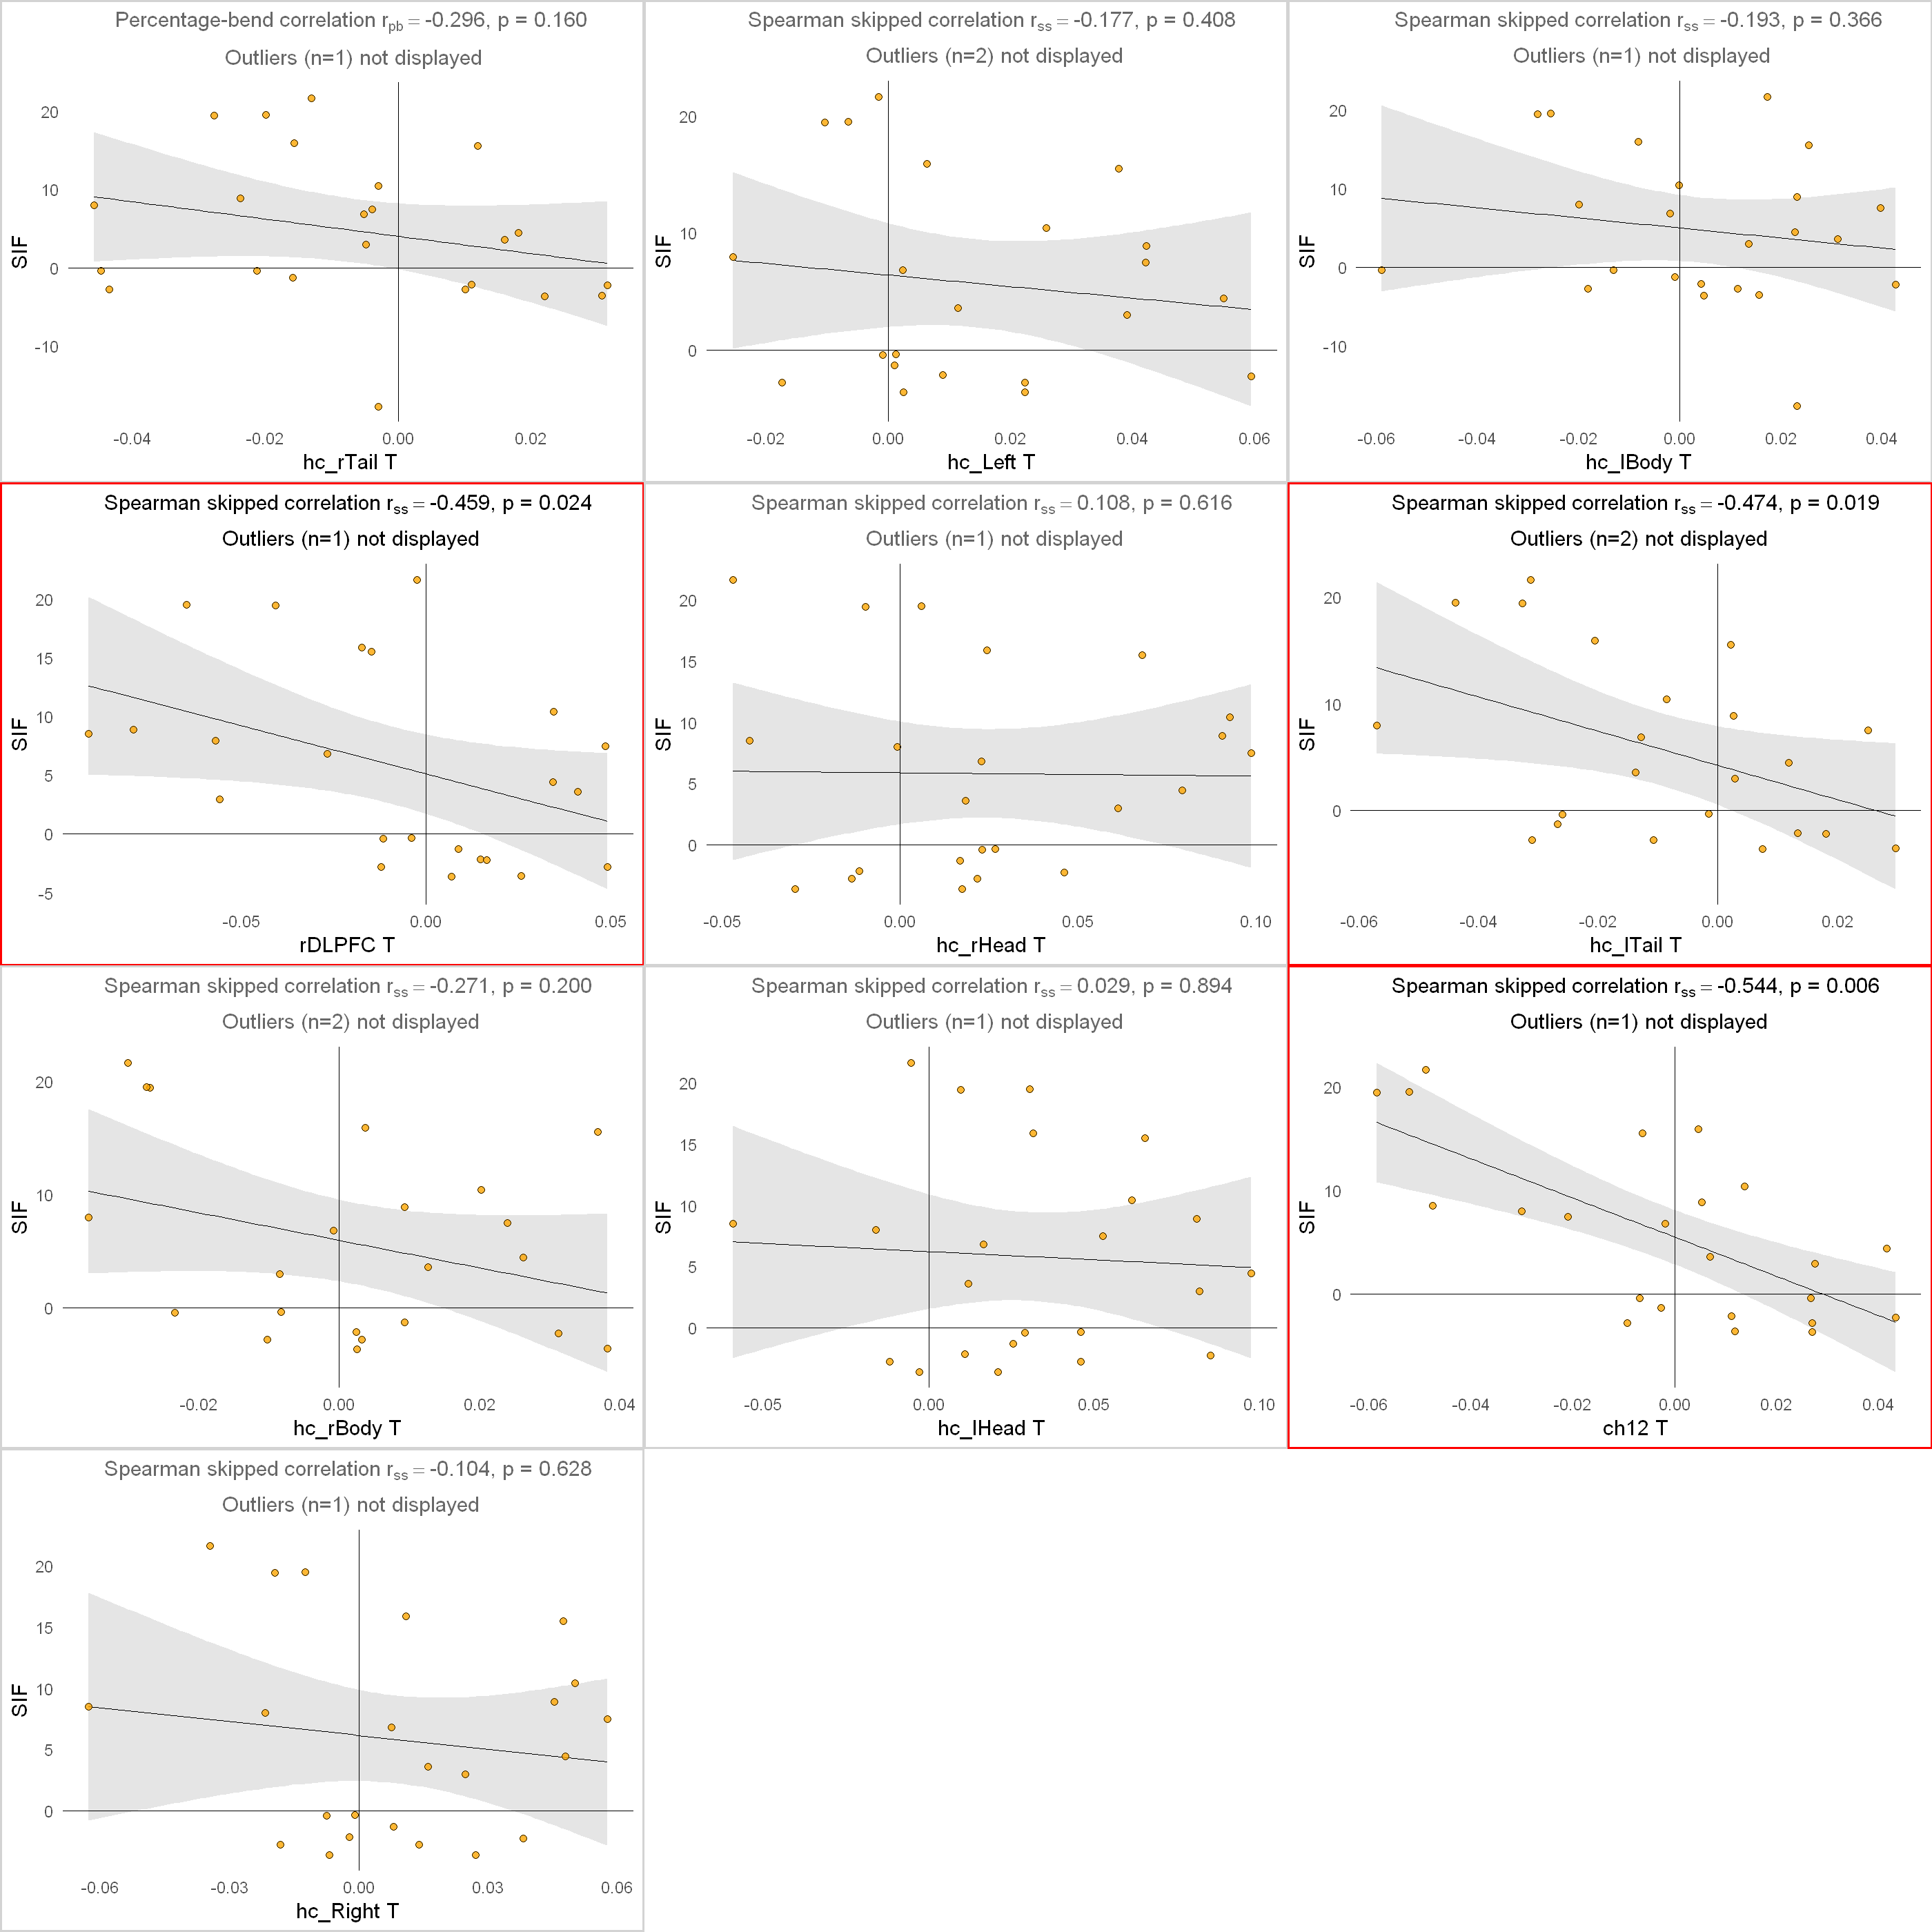

In [21]:
ds <- datasets[5]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "09_Xu"

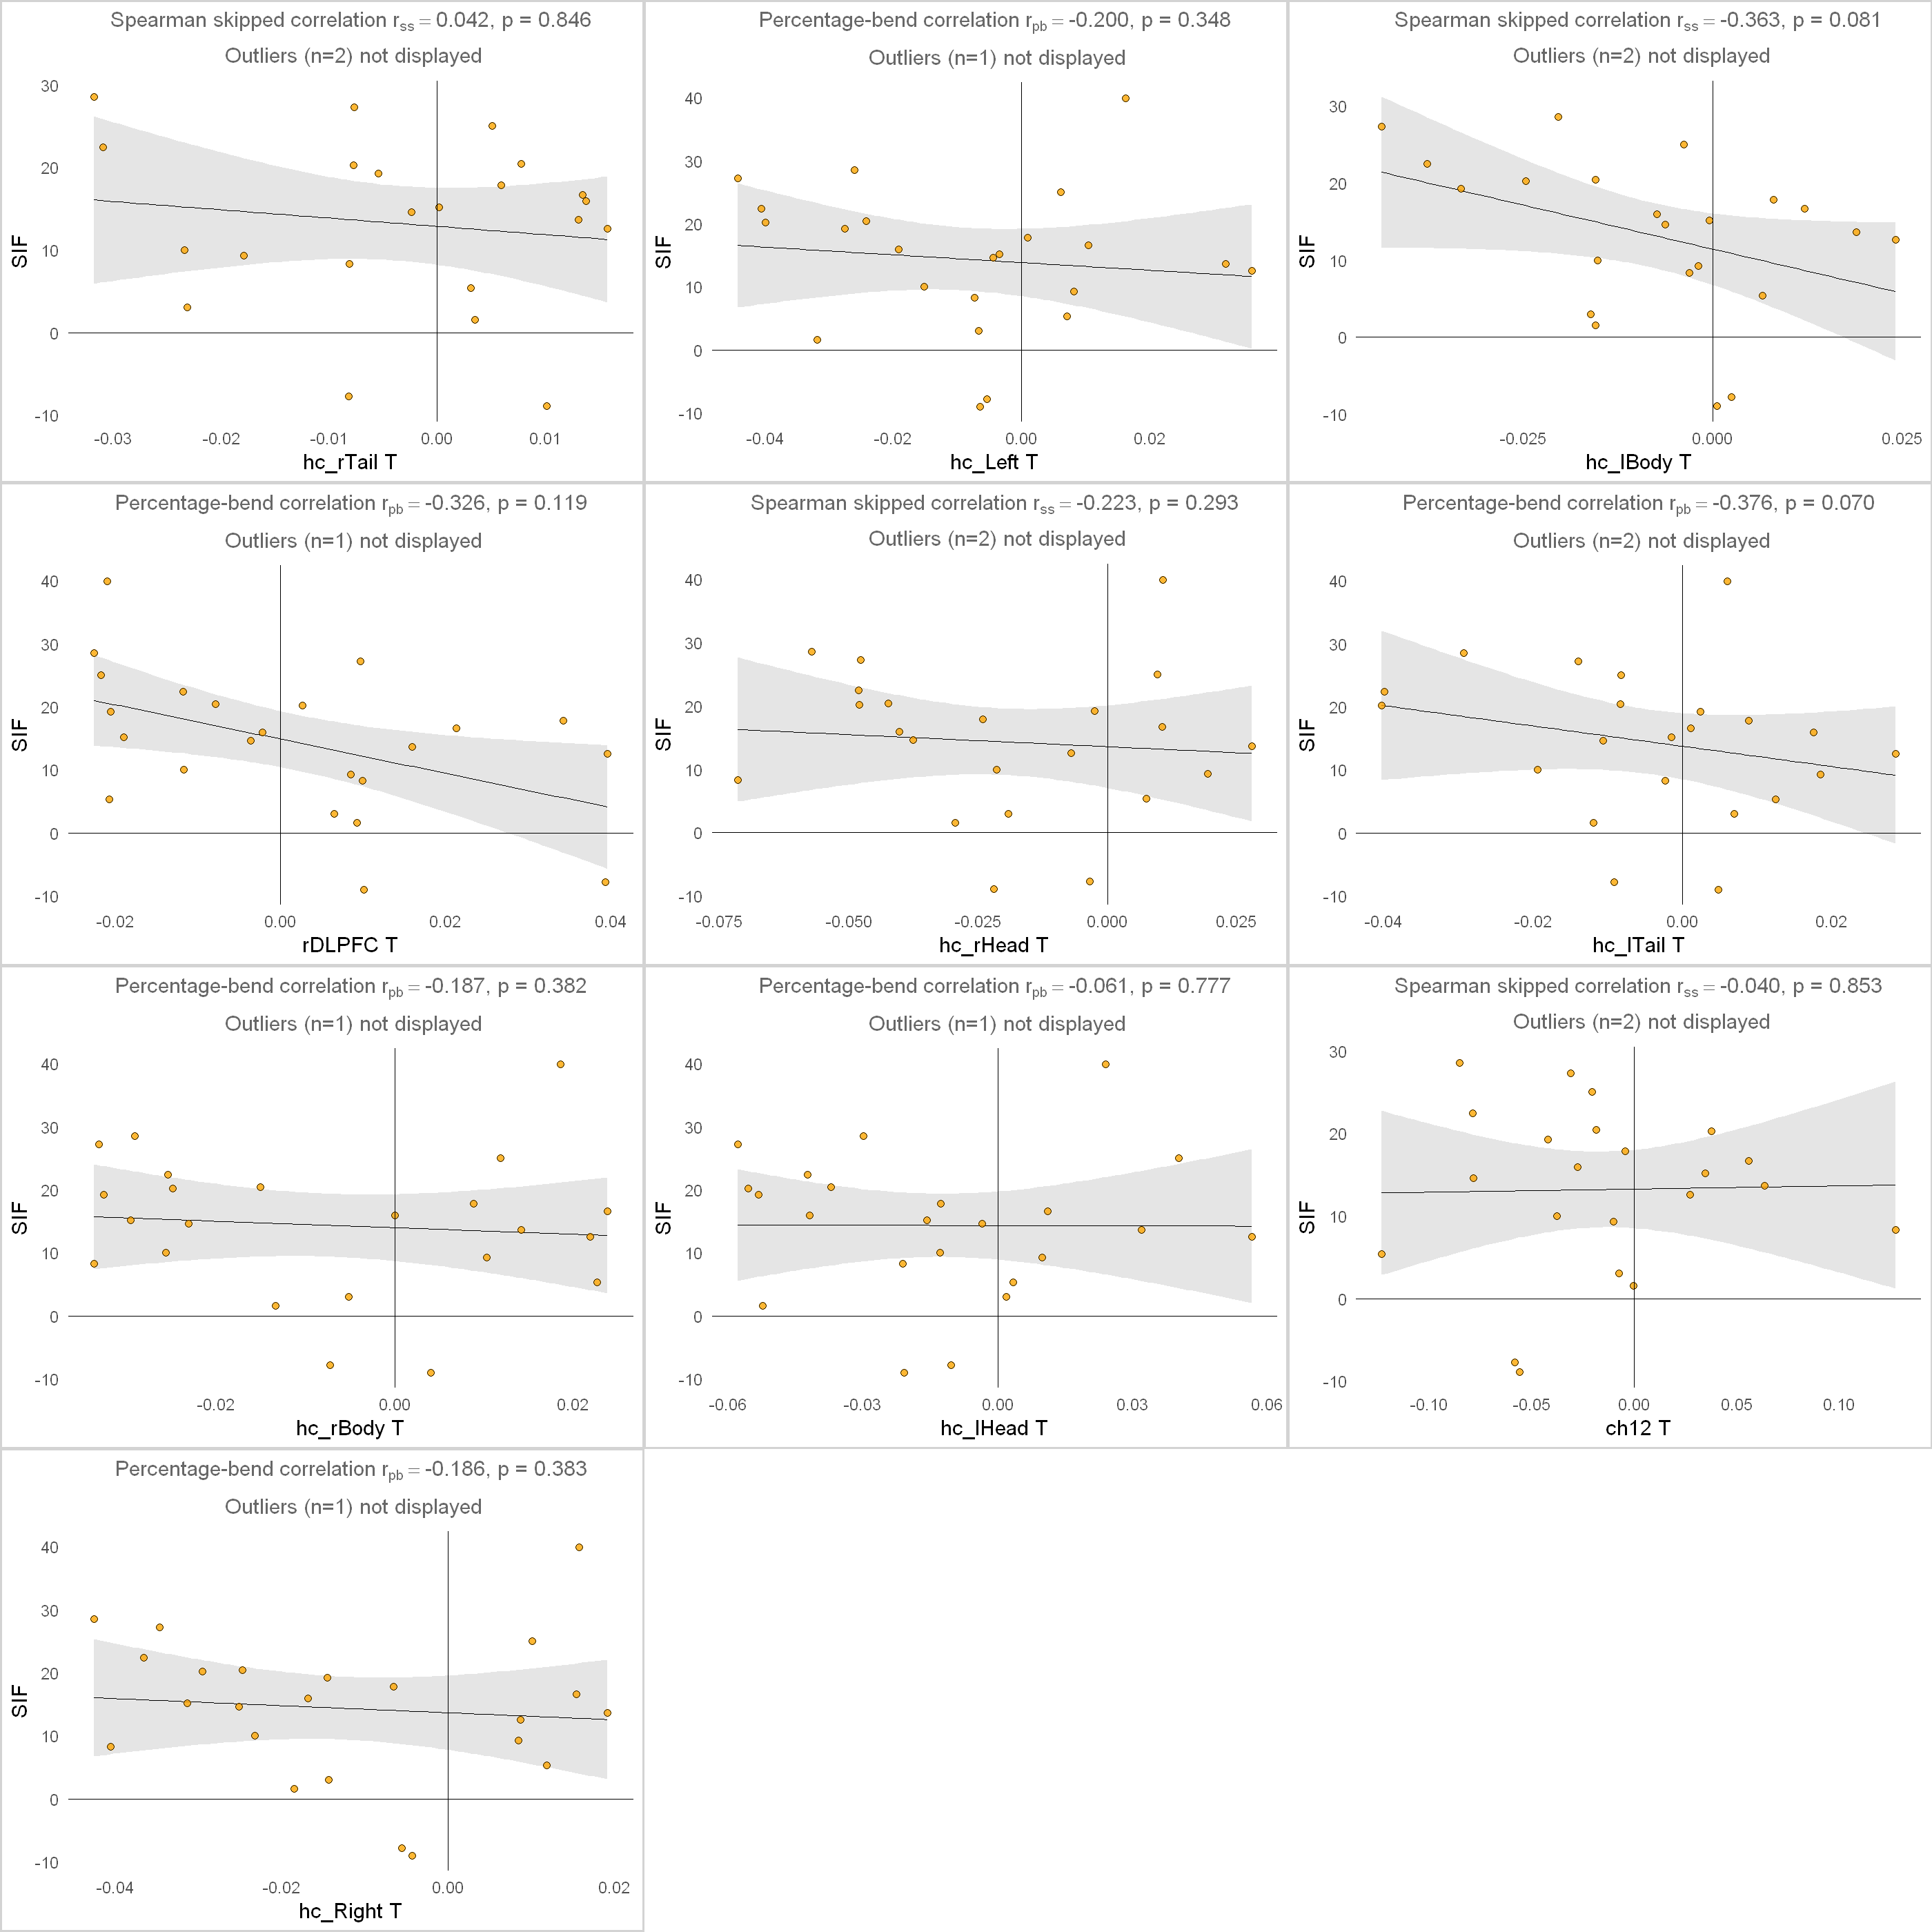

In [22]:
ds <- datasets[6]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

[1] "10_Big-TNT"

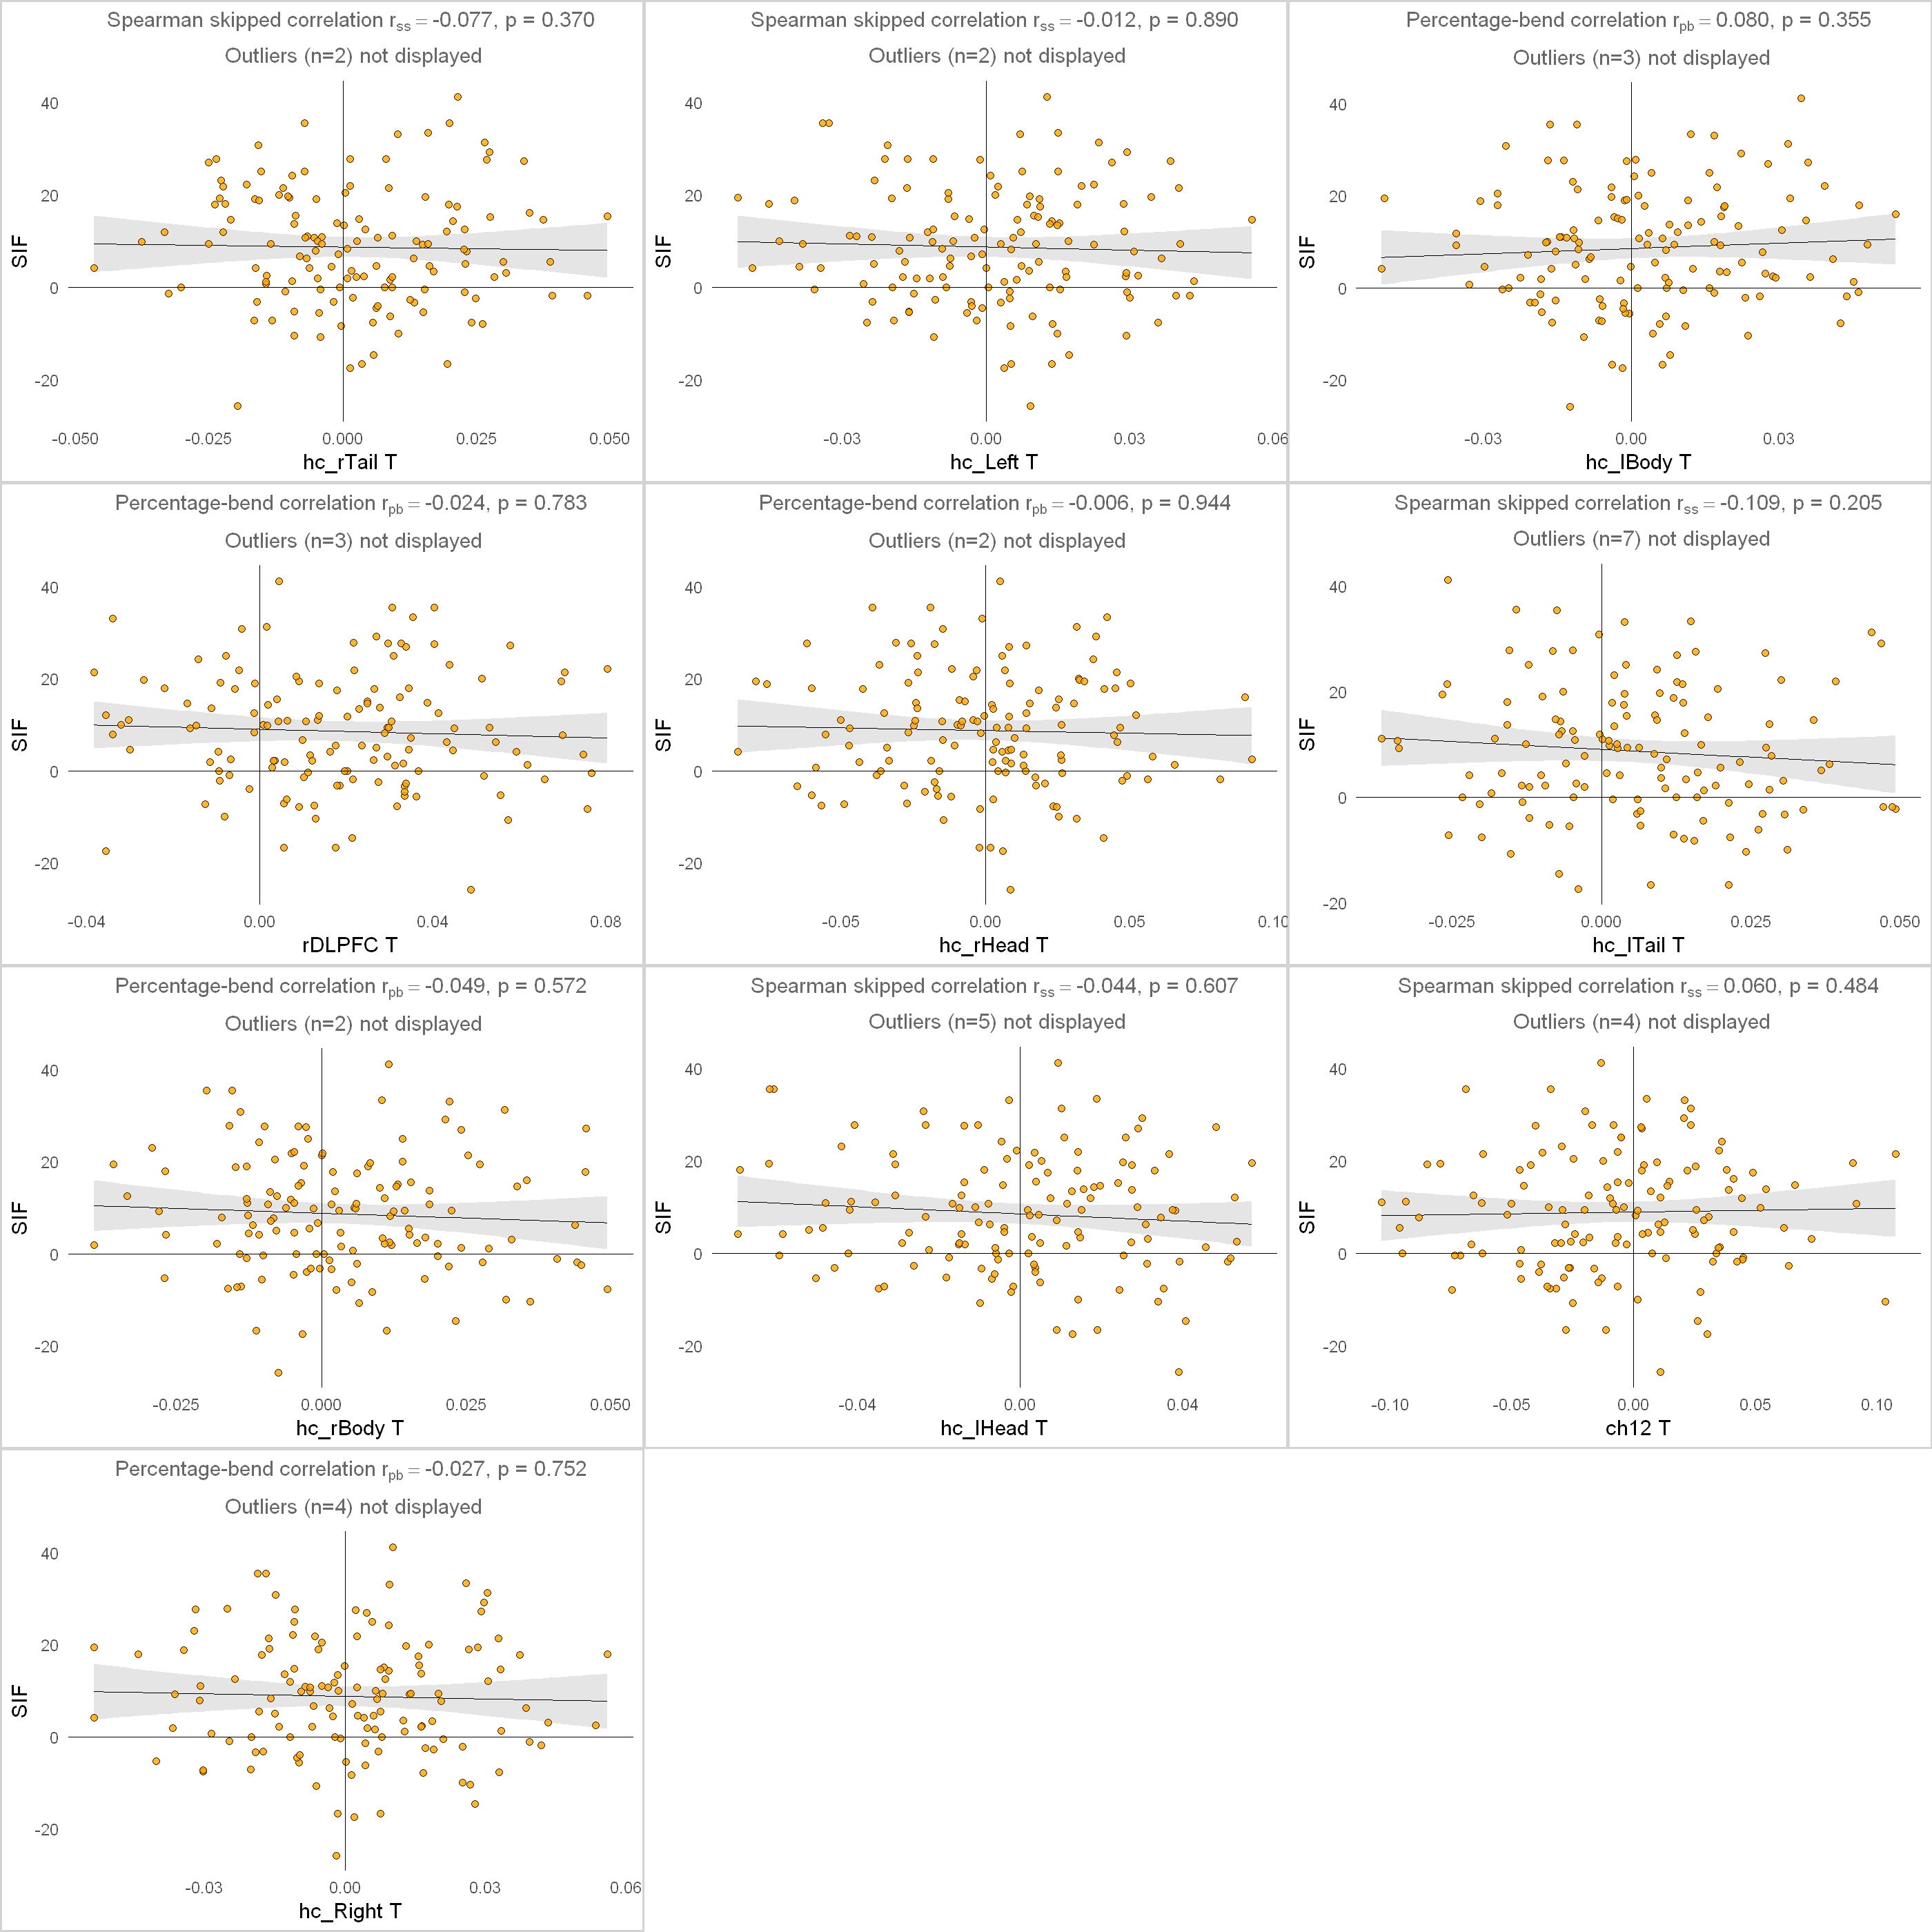

In [23]:
ds <- datasets[7]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T", "SIF")

## Think-No-Think

[1] "01_Levy1"

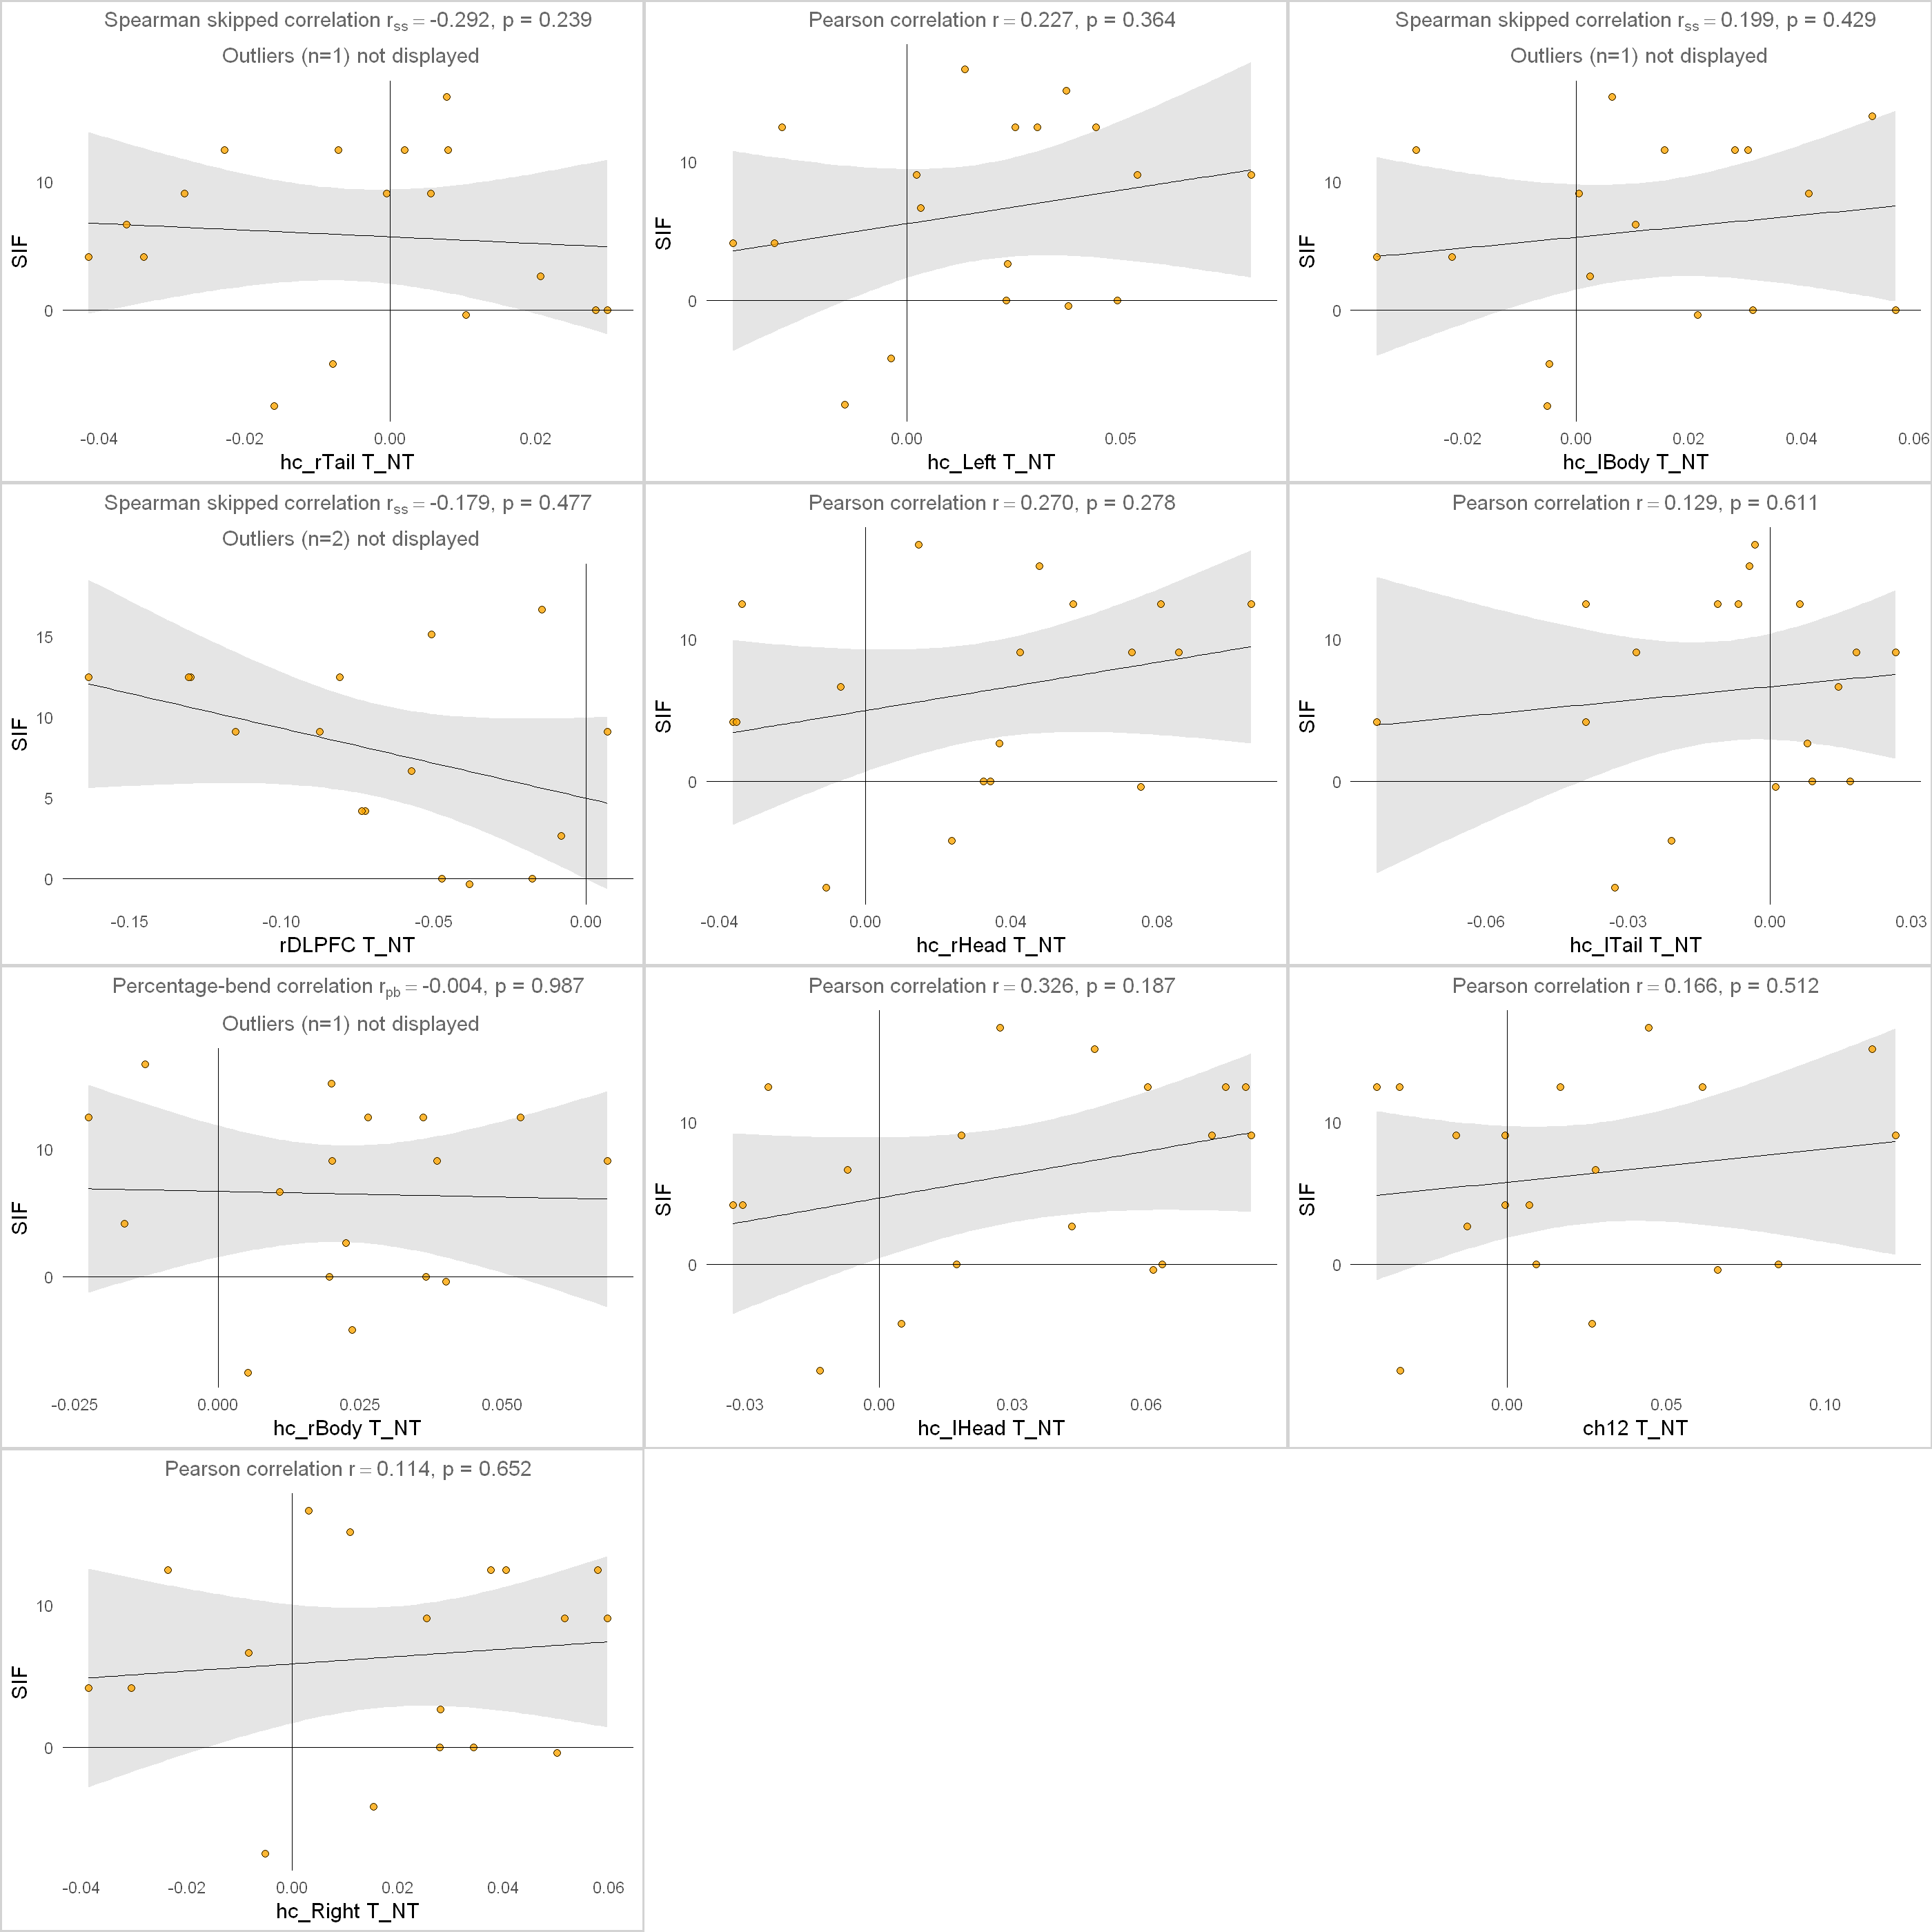

In [24]:
ds <- datasets[1]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "02_Levy2"

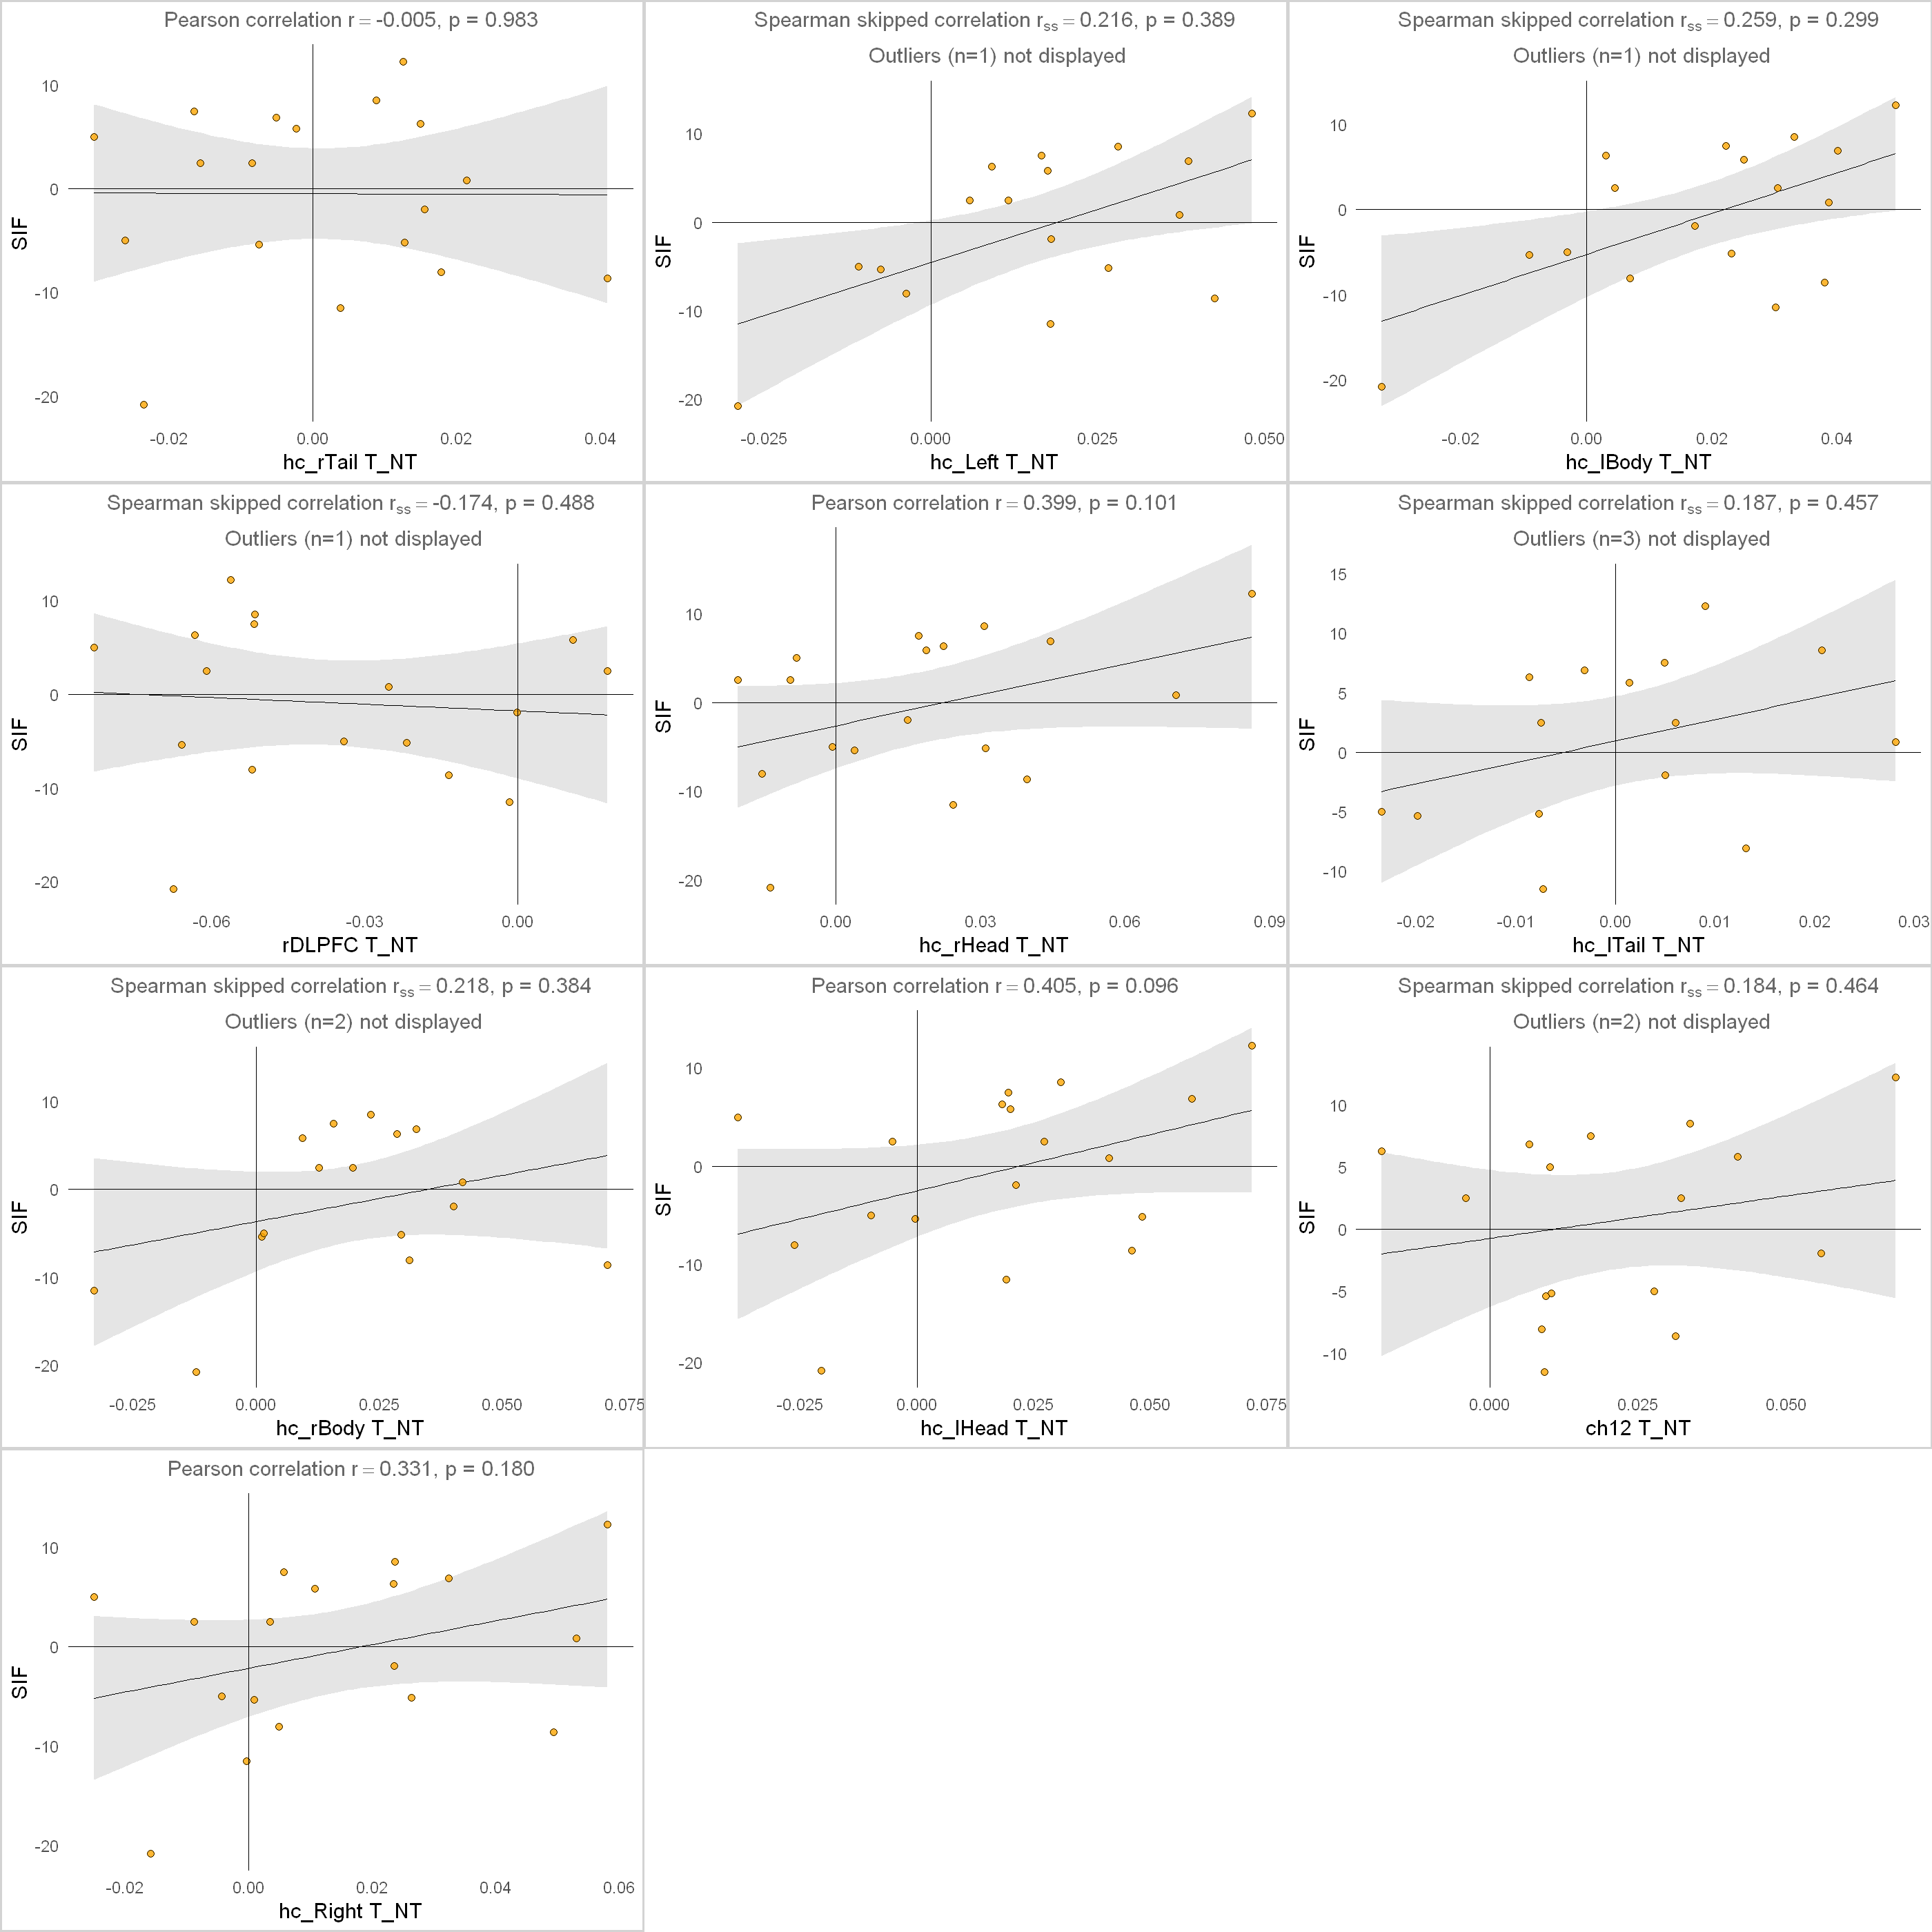

In [25]:
ds <- datasets[2]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "05_Yuhua"

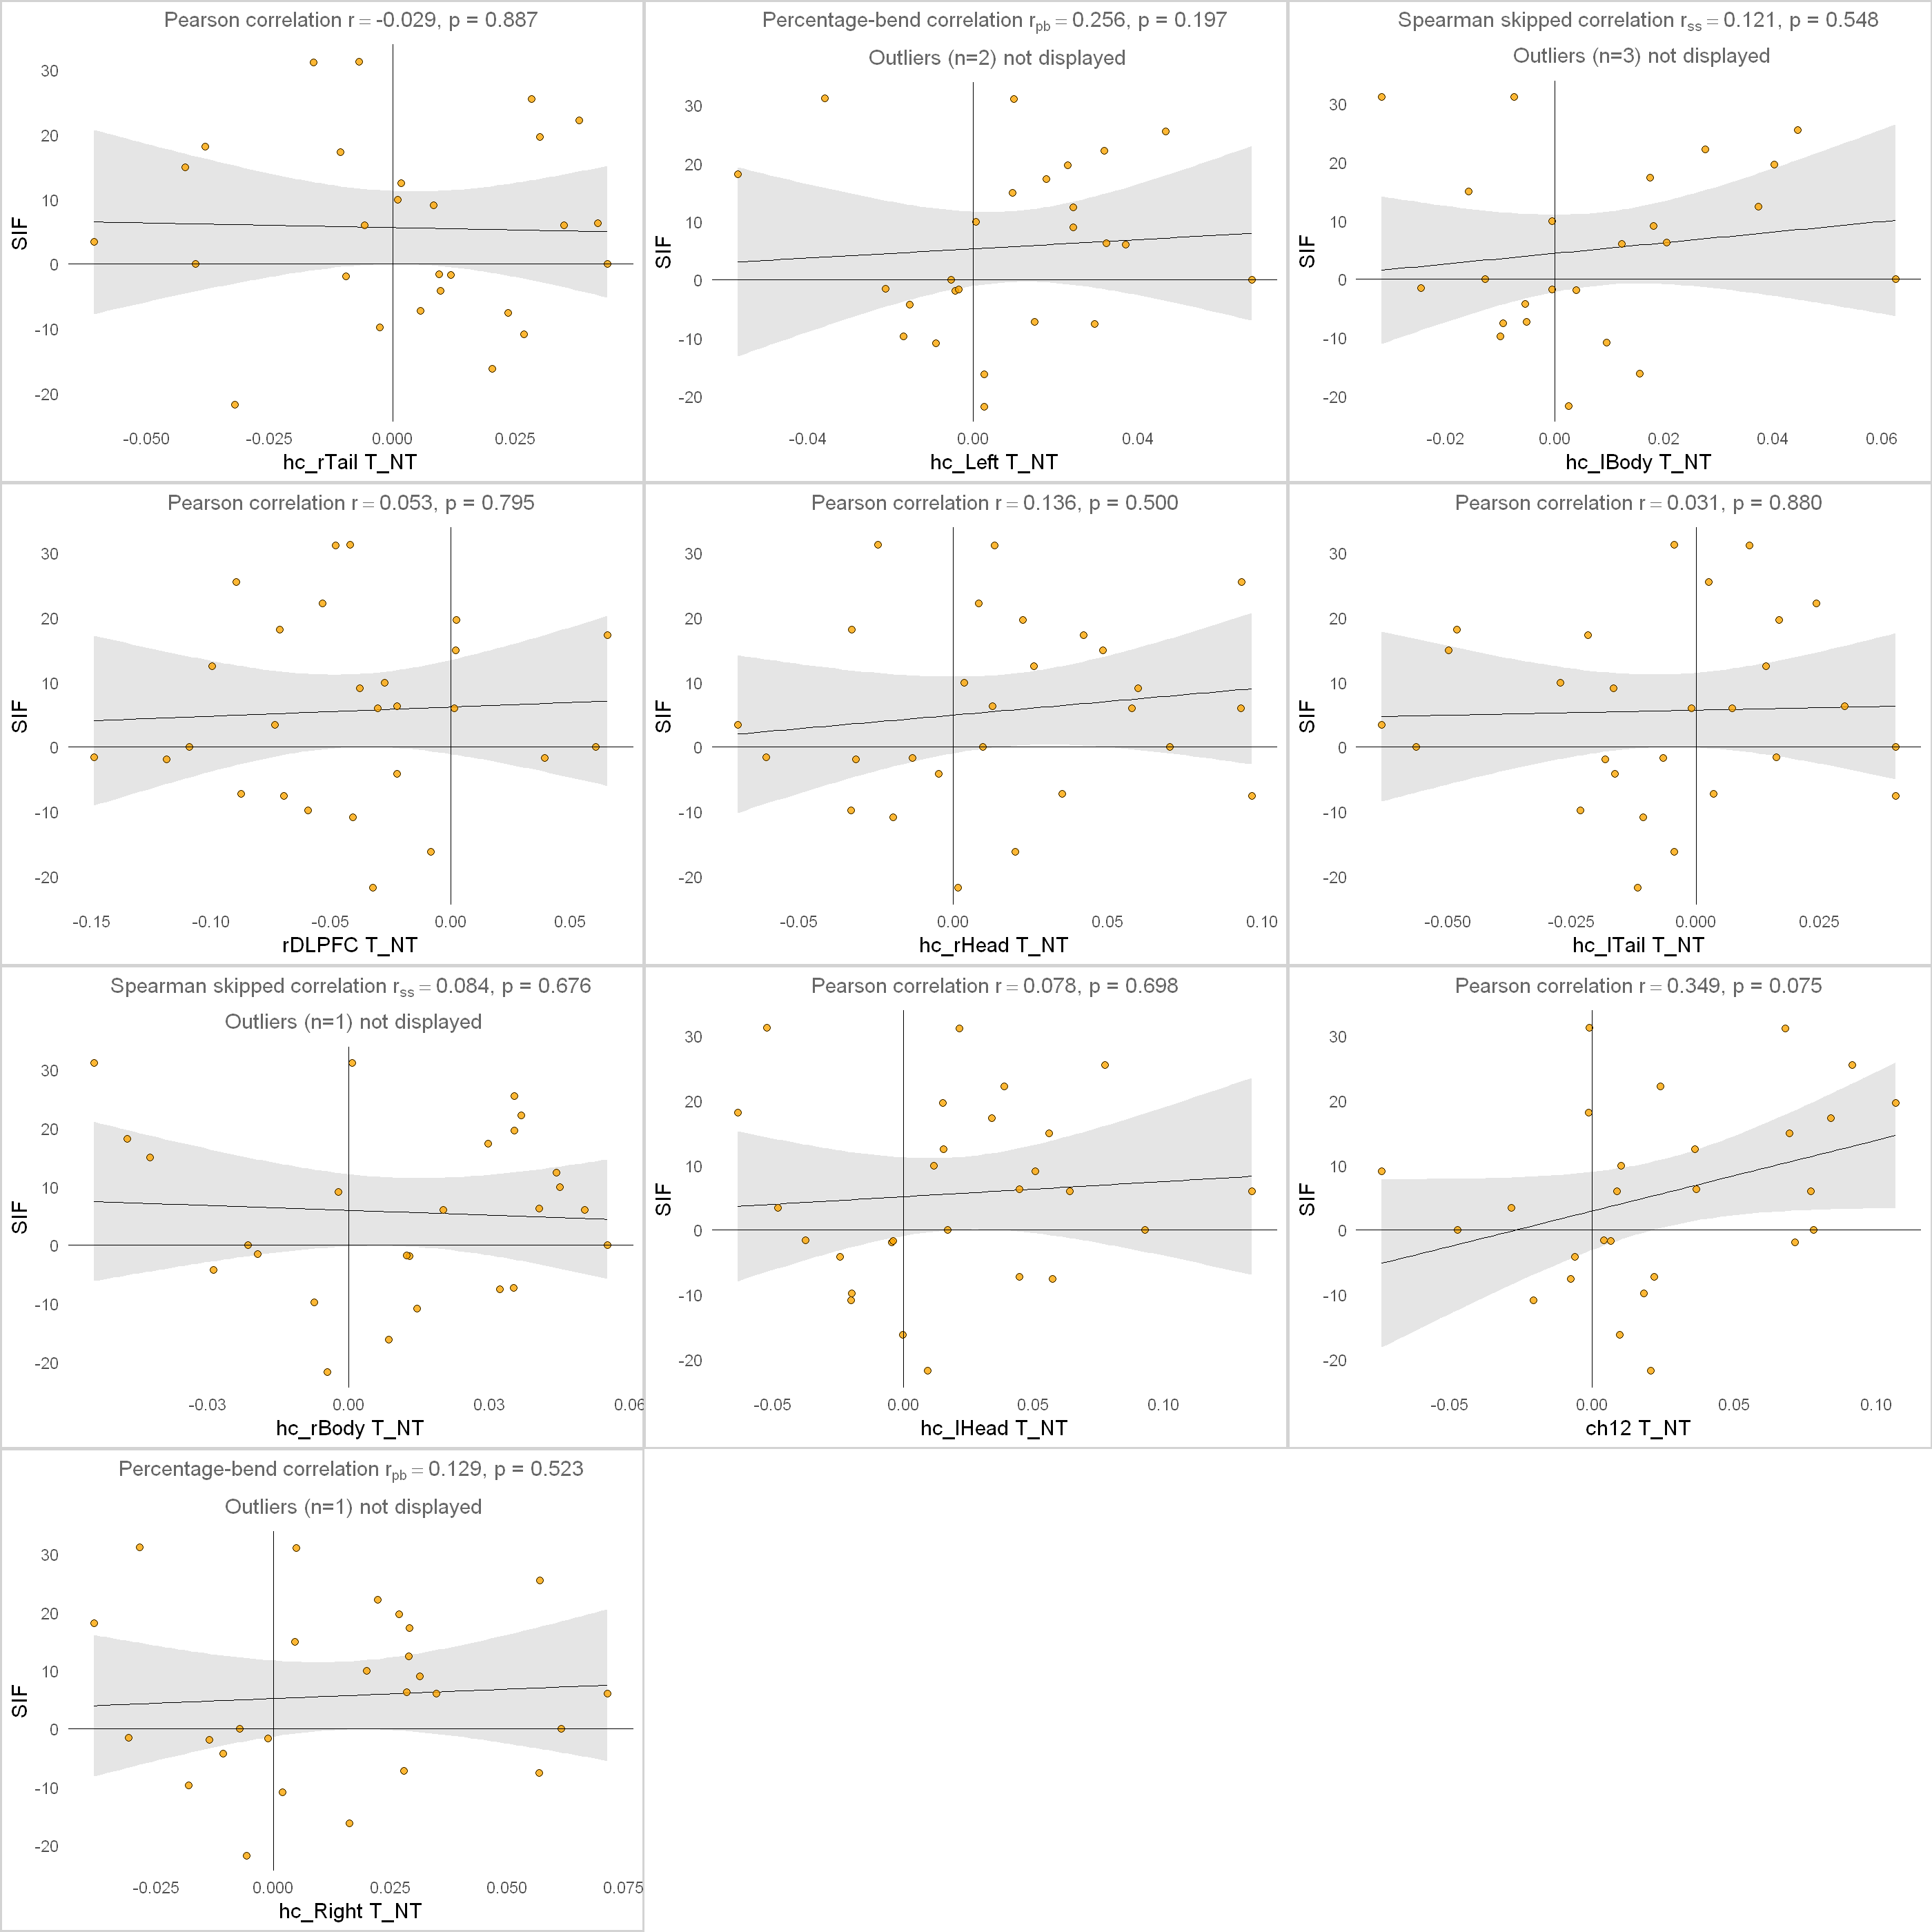

In [26]:
ds <- datasets[3]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "06_RolandNeuron"

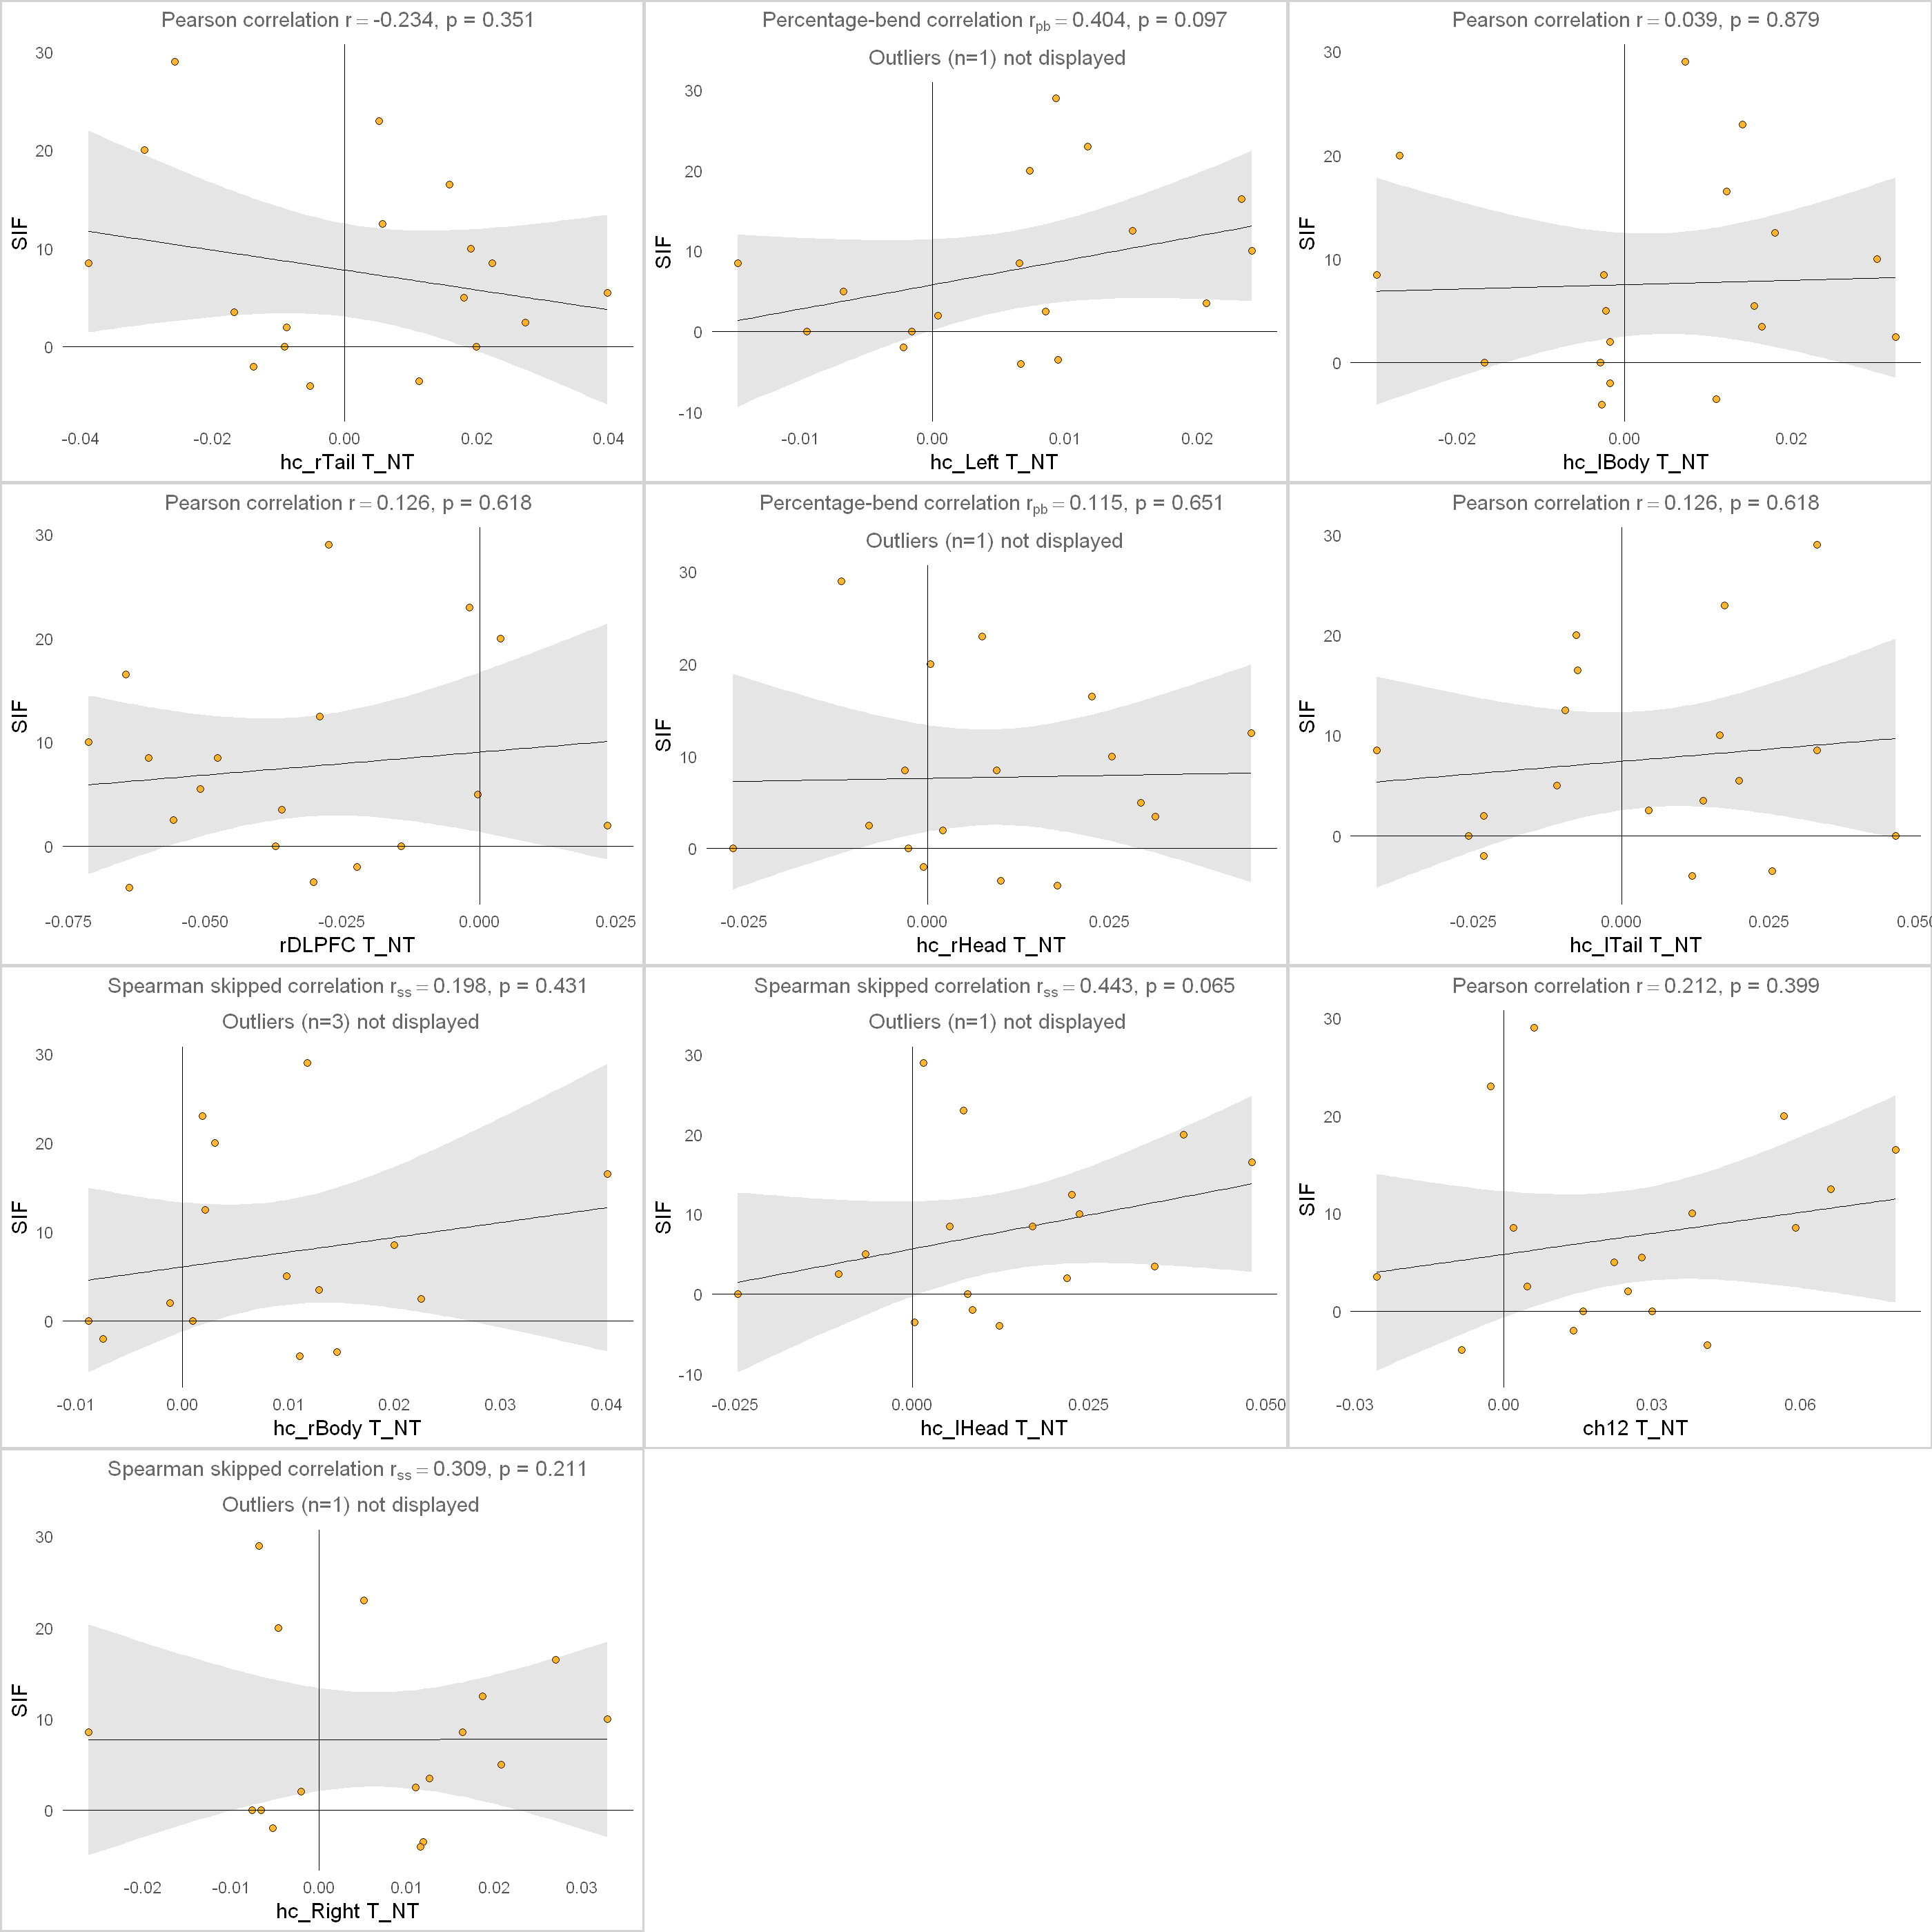

In [27]:
ds <- datasets[4]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "08_Taylor"

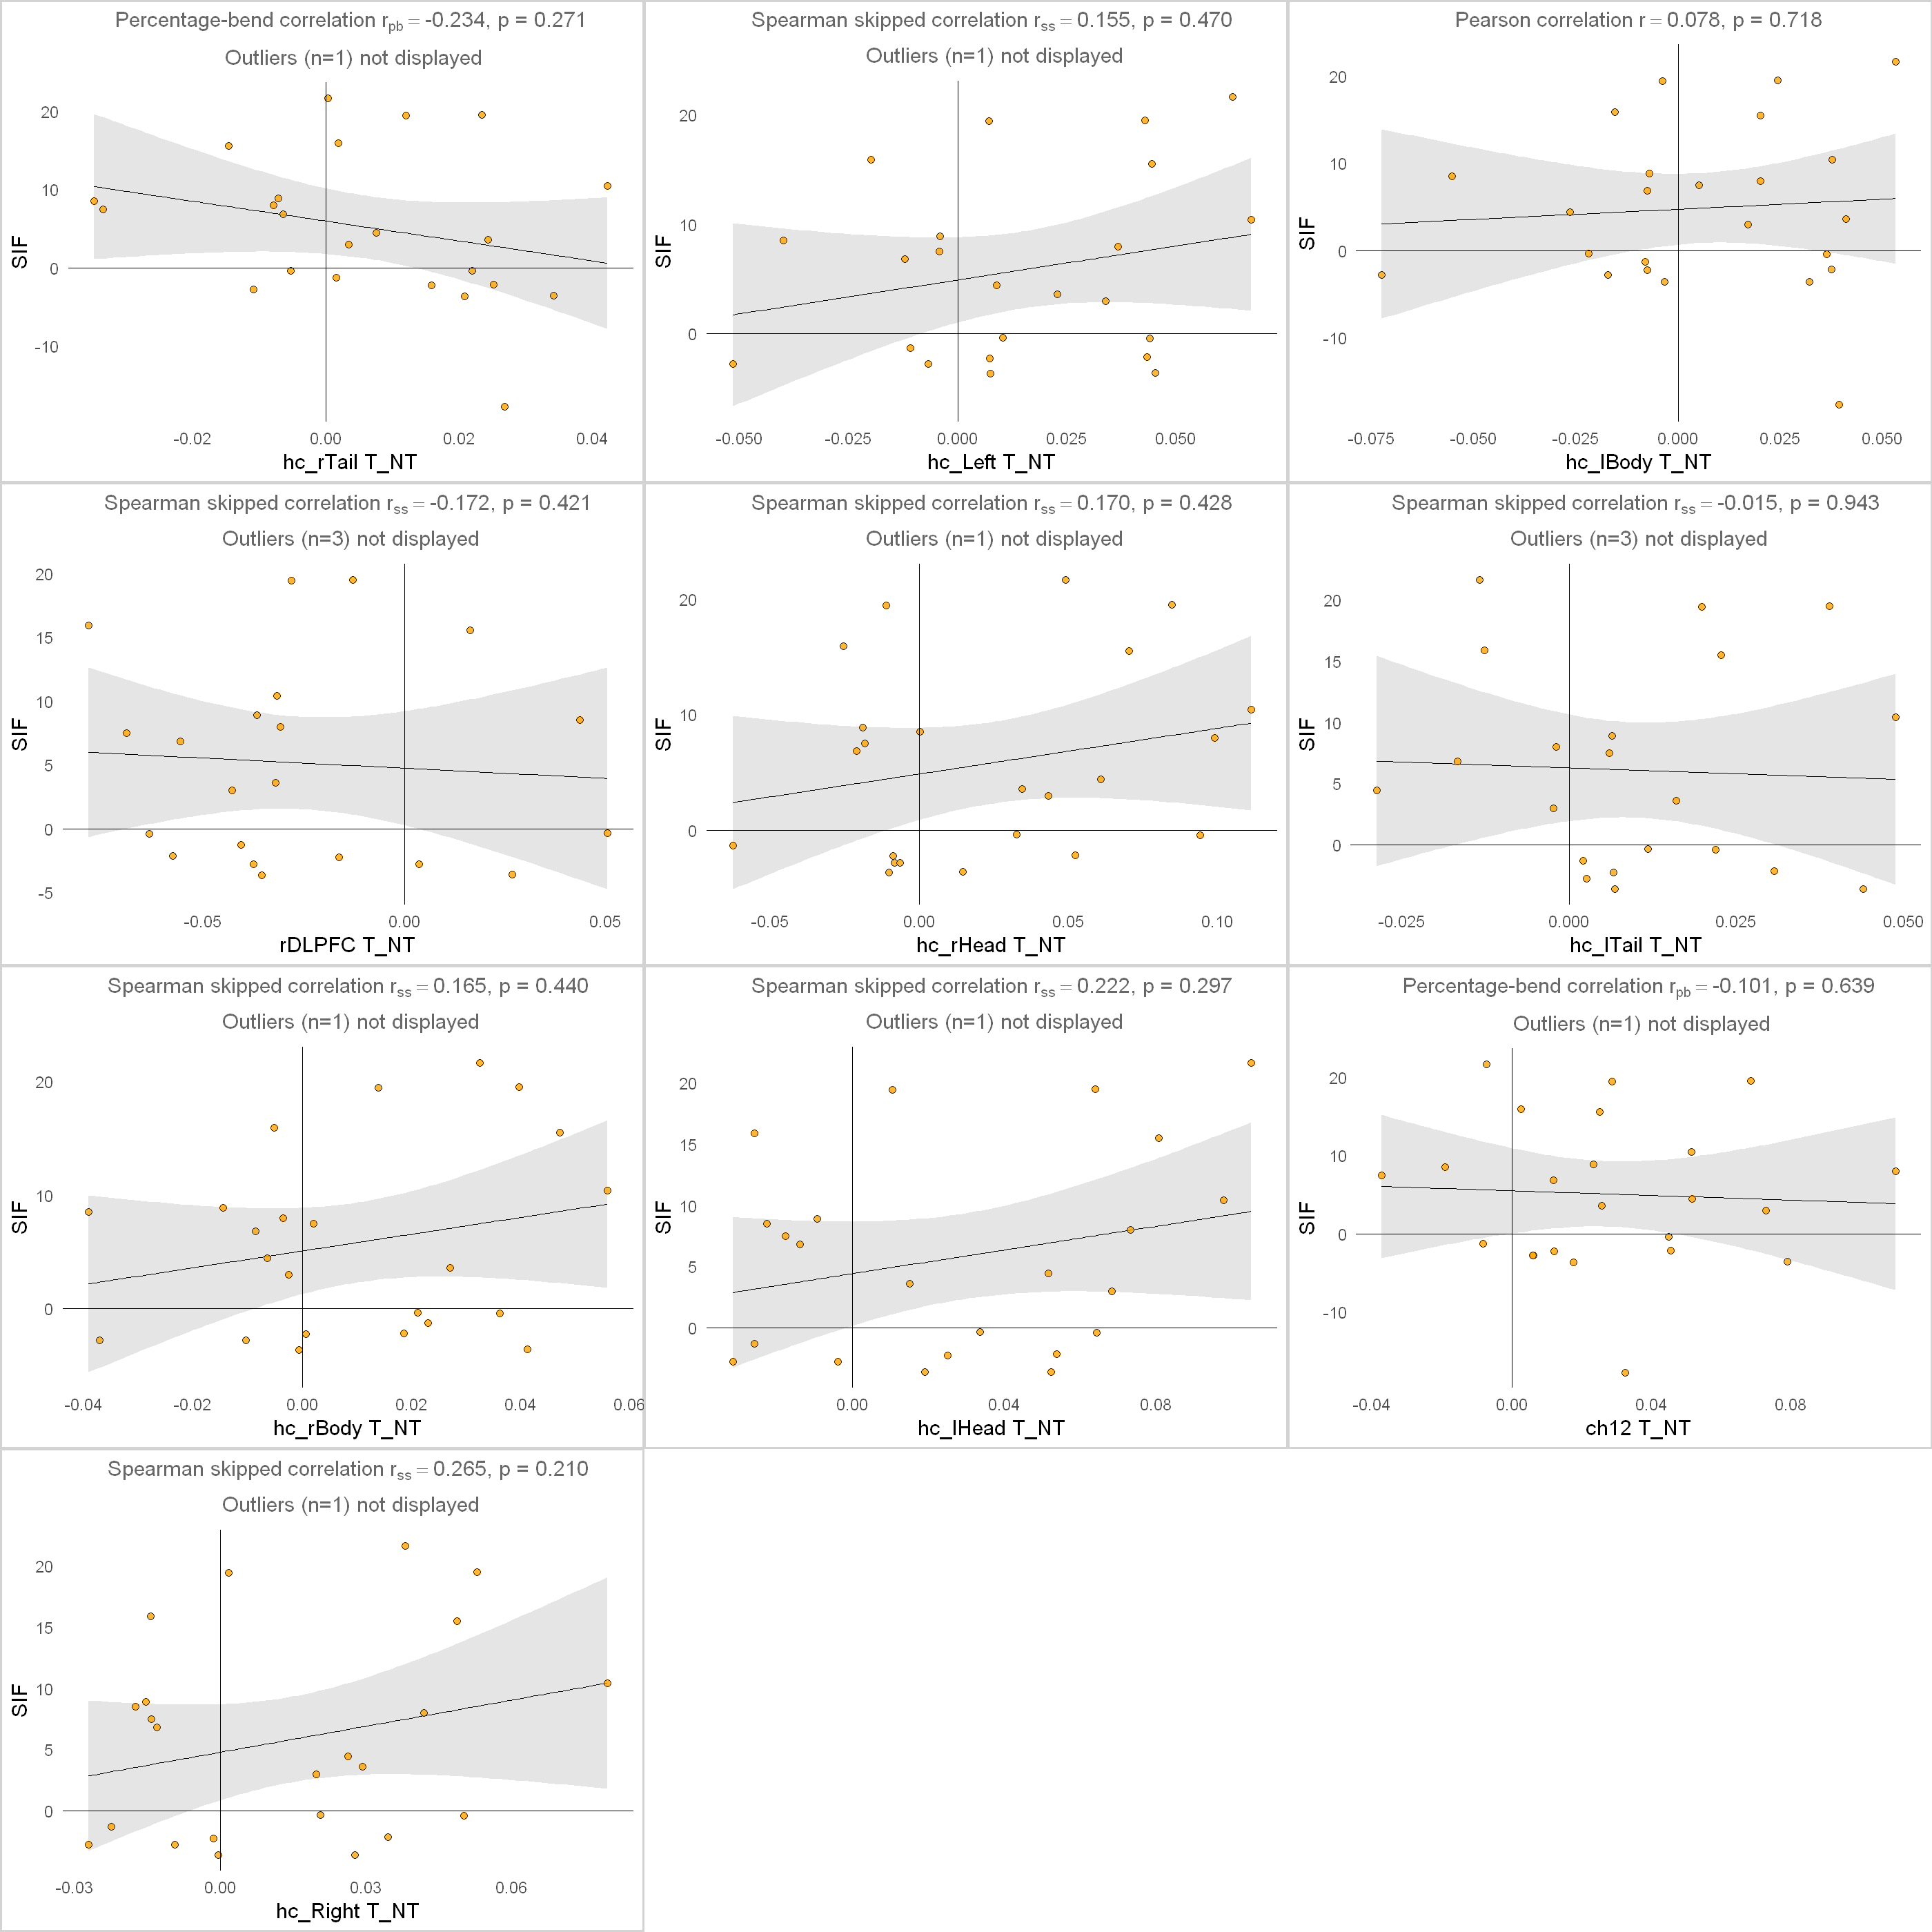

In [28]:
ds <- datasets[5]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "09_Xu"

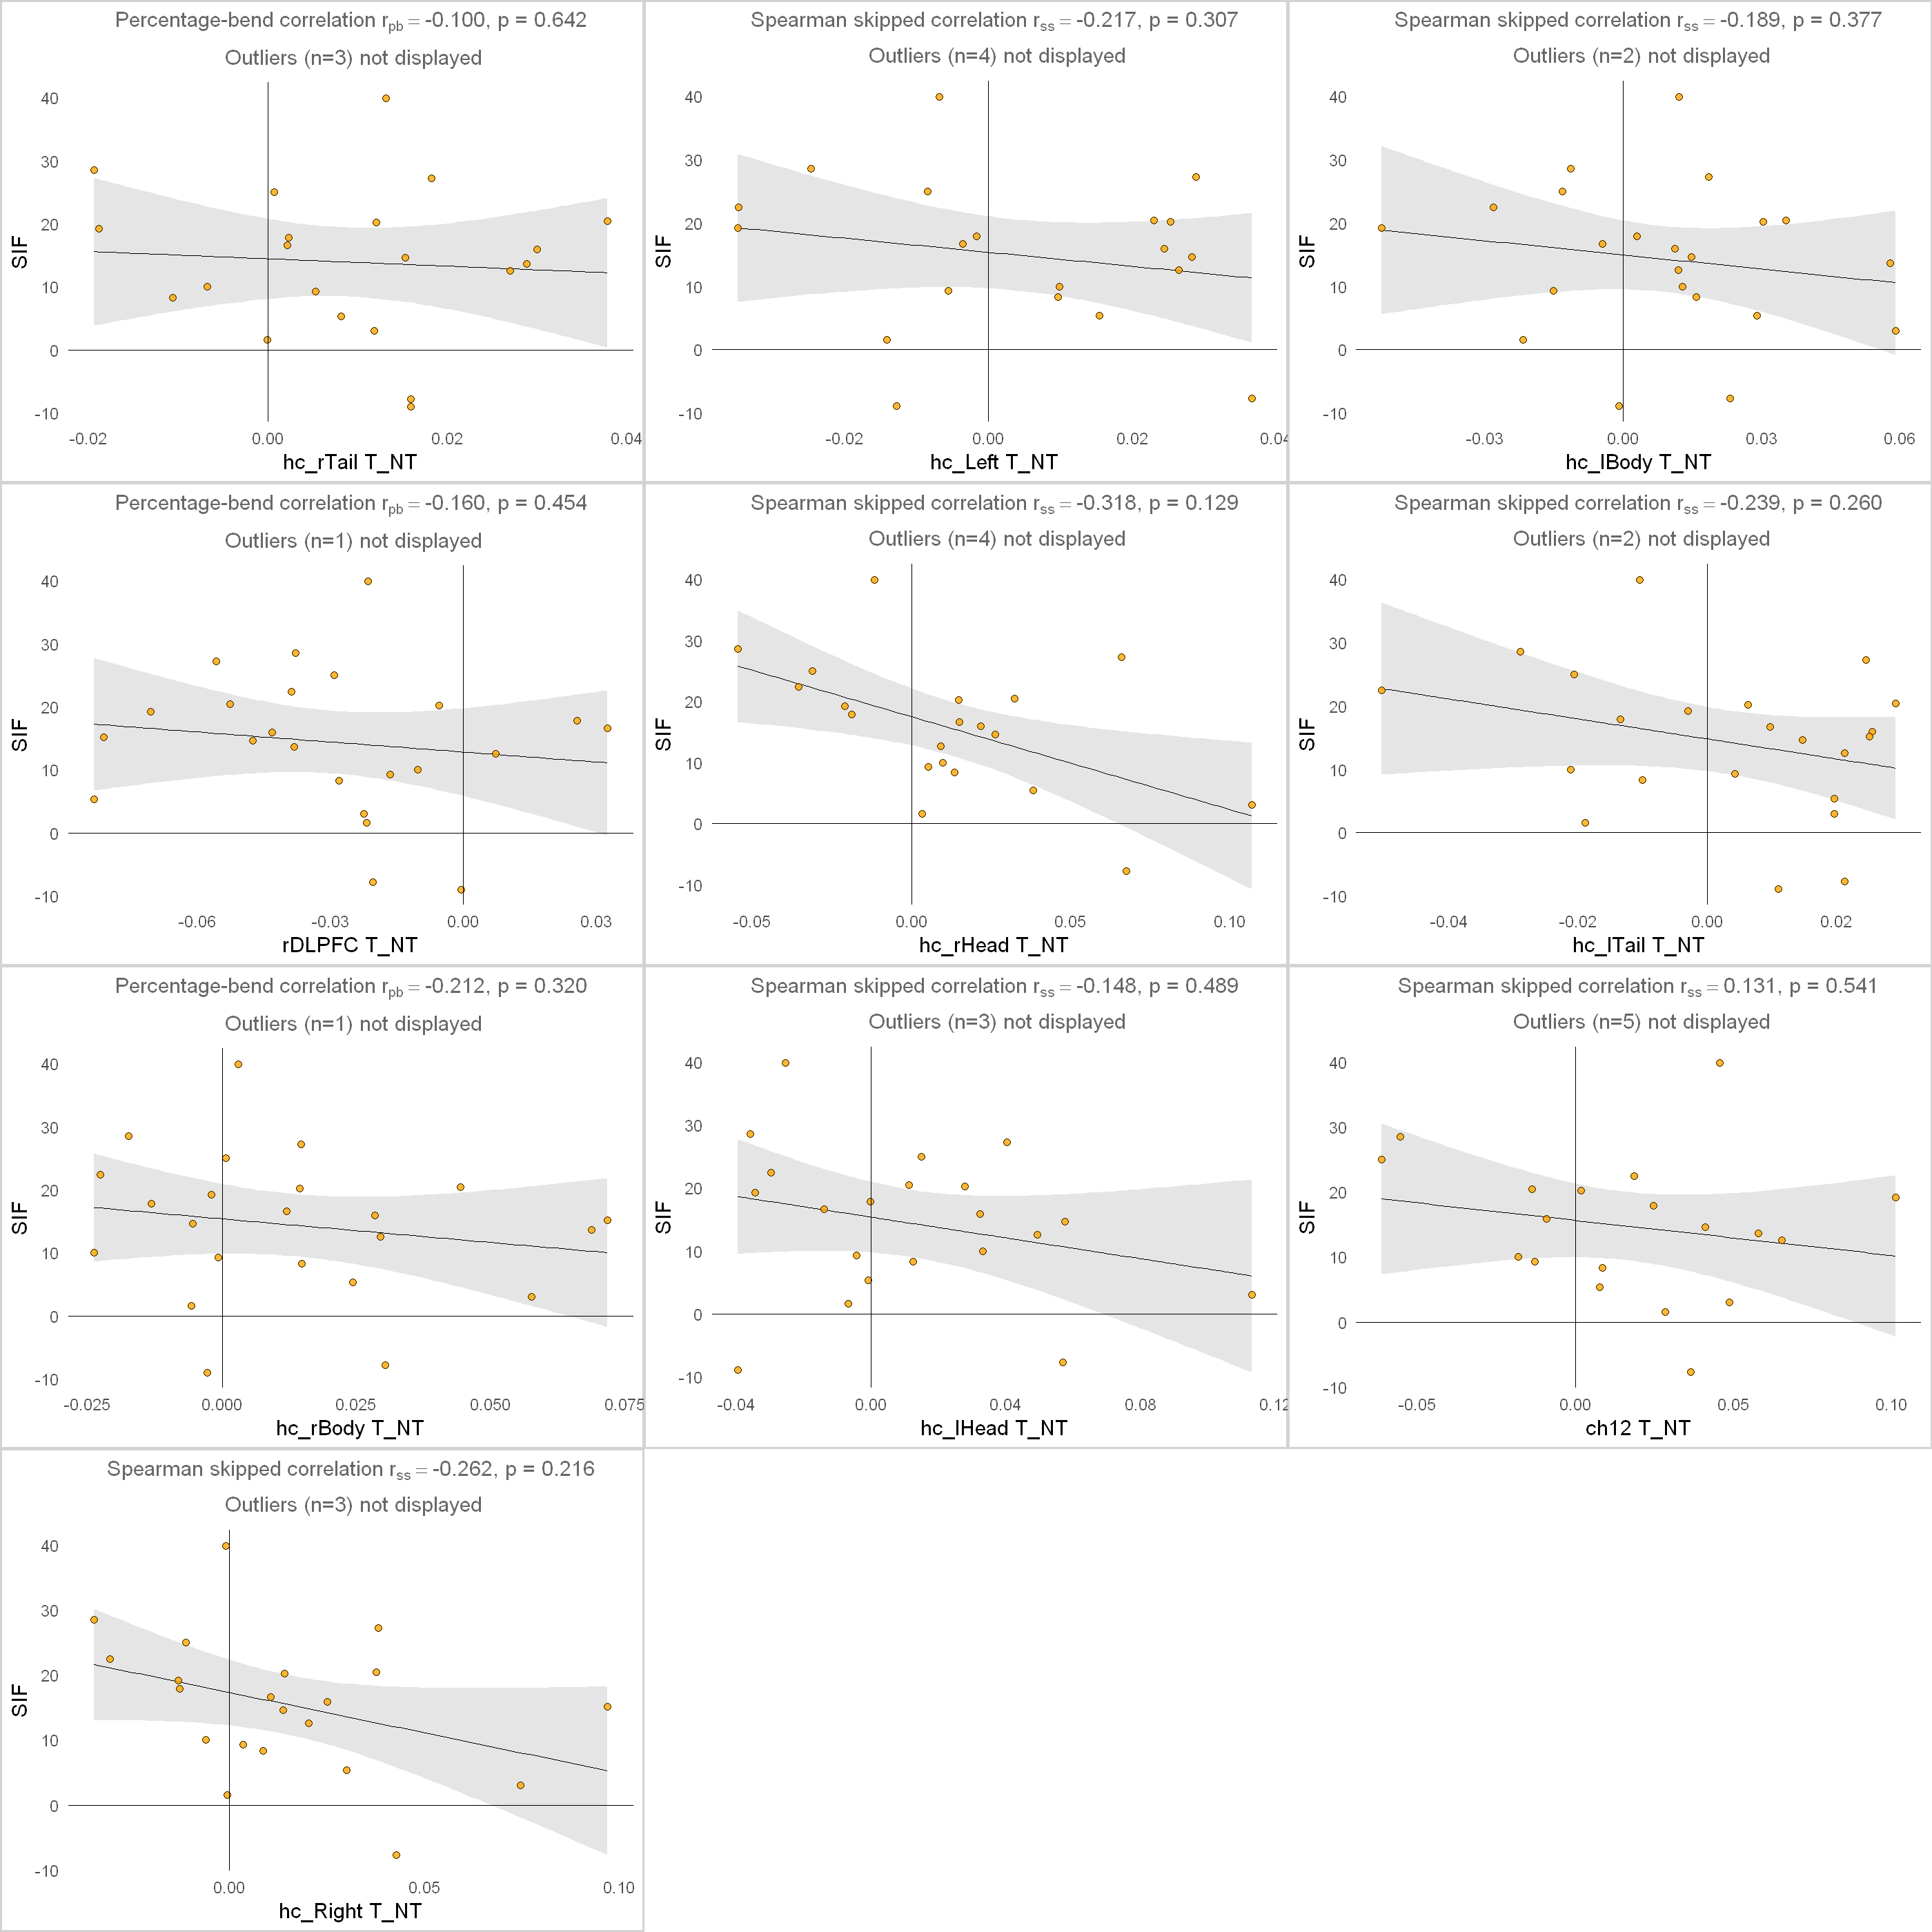

In [29]:
ds <- datasets[6]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")

[1] "10_Big-TNT"

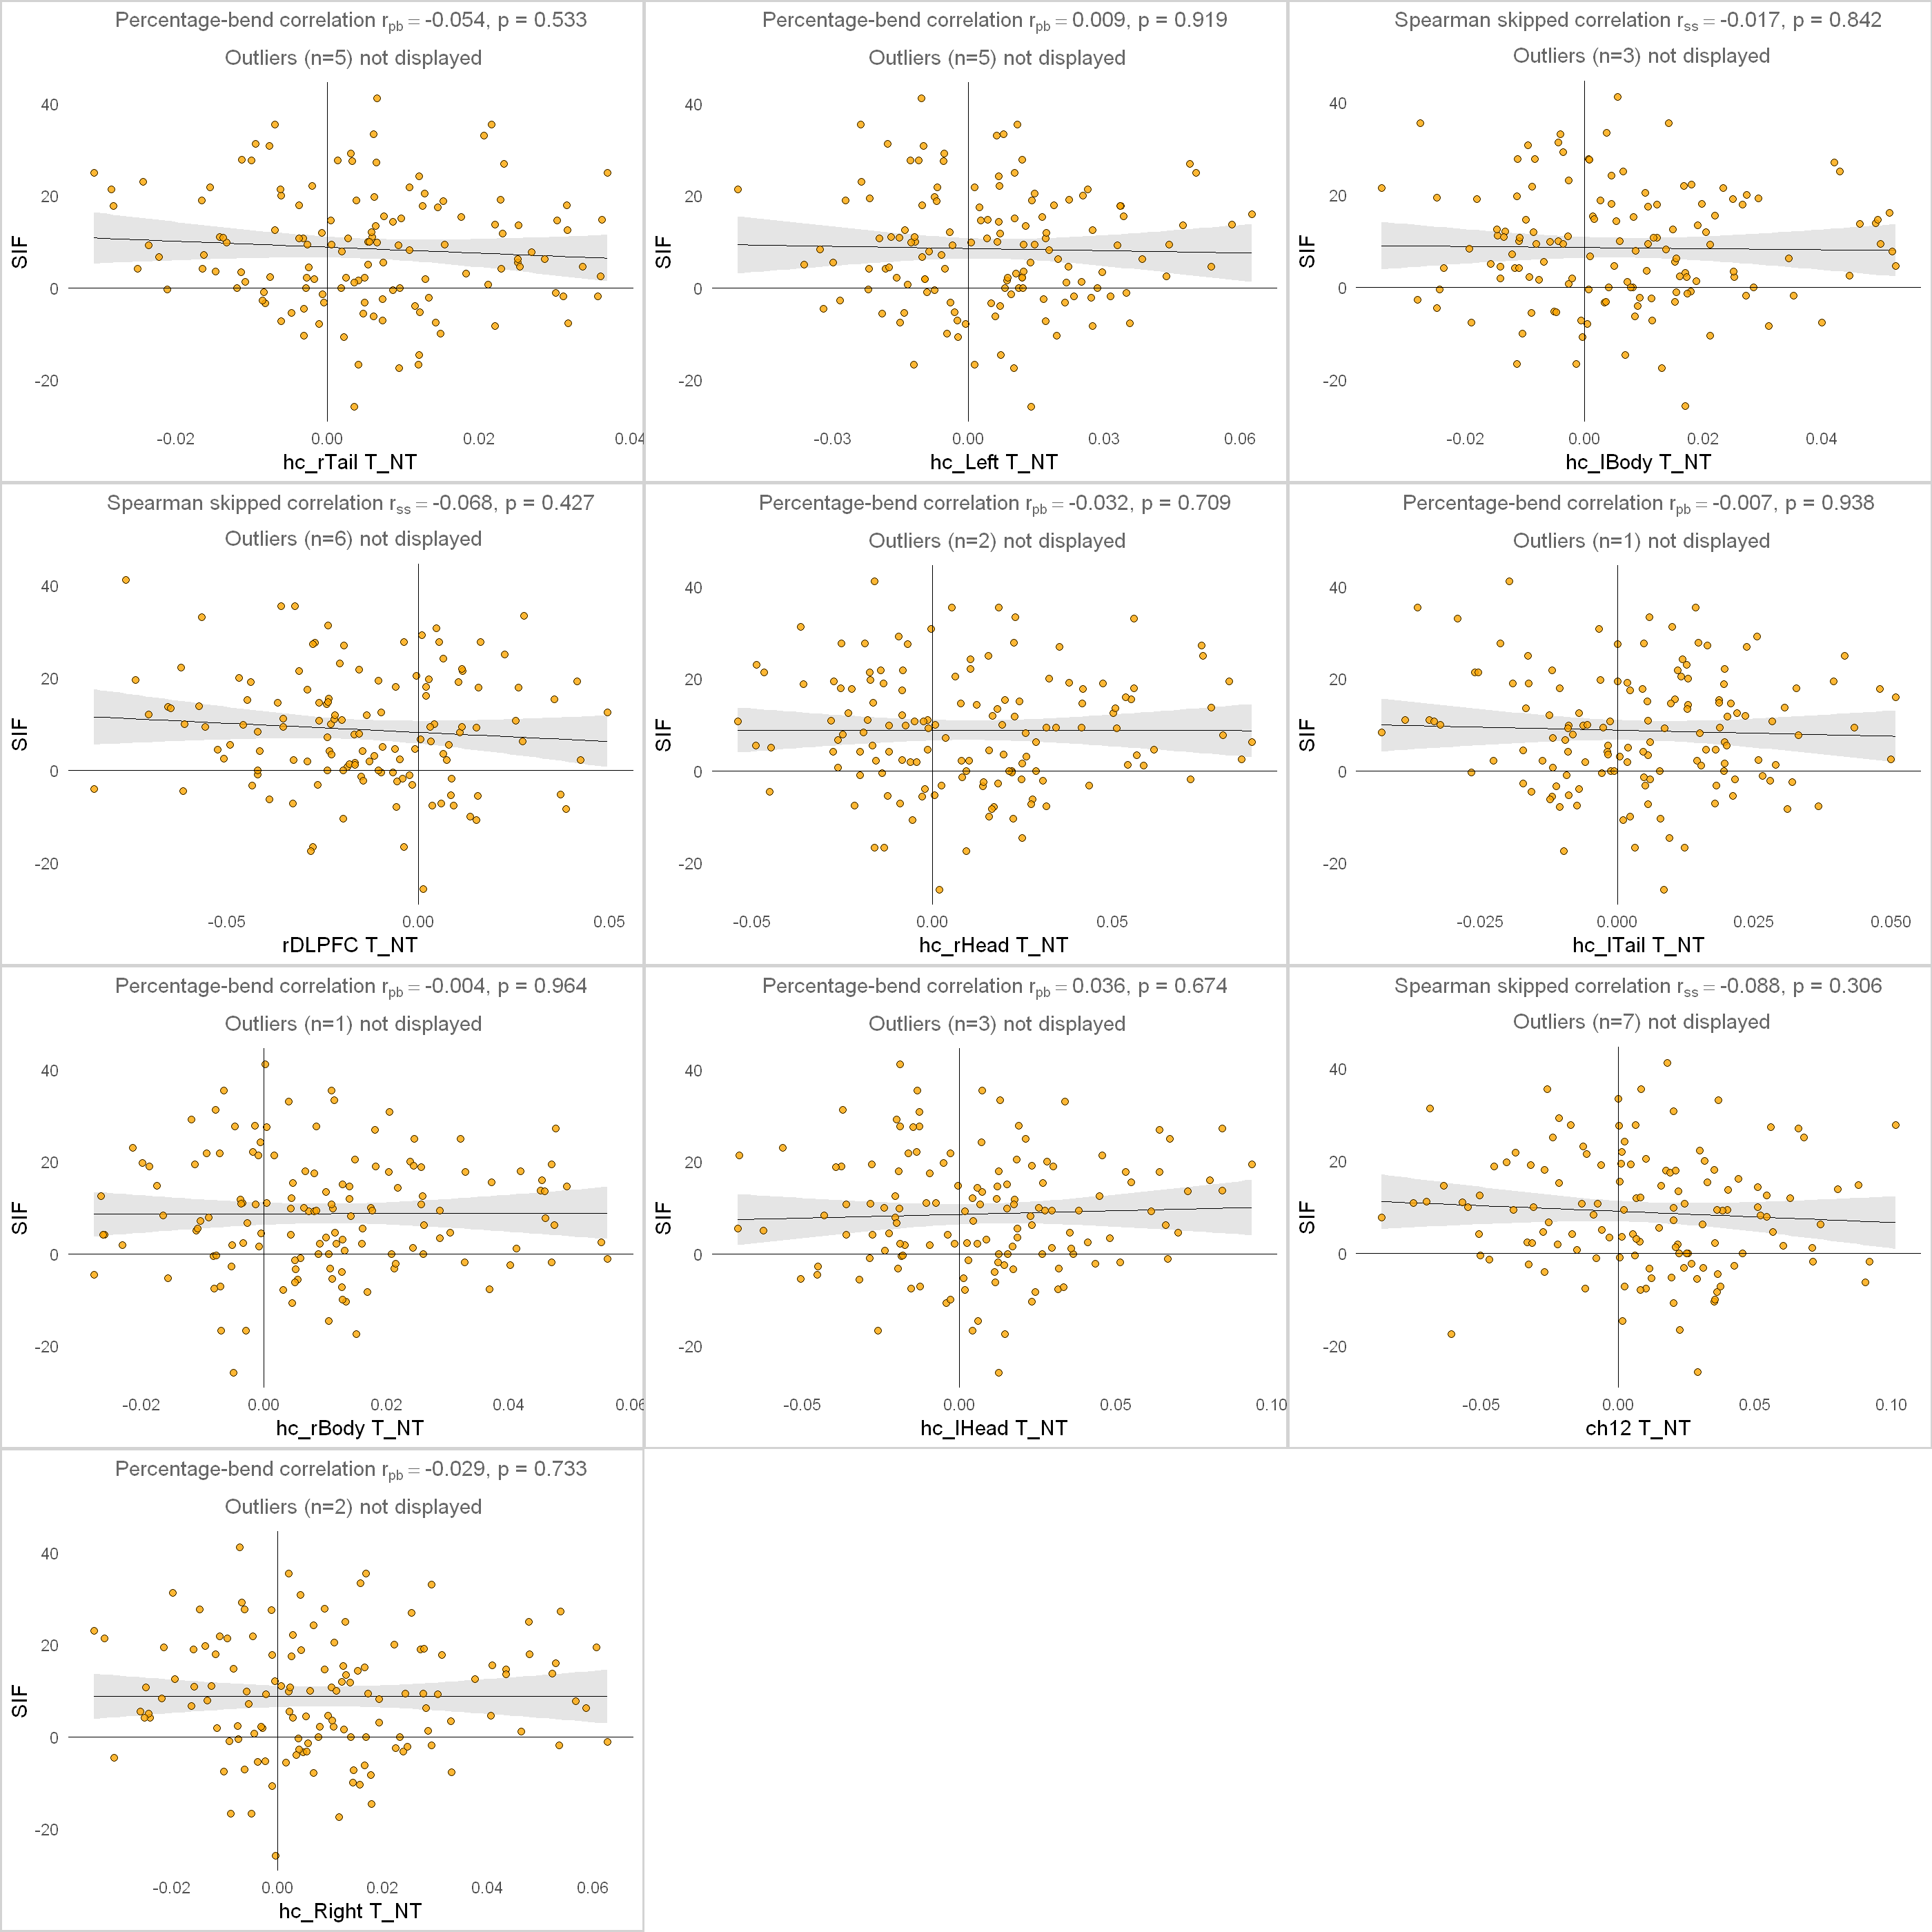

In [30]:
ds <- datasets[7]
paste(ds)
plot_per_roi(subset(data_sif.psc, data_sif.psc$stid == ds), rois, "T_NT", "SIF")